# TODO:


- $\gamma_3$ = 2*0.0197, all  $(\theta, \lambda, \vartheta)$ and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    converge but with kinks at y=2 for e(y):
    
    => check smaller (y_step, k_step)  (mainly y_step), tolerance level, time step may need to be adjusted accordingly.
    

- $\theta = 2$, five damage case $\gamma_3 \in [0. , 0.08, 0.16, 0.25 , 0.33]$, and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    for non-zero $\gamma_3$:
    
    negative emission, explosion of pde error, and mc hitting the zero-bound.
    

- $\theta = 3$, five damage case $\gamma_3 \in [0. , 0.08, 0.16, 0.25 , 0.33]$, and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    for non-zero $\gamma_3$:
    
    negative emission, 
    
    false transient errors oscillate at 1e-3 ~ 1e-4 level
    
    
4. $(\theta, \lambda, \vartheta) = (3, 0.134, 0.052)$
5. $(\theta, \lambda, \vartheta) = (3, 0.102, 0.036)$
6. $(\theta, \lambda, \vartheta) = (3, 0.0925, 0.032)$: reliable results $\gamma_3$ up to 0.18

In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_bar = 2.3
y_jump=2.
y_overline = 2.3
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 10)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
γ3_list

array([0.        , 0.03635853, 0.07288307, 0.10957512, 0.14643624,
       0.18346798, 0.22067194, 0.25804973, 0.29560298, 0.33333333])

In [7]:
y_step = 0.1
y_grid = np.arange(0., 3 + y_step, y_step)

k_step = 0.1
k_grid = np.arange(0., 9 + k_step, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [5]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o

    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)

    # initial guess
    v0 =  (1/δ)*k_mat   -  η/δ*y_mat**2 
    # initial i
    a_i = κ*(1/δ)
    b_i = - (1 + α*κ)*(1/δ)
    c_i = α*(1/δ) - 1
    i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

    ems = 0*np.ones(y_mat.shape)
    mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

    episode = 0
    lhs_error = 0.5
    vd = - 1/δ

    while lhs_error > tol and episode < max_iter:
        vold = v0.copy()
        v0_dy = finiteDiff(v0,0,1,dy)
        v0_dy[v0_dy > - 1e-15] =  -1e-15
        v0_dyy = finiteDiff(v0,0,2,dy)
        v0_dk = finiteDiff(v0,1,1,dk)
    #     v0_dk[v0_dk > - 1e-15] =  1e-15
        v0_dkk = finiteDiff(v0,1,2,dk)
        # updating controls
        i_new = (1 -mc/v0_dk)*(1/κ)
    #     update emission
        if θ == 2:
            a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
            b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
                + vd*dΛ*np.sum(θ_mat*πa, axis=0)
            ems_new = - b/a
        elif θ == 3:
            a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))/(α**2*λ_bar**2*np.exp(2*k_mat))
            b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2/(α*λ_bar*np.exp(k_mat)) + (v0_dyy+ vd*ddΛ)*σy**2 
            c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
            Δ = b**2 - 4*a*c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ))/(2*a)
            root2 = (-b + np.sqrt(Δ))/(2*a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2
        ems_new[ems_new < 0] = 0
        i_new = i_new*0.05 + i*0.95
        ems_new = ems_new*0.05 + ems*0.95
        ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
    #     ratio[ratio > 1] = 1
        consumption = α - i_new - α*ϑ_bar*ratio**θ
    #     consumption[consumption < 1e-15] = 1e-15
        mc_new = 1/consumption

    #     mc_new[mc_new <= 1e-15] = 1e-15
    #     mc_new = mc_new*0.05 + mc*0.95
        temp = v0_dy + vd*dΛ
        weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
        πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
#         print("min ems:", np.min(ems_new))
#         print("min mc", np.min(mc_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems_new
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems_new**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems = ems_new
        mc = mc_new
        i = i_new
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, i=i,  πa=πa, v0_dy=v0_dy, v0_dyy=v0_dyy)
    return result

HJB:

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)
\end{aligned}
$$



Denote

$$
mc = \frac{1}{\alpha - i - \alpha \vartheta (1 - \frac{e}{\alpha \lambda  \exp(k)})^\theta}
$$

First order condition for $i$:

$$
 - mc + \frac{d\phi}{dk} (1 - \kappa i) = 0
$$

FOC for $e$:

$$
mc \cdot (\bar{\vartheta} \theta \frac{1 }{\lambda \exp (k)}  (1 - \frac{e}{\alpha \lambda \exp{k}})^{\theta - 1}) + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell + \frac{d^2 \phi(y)}{dy^2}  \mid \varsigma \mid ^2  e + v_d (\Lambda' \sum \omega_\ell \theta_\ell + \Lambda'' \mid \varsigma \mid ^2 e) = 0
$$

$\theta = 3$:


In [8]:
# HJB for ϕ_m
θ = 3
y_bar = 2.3
ξa = 0.01
ξb = 3
ϑ_bar = 0.052
λ_bar = 0.134
γ3 = γ3_list[1]
# γ3 = 2*0.0197

α=0.115
# σy=0
σy=1.2*np.mean(θ_list)
ϵ=0.1


max_iter=10_000
tol=1e-6

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
ddΛ = γ2 + γ3*(y_mat > y_bar)

# initial guess
v0 =  (1/δ)*k_mat   -  η/δ*y_mat**2 
# initial i
a_i = κ*(1/δ)
b_i = - (1 + α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

ems = 0*np.ones(y_mat.shape)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

episode = 0
lhs_error = 0.5
vd = - 1/δ

while lhs_error > tol and episode < max_iter:
    vold = v0.copy()
    v0_dy = finiteDiff(v0,0,1,dy)
    v0_dy[v0_dy > - 1e-15] =  -1e-15
    v0_dyy = finiteDiff(v0,0,2,dy)
    v0_dk = finiteDiff(v0,1,1,dk)
#     v0_dk[v0_dk > - 1e-15] =  1e-15
    v0_dkk = finiteDiff(v0,1,2,dk)
    # updating controls
    i_new = (1 -mc/v0_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = - b/a
    elif θ == 3:
        a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))/(α**2*λ_bar**2*np.exp(2*k_mat))
        b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2/(α*λ_bar*np.exp(k_mat)) + (v0_dyy+ vd*ddΛ)*σy**2 
        c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    ems_new[ems_new < 0] = 0
    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
#     ratio[ratio > 1] = 1
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[consumption < 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = v0_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

min ems: 0.0
min mc 48.043016228750396
Episode 0: PDE Error: 1.948909852023; ft Error: 1.947503543994; Iterations: 4; CG Error: 0.000000000014
min ems: 0.0
min mc 45.24875721037594
Episode 1: PDE Error: 1.940477911791; ft Error: 1.939457548877; Iterations: 4; CG Error: 0.000000000019
min ems: 0.0
min mc 43.39480356096362
Episode 2: PDE Error: 1.934874558309; ft Error: 1.934174726621; Iterations: 4; CG Error: 0.000000000027
min ems: 0.0
min mc 42.115156407186184
Episode 3: PDE Error: 1.930817654271; ft Error: 1.930365792588; Iterations: 4; CG Error: 0.000000000038
min ems: 0.0
min mc 41.213102209840265
Episode 4: PDE Error: 1.927639740073; ft Error: 1.927378250786; Iterations: 4; CG Error: 0.000000000051
min ems: 0.0
min mc 40.571638754979205
Episode 5: PDE Error: 1.924974860573; ft Error: 1.924858104941; Iterations: 4; CG Error: 0.000000000066
min ems: 0.0
min mc 40.115993744333295
Episode 6: PDE Error: 1.922615082631; ft Error: 1.922607109269; Iterations: 4; CG Error: 0.000000000081
m

min ems: 0.0
min mc 39.970468698027936
Episode 71: PDE Error: 1.801709841839; ft Error: 1.801910341525; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 39.969693406161404
Episode 72: PDE Error: 1.799911769962; ft Error: 1.800132026420; Iterations: 5; CG Error: 0.000000000024
min ems: 0.0
min mc 39.96889472003841
Episode 73: PDE Error: 1.798115317446; ft Error: 1.798355074380; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 39.96807436397927
Episode 74: PDE Error: 1.796320484553; ft Error: 1.796579488009; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 39.96715500394236
Episode 75: PDE Error: 1.794527271582; ft Error: 1.794805269627; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 39.96621527455426
Episode 76: PDE Error: 1.792735678864; ft Error: 1.793032421318; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 39.965257280927176
Episode 77: PDE Error: 1.790945706770; ft Error: 1.791260944958; Iterations: 5; CG Error: 0.000000000

Episode 141: PDE Error: 1.681479168883; ft Error: 1.681254000392; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.87472947761934
Episode 142: PDE Error: 1.679879905709; ft Error: 1.679592781995; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.8730059821642
Episode 143: PDE Error: 1.678280685163; ft Error: 1.677932703717; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.871275452458406
Episode 144: PDE Error: 1.676681533637; ft Error: 1.676273772586; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.86953795198396
Episode 145: PDE Error: 1.675082476891; ft Error: 1.674615995547; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.86779354458517
Episode 146: PDE Error: 1.673483540076; ft Error: 1.672959379516; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.86604229445331
Episode 147: PDE Error: 1.671884747748; ft Error: 1.671303931336; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.8642842

min ems: 0.0
min mc 39.74279451934146
Episode 211: PDE Error: 1.570677885568; ft Error: 1.569123492295; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.74074247930232
Episode 212: PDE Error: 1.569123435277; ft Error: 1.567570097319; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.73867434268539
Episode 213: PDE Error: 1.567570035271; ft Error: 1.566017760540; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.73660009171143
Episode 214: PDE Error: 1.566017693381; ft Error: 1.564466489666; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.734523628897755
Episode 215: PDE Error: 1.564466417332; ft Error: 1.562916292302; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.732445008475366
Episode 216: PDE Error: 1.562916214735; ft Error: 1.561367175938; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.73036428455555
Episode 217: PDE Error: 1.561367093095; ft Error: 1.559819147967; Iterations: 5; CG Error: 0.000

min ems: 0.0
min mc 39.59410993560351
Episode 281: PDE Error: 1.464730476414; ft Error: 1.463262728021; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.591961523289314
Episode 282: PDE Error: 1.463262404251; ft Error: 1.461795988472; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.589814258978805
Episode 283: PDE Error: 1.461795663166; ft Error: 1.460330580210; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.58766817085561
Episode 284: PDE Error: 1.460330253414; ft Error: 1.458866503419; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.58552328703069
Episode 285: PDE Error: 1.458866175170; ft Error: 1.457403758189; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.58337963554125
Episode 286: PDE Error: 1.457403428526; ft Error: 1.455942344537; Iterations: 5; CG Error: 0.000000000006
min ems: 0.0
min mc 39.58123724434976
Episode 287: PDE Error: 1.455942013496; ft Error: 1.454482262405; Iterations: 5; CG Error: 0.000

min ems: 0.0
min mc 39.44456144190361
Episode 352: PDE Error: 1.363769745096; ft Error: 1.362394766968; Iterations: 5; CG Error: 0.000000000007
min ems: 0.0
min mc 39.44252480467525
Episode 353: PDE Error: 1.362394375361; ft Error: 1.361020676284; Iterations: 5; CG Error: 0.000000000007
min ems: 0.0
min mc 39.44049102609917
Episode 354: PDE Error: 1.361020284103; ft Error: 1.359647864157; Iterations: 5; CG Error: 0.000000000007
min ems: 0.0
min mc 39.43846011551787
Episode 355: PDE Error: 1.359647471432; ft Error: 1.358276330760; Iterations: 5; CG Error: 0.000000000007
min ems: 0.0
min mc 39.43643208224985
Episode 356: PDE Error: 1.358275937513; ft Error: 1.356906076318; Iterations: 5; CG Error: 0.000000000007
min ems: 0.0
min mc 39.43440693558906
Episode 357: PDE Error: 1.356905682576; ft Error: 1.355537101116; Iterations: 5; CG Error: 0.000000000007
min ems: 0.0
min mc 39.4323846848047
Episode 358: PDE Error: 1.355536706909; ft Error: 1.354169405498; Iterations: 5; CG Error: 0.000000

min ems: 0.0
min mc 39.309385351168416
Episode 422: PDE Error: 1.270634980496; ft Error: 1.269352263123; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.307569727683685
Episode 423: PDE Error: 1.269351948096; ft Error: 1.268070604976; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.30575753881254
Episode 424: PDE Error: 1.268070293017; ft Error: 1.266790325349; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.30394879135183
Episode 425: PDE Error: 1.266790016492; ft Error: 1.265511425413; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.302143492050405
Episode 426: PDE Error: 1.265511119698; ft Error: 1.264233906295; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.300341647608924
Episode 427: PDE Error: 1.264233603754; ft Error: 1.262957769048; Iterations: 5; CG Error: 0.000000000009
min ems: 0.0
min mc 39.2985432646795
Episode 428: PDE Error: 1.262957469721; ft Error: 1.261683014684; Iterations: 5; CG Error: 0.00

Episode 493: PDE Error: 1.182967093755; ft Error: 1.181781112113; Iterations: 5; CG Error: 0.000000000010
min ems: 0.0
min mc 39.18779174328137
Episode 494: PDE Error: 1.181781020412; ft Error: 1.180596334117; Iterations: 5; CG Error: 0.000000000010
min ems: 0.0
min mc 39.186237664410676
Episode 495: PDE Error: 1.180596244636; ft Error: 1.179412850616; Iterations: 5; CG Error: 0.000000000010
min ems: 0.0
min mc 39.184687372383486
Episode 496: PDE Error: 1.179412763317; ft Error: 1.178230658478; Iterations: 5; CG Error: 0.000000000010
min ems: 0.0
min mc 39.18314086995798
Episode 497: PDE Error: 1.178230573321; ft Error: 1.177049754541; Iterations: 5; CG Error: 0.000000000010
min ems: 0.0
min mc 39.181598159830315
Episode 498: PDE Error: 1.177049671490; ft Error: 1.175870135630; Iterations: 5; CG Error: 0.000000000010
min ems: 0.0
min mc 39.180059244634144
Episode 499: PDE Error: 1.175870054645; ft Error: 1.174691798550; Iterations: 5; CG Error: 0.000000000010
min ems: 0.0
min mc 39.178

min ems: 0.0
min mc 39.08824466879155
Episode 564: PDE Error: 1.101797983038; ft Error: 1.100696307509; Iterations: 5; CG Error: 0.000000000012
min ems: 0.0
min mc 39.0869588759512
Episode 565: PDE Error: 1.100696295829; ft Error: 1.099595712924; Iterations: 5; CG Error: 0.000000000012
min ems: 0.0
min mc 39.08567691045828
Episode 566: PDE Error: 1.099595701626; ft Error: 1.098496209493; Iterations: 5; CG Error: 0.000000000012
min ems: 0.0
min mc 39.08439877065668
Episode 567: PDE Error: 1.098496198569; ft Error: 1.097397795393; Iterations: 5; CG Error: 0.000000000012
min ems: 0.0
min mc 39.08312445482879
Episode 568: PDE Error: 1.097397784832; ft Error: 1.096300468831; Iterations: 5; CG Error: 0.000000000012
min ems: 0.0
min mc 39.08185396119579
Episode 569: PDE Error: 1.096300458626; ft Error: 1.095204228058; Iterations: 5; CG Error: 0.000000000012
min ems: 0.0
min mc 39.080587287917766
Episode 570: PDE Error: 1.095204218199; ft Error: 1.094109071356; Iterations: 5; CG Error: 0.00000

min ems: 0.0
min mc 39.0048089636992
Episode 635: PDE Error: 1.026217489887; ft Error: 1.025190373073; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 39.00369528329827
Episode 636: PDE Error: 1.025190383080; ft Error: 1.024164285977; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 39.0025849452025
Episode 637: PDE Error: 1.024164296400; ft Error: 1.023139218223; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 39.00147794628556
Episode 638: PDE Error: 1.023139229073; ft Error: 1.022115169038; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 39.00037428338346
Episode 639: PDE Error: 1.022115180318; ft Error: 1.021092137627; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 38.99927395329476
Episode 640: PDE Error: 1.021092149342; ft Error: 1.020070123193; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 38.99817695278059
Episode 641: PDE Error: 1.020070135346; ft Error: 1.019049124919; Iterations: 5; CG Error: 0.0000000

min ems: 0.0
min mc 38.93294348201338
Episode 707: PDE Error: 0.954816615765; ft Error: 0.953860345403; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 38.93206034364197
Episode 708: PDE Error: 0.953860393747; ft Error: 0.952905064722; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 38.931180234174505
Episode 709: PDE Error: 0.952905113645; ft Error: 0.951950724778; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 38.9303031481321
Episode 710: PDE Error: 0.951950774276; ft Error: 0.950997324392; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 38.92942908000936
Episode 711: PDE Error: 0.950997374468; ft Error: 0.950044862401; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 38.92855802427457
Episode 712: PDE Error: 0.950044913053; ft Error: 0.949093337646; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 38.92768997536978
Episode 713: PDE Error: 0.949093388874; ft Error: 0.948142748973; Iterations: 5; CG Error: 0.00000

min ems: 0.0
min mc 38.876748146046154
Episode 779: PDE Error: 0.888316174369; ft Error: 0.887425275390; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.87606770995268
Episode 780: PDE Error: 0.887425370010; ft Error: 0.886535353518; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.875389852608194
Episode 781: PDE Error: 0.886535448935; ft Error: 0.885646314400; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.87471456715022
Episode 782: PDE Error: 0.885646410623; ft Error: 0.884758157520; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.87404184670493
Episode 783: PDE Error: 0.884758254555; ft Error: 0.883870882358; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.87337168438728
Episode 784: PDE Error: 0.883870980209; ft Error: 0.882984488392; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.872704073301236
Episode 785: PDE Error: 0.882984587067; ft Error: 0.882098975102; Iterations: 5; CG Error: 0.00

min ems: 0.0
min mc 38.83129670238946
Episode 851: PDE Error: 0.826402024384; ft Error: 0.825573112314; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.83074780146863
Episode 852: PDE Error: 0.825573279913; ft Error: 0.824745201517; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.830201130426616
Episode 853: PDE Error: 0.824745370276; ft Error: 0.823918124664; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.829656682777276
Episode 854: PDE Error: 0.823918294585; ft Error: 0.823091880862; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.82911445202854
Episode 855: PDE Error: 0.823092051947; ft Error: 0.822266469218; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.82857443168229
Episode 856: PDE Error: 0.822266641466; ft Error: 0.821441888829; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.82803661523475
Episode 857: PDE Error: 0.821442062243; ft Error: 0.820618138795; Iterations: 5; CG Error: 0.000

Episode 922: PDE Error: 0.769584061838; ft Error: 0.768812113693; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 38.79708482966327
Episode 923: PDE Error: 0.768812365600; ft Error: 0.768041189390; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 38.79667972213321
Episode 924: PDE Error: 0.768041442553; ft Error: 0.767271037513; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 38.796276372441596
Episode 925: PDE Error: 0.767271291942; ft Error: 0.766501657320; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 38.79587477410525
Episode 926: PDE Error: 0.766501913013; ft Error: 0.765733048058; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 38.795474920646804
Episode 927: PDE Error: 0.765733305018; ft Error: 0.764965208980; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 38.79507680559471
Episode 928: PDE Error: 0.764965467211; ft Error: 0.764198139343; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 38.79468

min ems: 0.0
min mc 38.77262442998508
Episode 993: PDE Error: 0.716673773794; ft Error: 0.715954845236; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.77232714536741
Episode 994: PDE Error: 0.715955191951; ft Error: 0.715236984422; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.77203118540796
Episode 995: PDE Error: 0.715237332531; ft Error: 0.714519845295; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.77173654431046
Episode 996: PDE Error: 0.714520194803; ft Error: 0.713803427124; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.771443216291814
Episode 997: PDE Error: 0.713803778033; ft Error: 0.713087729181; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.771151195582306
Episode 998: PDE Error: 0.713088081488; ft Error: 0.712372750723; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.770860476425455
Episode 999: PDE Error: 0.712373104433; ft Error: 0.711658491019; Iterations: 5; CG Error: 0.00

Episode 1064: PDE Error: 0.667407601863; ft Error: 0.666738036915; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.75427455137751
Episode 1065: PDE Error: 0.666738489545; ft Error: 0.666069594088; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.75405867768126
Episode 1066: PDE Error: 0.666070048273; ft Error: 0.665401821625; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.75384374853352
Episode 1067: PDE Error: 0.665402277368; ft Error: 0.664734718855; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.75362975922383
Episode 1068: PDE Error: 0.664735176154; ft Error: 0.664068285096; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.75341670505796
Episode 1069: PDE Error: 0.664068743954; ft Error: 0.663402519679; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.75320458135801
Episode 1070: PDE Error: 0.663402980096; ft Error: 0.662737421925; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.

min ems: 0.0
min mc 38.74120161533429
Episode 1135: PDE Error: 0.621530674962; ft Error: 0.620907021249; Iterations: 5; CG Error: 0.000000000037
min ems: 0.0
min mc 38.741041378940565
Episode 1136: PDE Error: 0.620907590119; ft Error: 0.620284560133; Iterations: 5; CG Error: 0.000000000037
min ems: 0.0
min mc 38.74088179678075
Episode 1137: PDE Error: 0.620285130749; ft Error: 0.619662723865; Iterations: 5; CG Error: 0.000000000037
min ems: 0.0
min mc 38.74072286528051
Episode 1138: PDE Error: 0.619663296225; ft Error: 0.619041511818; Iterations: 5; CG Error: 0.000000000037
min ems: 0.0
min mc 38.74056458088124
Episode 1139: PDE Error: 0.619042085924; ft Error: 0.618420923366; Iterations: 5; CG Error: 0.000000000038
min ems: 0.0
min mc 38.74040694004003
Episode 1140: PDE Error: 0.618421499222; ft Error: 0.617800957888; Iterations: 5; CG Error: 0.000000000038
min ems: 0.0
min mc 38.740249939229656
Episode 1141: PDE Error: 0.617801535493; ft Error: 0.617181614761; Iterations: 5; CG Error

min ems: 0.0
min mc 38.731383449944886
Episode 1205: PDE Error: 0.579391382119; ft Error: 0.578809898900; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 38.731261211282366
Episode 1206: PDE Error: 0.578810593940; ft Error: 0.578229691747; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 38.73113941292661
Episode 1207: PDE Error: 0.578230388673; ft Error: 0.577650066914; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 38.73101805232473
Episode 1208: PDE Error: 0.577650765736; ft Error: 0.577071023822; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 38.730897126937165
Episode 1209: PDE Error: 0.577071724548; ft Error: 0.576492561901; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 38.730776634237436
Episode 1210: PDE Error: 0.576493264529; ft Error: 0.575914680560; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 38.73065657171223
Episode 1211: PDE Error: 0.575915385099; ft Error: 0.575337379224; Iterations: 5; CG Err

min ems: 0.0
min mc 38.72376191646594
Episode 1275: PDE Error: 0.540112743542; ft Error: 0.539570558203; Iterations: 5; CG Error: 0.000000000046
min ems: 0.0
min mc 38.72366501636476
Episode 1276: PDE Error: 0.539571391521; ft Error: 0.539029747881; Iterations: 5; CG Error: 0.000000000046
min ems: 0.0
min mc 38.72356840731729
Episode 1277: PDE Error: 0.539030583237; ft Error: 0.538489480756; Iterations: 5; CG Error: 0.000000000046
min ems: 0.0
min mc 38.72347208758629
Episode 1278: PDE Error: 0.538490318148; ft Error: 0.537949756286; Iterations: 5; CG Error: 0.000000000046
min ems: 0.0
min mc 38.72337605544456
Episode 1279: PDE Error: 0.537950595713; ft Error: 0.537410573928; Iterations: 5; CG Error: 0.000000000046
min ems: 0.0
min mc 38.723280309174875
Episode 1280: PDE Error: 0.537411415393; ft Error: 0.536871933141; Iterations: 5; CG Error: 0.000000000046
min ems: 0.0
min mc 38.72318484706988
Episode 1281: PDE Error: 0.536872776645; ft Error: 0.536333833393; Iterations: 5; CG Error:

Episode 1344: PDE Error: 0.504007127369; ft Error: 0.503501069339; Iterations: 5; CG Error: 0.000000000050
min ems: 0.0
min mc 38.71759535304528
Episode 1345: PDE Error: 0.503502049797; ft Error: 0.502996497167; Iterations: 5; CG Error: 0.000000000050
min ems: 0.0
min mc 38.717515138867675
Episode 1346: PDE Error: 0.502997479832; ft Error: 0.502492432099; Iterations: 5; CG Error: 0.000000000050
min ems: 0.0
min mc 38.717435115908636
Episode 1347: PDE Error: 0.502493416971; ft Error: 0.501988873631; Iterations: 5; CG Error: 0.000000000050
min ems: 0.0
min mc 38.71735528302638
Episode 1348: PDE Error: 0.501989860709; ft Error: 0.501485821256; Iterations: 5; CG Error: 0.000000000050
min ems: 0.0
min mc 38.71727563908625
Episode 1349: PDE Error: 0.501486810545; ft Error: 0.500983274482; Iterations: 5; CG Error: 0.000000000050
min ems: 0.0
min mc 38.717196182960585
Episode 1350: PDE Error: 0.500984265974; ft Error: 0.500481232795; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 

Episode 1413: PDE Error: 0.470321653599; ft Error: 0.469849307119; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.712455012338246
Episode 1414: PDE Error: 0.469850444871; ft Error: 0.469378570019; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.712385650068725
Episode 1415: PDE Error: 0.469379710135; ft Error: 0.468908306441; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.7123164148136
Episode 1416: PDE Error: 0.468909448919; ft Error: 0.468438515912; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.71224730583221
Episode 1417: PDE Error: 0.468439660753; ft Error: 0.467969197963; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.712178322388546
Episode 1418: PDE Error: 0.467970345168; ft Error: 0.467500352125; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.71210946375121
Episode 1419: PDE Error: 0.467501501694; ft Error: 0.467031977929; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 3

Episode 1483: PDE Error: 0.438456399425; ft Error: 0.438015952204; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.707020113745294
Episode 1484: PDE Error: 0.438017259209; ft Error: 0.437577251657; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.706936558568046
Episode 1485: PDE Error: 0.437578561169; ft Error: 0.437138992850; Iterations: 5; CG Error: 0.000000000060
min ems: 0.0
min mc 38.706853098275715
Episode 1486: PDE Error: 0.437140304867; ft Error: 0.436701175342; Iterations: 5; CG Error: 0.000000000060
min ems: 0.0
min mc 38.70676973248365
Episode 1487: PDE Error: 0.436702489864; ft Error: 0.436263798698; Iterations: 5; CG Error: 0.000000000060
min ems: 0.0
min mc 38.70668646080935
Episode 1488: PDE Error: 0.436265115723; ft Error: 0.435826862474; Iterations: 5; CG Error: 0.000000000060
min ems: 0.0
min mc 38.706603282872294
Episode 1489: PDE Error: 0.435828182008; ft Error: 0.435390366243; Iterations: 5; CG Error: 0.000000000060
min ems: 0.0
min mc

Episode 1553: PDE Error: 0.408760841208; ft Error: 0.408350133474; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.70138111571078
Episode 1554: PDE Error: 0.408351618366; ft Error: 0.407941320540; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.70130337693918
Episode 1555: PDE Error: 0.407942808053; ft Error: 0.407532919722; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.701225710513064
Episode 1556: PDE Error: 0.407534409860; ft Error: 0.407124930615; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.70114811616523
Episode 1557: PDE Error: 0.407126423378; ft Error: 0.406717352815; Iterations: 5; CG Error: 0.000000000065
min ems: 0.0
min mc 38.701070593629815
Episode 1558: PDE Error: 0.406718848199; ft Error: 0.406310185907; Iterations: 5; CG Error: 0.000000000065
min ems: 0.0
min mc 38.7009931426422
Episode 1559: PDE Error: 0.406311683916; ft Error: 0.405903429488; Iterations: 5; CG Error: 0.000000000065
min ems: 0.0
min mc 38

min ems: 0.0
min mc 38.69610058268156
Episode 1624: PDE Error: 0.380708186195; ft Error: 0.380325587679; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.696027326605524
Episode 1625: PDE Error: 0.380327260360; ft Error: 0.379945043634; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.695954126882356
Episode 1626: PDE Error: 0.379946719034; ft Error: 0.379564883717; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.69588098331784
Episode 1627: PDE Error: 0.379566561835; ft Error: 0.379185107552; Iterations: 5; CG Error: 0.000000000070
min ems: 0.0
min mc 38.69580789571853
Episode 1628: PDE Error: 0.379186788383; ft Error: 0.378805714752; Iterations: 5; CG Error: 0.000000000070
min ems: 0.0
min mc 38.695734863891865
Episode 1629: PDE Error: 0.378807398299; ft Error: 0.378426704940; Iterations: 5; CG Error: 0.000000000070
min ems: 0.0
min mc 38.695661887646
Episode 1630: PDE Error: 0.378428391202; ft Error: 0.378048077738; Iterations: 5; CG Error:

min ems: 0.0
min mc 38.69109881586622
Episode 1694: PDE Error: 0.354951472831; ft Error: 0.354594699265; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.69102907632312
Episode 1695: PDE Error: 0.354596563864; ft Error: 0.354240146253; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.69095938128408
Episode 1696: PDE Error: 0.354242013659; ft Error: 0.353885951642; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.6908897306024
Episode 1697: PDE Error: 0.353887821861; ft Error: 0.353532115091; Iterations: 5; CG Error: 0.000000000075
min ems: 0.0
min mc 38.690820124131946
Episode 1698: PDE Error: 0.353533988115; ft Error: 0.353178636238; Iterations: 5; CG Error: 0.000000000075
min ems: 0.0
min mc 38.69075056172713
Episode 1699: PDE Error: 0.353180512068; ft Error: 0.352825514731; Iterations: 5; CG Error: 0.000000000075
min ems: 0.0
min mc 38.69068104324294
Episode 1700: PDE Error: 0.352827393364; ft Error: 0.352472750213; Iterations: 5; CG Error: 

Episode 1763: PDE Error: 0.331286115492; ft Error: 0.330953087149; Iterations: 5; CG Error: 0.000000000079
min ems: 0.0
min mc 38.685521127370016
Episode 1764: PDE Error: 0.330955146732; ft Error: 0.330622450604; Iterations: 5; CG Error: 0.000000000079
min ems: 0.0
min mc 38.685435704771955
Episode 1765: PDE Error: 0.330624513055; ft Error: 0.330292148814; Iterations: 5; CG Error: 0.000000000079
min ems: 0.0
min mc 38.68535033725219
Episode 1766: PDE Error: 0.330294214130; ft Error: 0.329962181441; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.685265024684426
Episode 1767: PDE Error: 0.329964249626; ft Error: 0.329632548169; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.68517976694275
Episode 1768: PDE Error: 0.329634619212; ft Error: 0.329303248652; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.68509456390169
Episode 1769: PDE Error: 0.329305322558; ft Error: 0.328974282569; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 

min ems: 0.0
min mc 38.67983183019036
Episode 1832: PDE Error: 0.309244825557; ft Error: 0.308907432602; Iterations: 5; CG Error: 0.000000000084
min ems: 0.0
min mc 38.679749883538705
Episode 1833: PDE Error: 0.308937162789; ft Error: 0.308599134408; Iterations: 5; CG Error: 0.000000000084
min ems: 0.0
min mc 38.679667984198055
Episode 1834: PDE Error: 0.308629812787; ft Error: 0.308291148882; Iterations: 5; CG Error: 0.000000000084
min ems: 0.0
min mc 38.67958613206596
Episode 1835: PDE Error: 0.308322775244; ft Error: 0.307983475714; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.679504327040256
Episode 1836: PDE Error: 0.308016049848; ft Error: 0.307676114599; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.67942256901908
Episode 1837: PDE Error: 0.307709636292; ft Error: 0.307369065226; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.679340857901046
Episode 1838: PDE Error: 0.307403534266; ft Error: 0.307062327289; Iterations: 5; CG Err

min ems: 0.0
min mc 38.67420450083906
Episode 1902: PDE Error: 0.288447097886; ft Error: 0.288065010852; Iterations: 5; CG Error: 0.000000000089
min ems: 0.0
min mc 38.67412563564305
Episode 1903: PDE Error: 0.288160597764; ft Error: 0.287777869536; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.67404681133293
Episode 1904: PDE Error: 0.287874389462; ft Error: 0.287491019980; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.67396802782735
Episode 1905: PDE Error: 0.287588472690; ft Error: 0.287204461895; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.6738892850453
Episode 1906: PDE Error: 0.287302847160; ft Error: 0.286918194987; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.673810582906086
Episode 1907: PDE Error: 0.287017512583; ft Error: 0.286632218972; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.67373192132925
Episode 1908: PDE Error: 0.286732468673; ft Error: 0.286346533563; Iterations: 5; CG Error: 

Episode 1972: PDE Error: 0.269081280576; ft Error: 0.268654184621; Iterations: 5; CG Error: 0.000000000095
min ems: 0.0
min mc 38.66870229513925
Episode 1973: PDE Error: 0.268814525651; ft Error: 0.268386785255; Iterations: 5; CG Error: 0.000000000095
min ems: 0.0
min mc 38.66862614649556
Episode 1974: PDE Error: 0.268548042999; ft Error: 0.268119658128; Iterations: 5; CG Error: 0.000000000095
min ems: 0.0
min mc 38.66855003363977
Episode 1975: PDE Error: 0.268281832353; ft Error: 0.267852802981; Iterations: 5; CG Error: 0.000000000095
min ems: 0.0
min mc 38.66847395650945
Episode 1976: PDE Error: 0.268015893442; ft Error: 0.267586219541; Iterations: 5; CG Error: 0.000000000095
min ems: 0.0
min mc 38.66839791504239
Episode 1977: PDE Error: 0.267750225997; ft Error: 0.267319907537; Iterations: 5; CG Error: 0.000000000095
min ems: 0.0
min mc 38.668321909176676
Episode 1978: PDE Error: 0.267484829750; ft Error: 0.267053866708; Iterations: 5; CG Error: 0.000000000095
min ems: 0.0
min mc 38

Episode 2044: PDE Error: 0.250555522272; ft Error: 0.250084118060; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 38.6633075912317
Episode 2045: PDE Error: 0.250307792422; ft Error: 0.249835597612; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 38.66323387404751
Episode 2046: PDE Error: 0.250060294725; ft Error: 0.249587332769; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 38.663160188765524
Episode 2047: PDE Error: 0.249813033066; ft Error: 0.249339323285; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 38.66308653534016
Episode 2048: PDE Error: 0.249566010509; ft Error: 0.249091568863; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 38.66301291372614
Episode 2049: PDE Error: 0.249319229460; ft Error: 0.248844069167; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 38.66293932387828
Episode 2050: PDE Error: 0.249072691785; ft Error: 0.248596823850; Iterations: 6; CG Error: 0.000000000010
min ems: 0.0
min mc 38.

min ems: 0.0
min mc 38.65800217866909
Episode 2115: PDE Error: 0.233574799036; ft Error: 0.233056652552; Iterations: 6; CG Error: 0.000000000011
min ems: 0.0
min mc 38.657917498265654
Episode 2116: PDE Error: 0.233344346199; ft Error: 0.232825554912; Iterations: 6; CG Error: 0.000000000011
min ems: 0.0
min mc 38.65783286348988
Episode 2117: PDE Error: 0.233114130012; ft Error: 0.232594693954; Iterations: 6; CG Error: 0.000000000011
min ems: 0.0
min mc 38.65774827429632
Episode 2118: PDE Error: 0.232884150233; ft Error: 0.232364069442; Iterations: 6; CG Error: 0.000000000011
min ems: 0.0
min mc 38.657663730639655
Episode 2119: PDE Error: 0.232654406619; ft Error: 0.232133681137; Iterations: 6; CG Error: 0.000000000011
min ems: 0.0
min mc 38.65757923247486
Episode 2120: PDE Error: 0.232424898927; ft Error: 0.231903528800; Iterations: 6; CG Error: 0.000000000011
min ems: 0.0
min mc 38.65749477975708
Episode 2121: PDE Error: 0.232195626913; ft Error: 0.231673612192; Iterations: 6; CG Error

min ems: 0.0
min mc 38.652100843830425
Episode 2186: PDE Error: 0.217786235990; ft Error: 0.217222637021; Iterations: 6; CG Error: 0.000000000012
min ems: 0.0
min mc 38.652019300947124
Episode 2187: PDE Error: 0.217571941642; ft Error: 0.217007711499; Iterations: 6; CG Error: 0.000000000012
min ems: 0.0
min mc 38.65193780093202
Episode 2188: PDE Error: 0.217357864571; ft Error: 0.216793003660; Iterations: 6; CG Error: 0.000000000012
min ems: 0.0
min mc 38.651856343752634
Episode 2189: PDE Error: 0.217144004444; ft Error: 0.216578513193; Iterations: 6; CG Error: 0.000000000012
min ems: 0.0
min mc 38.65177492937667
Episode 2190: PDE Error: 0.216930360926; ft Error: 0.216364239770; Iterations: 6; CG Error: 0.000000000012
min ems: 0.0
min mc 38.651693557772056
Episode 2191: PDE Error: 0.216716933676; ft Error: 0.216150183060; Iterations: 6; CG Error: 0.000000000012
min ems: 0.0
min mc 38.65161222890679
Episode 2192: PDE Error: 0.216503722354; ft Error: 0.215936342730; Iterations: 6; CG Err

Episode 2257: PDE Error: 0.203087468617; ft Error: 0.202481054372; Iterations: 6; CG Error: 0.000000000013
min ems: 0.0
min mc 38.646337557169296
Episode 2258: PDE Error: 0.202887457856; ft Error: 0.202280492281; Iterations: 6; CG Error: 0.000000000013
min ems: 0.0
min mc 38.64625902734702
Episode 2259: PDE Error: 0.202687624229; ft Error: 0.202080109718; Iterations: 6; CG Error: 0.000000000013
min ems: 0.0
min mc 38.64618053845725
Episode 2260: PDE Error: 0.202487966749; ft Error: 0.201879905756; Iterations: 6; CG Error: 0.000000000013
min ems: 0.0
min mc 38.64610209047851
Episode 2261: PDE Error: 0.202288484415; ft Error: 0.201679879448; Iterations: 6; CG Error: 0.000000000013
min ems: 0.0
min mc 38.64602368338941
Episode 2262: PDE Error: 0.202089176206; ft Error: 0.201480029828; Iterations: 6; CG Error: 0.000000000013
min ems: 0.0
min mc 38.645945317168675
Episode 2263: PDE Error: 0.201890041082; ft Error: 0.201280355919; Iterations: 6; CG Error: 0.000000000013
min ems: 0.0
min mc 3

Episode 2328: PDE Error: 0.189248990085; ft Error: 0.188613411665; Iterations: 6; CG Error: 0.000000000014
min ems: 0.0
min mc 38.64086255459393
Episode 2329: PDE Error: 0.189057785863; ft Error: 0.188422010471; Iterations: 6; CG Error: 0.000000000014
min ems: 0.0
min mc 38.640786884916984
Episode 2330: PDE Error: 0.188866628230; ft Error: 0.188230663824; Iterations: 6; CG Error: 0.000000000014
min ems: 0.0
min mc 38.64071125496093
Episode 2331: PDE Error: 0.188675514361; ft Error: 0.188039368960; Iterations: 6; CG Error: 0.000000000014
min ems: 0.0
min mc 38.64063566471292
Episode 2332: PDE Error: 0.188484441411; ft Error: 0.187848123102; Iterations: 6; CG Error: 0.000000000014
min ems: 0.0
min mc 38.64056011416028
Episode 2333: PDE Error: 0.188293406506; ft Error: 0.187656923442; Iterations: 6; CG Error: 0.000000000014
min ems: 0.0
min mc 38.64048460329037
Episode 2334: PDE Error: 0.188102406755; ft Error: 0.187465767151; Iterations: 6; CG Error: 0.000000000014
min ems: 0.0
min mc 38

Episode 2398: PDE Error: 0.175812709109; ft Error: 0.175182853322; Iterations: 6; CG Error: 0.000000000016
min ems: 0.0
min mc 38.63566099574104
Episode 2399: PDE Error: 0.175617623851; ft Error: 0.174988062323; Iterations: 6; CG Error: 0.000000000016
min ems: 0.0
min mc 38.6355880811294
Episode 2400: PDE Error: 0.175422395405; ft Error: 0.174793128938; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.63551520558148
Episode 2401: PDE Error: 0.175227022639; ft Error: 0.174598051669; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.63544236909113
Episode 2402: PDE Error: 0.175031504511; ft Error: 0.174402829108; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.63536957165227
Episode 2403: PDE Error: 0.174835840082; ft Error: 0.174207459925; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.63529681325888
Episode 2404: PDE Error: 0.174640028509; ft Error: 0.174011942896; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.6

Episode 2468: PDE Error: 0.161854711949; ft Error: 0.161222787266; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.63065104536888
Episode 2469: PDE Error: 0.161653294187; ft Error: 0.161020627917; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.63058085449951
Episode 2470: PDE Error: 0.161451938786; ft Error: 0.160818502147; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.63051070244124
Episode 2471: PDE Error: 0.161250652334; ft Error: 0.160616416390; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.630440589192744
Episode 2472: PDE Error: 0.161049441463; ft Error: 0.160414377136; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.63037051475284
Episode 2473: PDE Error: 0.160848312847; ft Error: 0.160212390941; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.63030047912038
Episode 2474: PDE Error: 0.160647273194; ft Error: 0.160010464407; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38

Episode 2539: PDE Error: 0.148077162313; ft Error: 0.147328400965; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.62576391847649
Episode 2540: PDE Error: 0.147895329387; ft Error: 0.147144311080; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.6256964830259
Episode 2541: PDE Error: 0.147713926733; ft Error: 0.146960647563; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.6256290864215
Episode 2542: PDE Error: 0.147532955903; ft Error: 0.146777412556; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.6255617286653
Episode 2543: PDE Error: 0.147352418330; ft Error: 0.146594608077; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.62549440975942
Episode 2544: PDE Error: 0.147172315320; ft Error: 0.146412236012; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.62542712970594
Episode 2545: PDE Error: 0.146992648060; ft Error: 0.146230298120; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.625

min ems: 0.0
min mc 38.621202140517696
Episode 2609: PDE Error: 0.136377835676; ft Error: 0.135836160447; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.62113739188925
Episode 2610: PDE Error: 0.136224555986; ft Error: 0.135699760744; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.6210726823177
Episode 2611: PDE Error: 0.136071608577; ft Error: 0.135563480478; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.62100801180699
Episode 2612: PDE Error: 0.135918990667; ft Error: 0.135427319599; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.620943380361005
Episode 2613: PDE Error: 0.135766699480; ft Error: 0.135291278058; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.6208787879837
Episode 2614: PDE Error: 0.135614732247; ft Error: 0.135155355807; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.620814234679
Episode 2615: PDE Error: 0.135463086210; ft Error: 0.135019552794; Iterations: 6; CG Error: 0.

min ems: 0.0
min mc 38.616764284806216
Episode 2679: PDE Error: 0.126318685041; ft Error: 0.126611286112; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.616702280284436
Episode 2680: PDE Error: 0.126183304594; ft Error: 0.126483866083; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61664031512094
Episode 2681: PDE Error: 0.126048130270; ft Error: 0.126356558662; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.616578389320296
Episode 2682: PDE Error: 0.125913161590; ft Error: 0.126229363802; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61651650288696
Episode 2683: PDE Error: 0.125778398108; ft Error: 0.126102281451; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61645465582553
Episode 2684: PDE Error: 0.125643839411; ft Error: 0.125975311561; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.616392848140556
Episode 2685: PDE Error: 0.125509485120; ft Error: 0.125848951770; Iterations: 6; CG Err

min ems: 0.0
min mc 38.61251926650815
Episode 2749: PDE Error: 0.117570092763; ft Error: 0.118019608624; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61246002795175
Episode 2750: PDE Error: 0.117452139403; ft Error: 0.117901351467; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61240082906485
Episode 2751: PDE Error: 0.117334288230; ft Error: 0.117783197483; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61234166985158
Episode 2752: PDE Error: 0.117216539200; ft Error: 0.117665146626; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61228255031613
Episode 2753: PDE Error: 0.117098892266; ft Error: 0.117547198852; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61222347046263
Episode 2754: PDE Error: 0.116981347387; ft Error: 0.117429354116; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.61216443029523
Episode 2755: PDE Error: 0.116863904516; ft Error: 0.117311612375; Iterations: 6; CG Error: 

min ems: 0.0
min mc 38.60858160964804
Episode 2817: PDE Error: 0.109806937262; ft Error: 0.110232297154; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.60852507740146
Episode 2818: PDE Error: 0.109696530951; ft Error: 0.110121619981; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.60846858507324
Episode 2819: PDE Error: 0.109586221073; ft Error: 0.110011040152; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.608412132666366
Episode 2820: PDE Error: 0.109476007581; ft Error: 0.109900557621; Iterations: 6; CG Error: 0.000000000029
min ems: 0.0
min mc 38.608355720183845
Episode 2821: PDE Error: 0.109365890434; ft Error: 0.109790172345; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.6082993476286
Episode 2822: PDE Error: 0.109255869586; ft Error: 0.109679884280; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0
min mc 38.60824301500369
Episode 2823: PDE Error: 0.109145944995; ft Error: 0.109569693381; Iterations: 6; CG Error:

min ems: 0.0
min mc 38.6047208987628
Episode 2887: PDE Error: 0.102462277322; ft Error: 0.102749134720; Iterations: 6; CG Error: 0.000000000027
min ems: 0.0
min mc 38.604667166779684
Episode 2888: PDE Error: 0.102364008754; ft Error: 0.102645747594; Iterations: 6; CG Error: 0.000000000027
min ems: 0.0
min mc 38.6046134748671
Episode 2889: PDE Error: 0.102265803211; ft Error: 0.102542452177; Iterations: 6; CG Error: 0.000000000027
min ems: 0.0
min mc 38.60455982302626
Episode 2890: PDE Error: 0.102167659099; ft Error: 0.102439574306; Iterations: 6; CG Error: 0.000000000027
min ems: 0.0
min mc 38.60450621125833
Episode 2891: PDE Error: 0.102069574843; ft Error: 0.102337129304; Iterations: 6; CG Error: 0.000000000027
min ems: 0.0
min mc 38.60445263956449
Episode 2892: PDE Error: 0.101971548877; ft Error: 0.102234773438; Iterations: 6; CG Error: 0.000000000027
min ems: 0.0
min mc 38.604399107945916
Episode 2893: PDE Error: 0.101873579652; ft Error: 0.102132506668; Iterations: 6; CG Error: 

min ems: 0.0
min mc 38.60096458504884
Episode 2957: PDE Error: 0.095666624007; ft Error: 0.095780754062; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.600910109798754
Episode 2958: PDE Error: 0.095570081596; ft Error: 0.095684784300; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.60085568169813
Episode 2959: PDE Error: 0.095473547254; ft Error: 0.095588898660; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.600801300735796
Episode 2960: PDE Error: 0.095377021288; ft Error: 0.095493097101; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.60074696690054
Episode 2961: PDE Error: 0.095280504038; ft Error: 0.095397379586; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.60069268018109
Episode 2962: PDE Error: 0.095183995879; ft Error: 0.095301746073; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.60063844056626
Episode 2963: PDE Error: 0.095087497220; ft Error: 0.095206196524; Iterations: 6; CG Error

min ems: 0.0
min mc 38.597264544697246
Episode 3027: PDE Error: 0.088973498336; ft Error: 0.089283216141; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.597213341296815
Episode 3028: PDE Error: 0.088879892912; ft Error: 0.089193559661; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.597162184191156
Episode 3029: PDE Error: 0.088786382753; ft Error: 0.089103982421; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.5971110733669
Episode 3030: PDE Error: 0.088692969650; ft Error: 0.089014484383; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.5970600088107
Episode 3031: PDE Error: 0.088599655388; ft Error: 0.088925065507; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.59700899050917
Episode 3032: PDE Error: 0.088506441753; ft Error: 0.088835725755; Iterations: 6; CG Error: 0.000000000026
min ems: 0.0
min mc 38.5969580184489
Episode 3033: PDE Error: 0.088413330530; ft Error: 0.088746465088; Iterations: 6; CG Error: 

Episode 3096: PDE Error: 0.082978532768; ft Error: 0.083307829997; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.59379134850873
Episode 3097: PDE Error: 0.082895444657; ft Error: 0.083224535662; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.59374335173246
Episode 3098: PDE Error: 0.082812428729; ft Error: 0.083141314100; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.59369540023724
Episode 3099: PDE Error: 0.082729484947; ft Error: 0.083058165275; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.59364749400742
Episode 3100: PDE Error: 0.082646613275; ft Error: 0.082975089153; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.59359963302734
Episode 3101: PDE Error: 0.082563813679; ft Error: 0.082892085696; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.59355181728125
Episode 3102: PDE Error: 0.082481086123; ft Error: 0.082809154871; Iterations: 6; CG Error: 0.000000000025
min ems: 0.0
min mc 38.

min ems: 0.0
min mc 38.59054003915026
Episode 3167: PDE Error: 0.077355845315; ft Error: 0.077582497677; Iterations: 6; CG Error: 0.000000000024
min ems: 0.0
min mc 38.590495172366296
Episode 3168: PDE Error: 0.077284954587; ft Error: 0.077504744538; Iterations: 6; CG Error: 0.000000000024
min ems: 0.0
min mc 38.59045034968618
Episode 3169: PDE Error: 0.077214209854; ft Error: 0.077427059902; Iterations: 6; CG Error: 0.000000000024
min ems: 0.0
min mc 38.59040557109189
Episode 3170: PDE Error: 0.077143609749; ft Error: 0.077349443735; Iterations: 6; CG Error: 0.000000000024
min ems: 0.0
min mc 38.59036083656548
Episode 3171: PDE Error: 0.077073152891; ft Error: 0.077271896002; Iterations: 6; CG Error: 0.000000000024
min ems: 0.0
min mc 38.59031614608893
Episode 3172: PDE Error: 0.077002837881; ft Error: 0.077194416668; Iterations: 6; CG Error: 0.000000000024
min ems: 0.0
min mc 38.59027149964416
Episode 3173: PDE Error: 0.076932663309; ft Error: 0.077117005700; Iterations: 6; CG Error:

min ems: 0.0
min mc 38.58746303943451
Episode 3238: PDE Error: 0.072595994366; ft Error: 0.072247717607; Iterations: 6; CG Error: 0.000000000022
min ems: 0.0
min mc 38.58742125765995
Episode 3239: PDE Error: 0.072531469326; ft Error: 0.072175147887; Iterations: 6; CG Error: 0.000000000022
min ems: 0.0
min mc 38.58737951863925
Episode 3240: PDE Error: 0.072466971373; ft Error: 0.072102642620; Iterations: 6; CG Error: 0.000000000022
min ems: 0.0
min mc 38.58733782235239
Episode 3241: PDE Error: 0.072402498765; ft Error: 0.072030201772; Iterations: 6; CG Error: 0.000000000022
min ems: 0.0
min mc 38.58729616877922
Episode 3242: PDE Error: 0.072338049765; ft Error: 0.071957825309; Iterations: 6; CG Error: 0.000000000022
min ems: 0.0
min mc 38.587254557899634
Episode 3243: PDE Error: 0.072273622643; ft Error: 0.071885513197; Iterations: 6; CG Error: 0.000000000022
min ems: 0.0
min mc 38.58721298969349
Episode 3244: PDE Error: 0.072209215672; ft Error: 0.071813265403; Iterations: 6; CG Error:

Episode 3308: PDE Error: 0.068058174130; ft Error: 0.067347753810; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.58460160207124
Episode 3309: PDE Error: 0.067991935758; ft Error: 0.067280379372; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.58456280432192
Episode 3310: PDE Error: 0.067925633934; ft Error: 0.067213064155; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.5845240478309
Episode 3311: PDE Error: 0.067859268120; ft Error: 0.067145808129; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.584485332576065
Episode 3312: PDE Error: 0.067792837810; ft Error: 0.067078611261; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.5844466585353
Episode 3313: PDE Error: 0.067726342525; ft Error: 0.067011473523; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.58440802568647
Episode 3314: PDE Error: 0.067659781820; ft Error: 0.066944394882; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.5

min ems: 0.0
min mc 38.58194819901786
Episode 3380: PDE Error: 0.063128301380; ft Error: 0.062656569244; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.58191227411581
Episode 3381: PDE Error: 0.063058085017; ft Error: 0.062593737629; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.581876388834274
Episode 3382: PDE Error: 0.062987851263; ft Error: 0.062530961693; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.58184054314918
Episode 3383: PDE Error: 0.062917601919; ft Error: 0.062468241406; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.58180473703644
Episode 3384: PDE Error: 0.062847338811; ft Error: 0.062405576737; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.581768970472
Episode 3385: PDE Error: 0.062777063787; ft Error: 0.062342967659; Iterations: 6; CG Error: 0.000000000021
min ems: 0.0
min mc 38.581733243431664
Episode 3386: PDE Error: 0.062717473726; ft Error: 0.062280414139; Iterations: 6; CG Error: 

min ems: 0.0
min mc 38.57946141441196
Episode 3452: PDE Error: 0.059479415064; ft Error: 0.058289569902; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57942827915622
Episode 3453: PDE Error: 0.059430888000; ft Error: 0.058230983811; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57939518172425
Episode 3454: PDE Error: 0.059382356490; ft Error: 0.058172450044; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57936212209027
Episode 3455: PDE Error: 0.059333819612; ft Error: 0.058113968573; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57932910022845
Episode 3456: PDE Error: 0.059285276446; ft Error: 0.058055592823; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.579296116112936
Episode 3457: PDE Error: 0.059236726072; ft Error: 0.057997566265; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57926316971785
Episode 3458: PDE Error: 0.059188167568; ft Error: 0.057939590735; Iterations: 6; CG Error:

min ems: 0.0
min mc 38.577201310775976
Episode 3523: PDE Error: 0.055971660585; ft Error: 0.054284359041; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.577170795864355
Episode 3524: PDE Error: 0.055920641137; ft Error: 0.054230003978; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57714031690182
Episode 3525: PDE Error: 0.055869559287; ft Error: 0.054175697007; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57710987386151
Episode 3526: PDE Error: 0.055818414491; ft Error: 0.054121438103; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.5770794667165
Episode 3527: PDE Error: 0.055767206219; ft Error: 0.054067227239; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.577049095439875
Episode 3528: PDE Error: 0.055715933954; ft Error: 0.054013064388; Iterations: 6; CG Error: 0.000000000020
min ems: 0.0
min mc 38.57701876000465
Episode 3529: PDE Error: 0.055664597193; ft Error: 0.053958949525; Iterations: 6; CG Error

Episode 3593: PDE Error: 0.052235124011; ft Error: 0.050604252972; Iterations: 6; CG Error: 0.000000000018
min ems: 0.0
min mc 38.575122539181756
Episode 3594: PDE Error: 0.052179378691; ft Error: 0.050553477487; Iterations: 6; CG Error: 0.000000000018
min ems: 0.0
min mc 38.57509450931759
Episode 3595: PDE Error: 0.052123577968; ft Error: 0.050502747238; Iterations: 6; CG Error: 0.000000000018
min ems: 0.0
min mc 38.57506651347329
Episode 3596: PDE Error: 0.052067722753; ft Error: 0.050452062202; Iterations: 6; CG Error: 0.000000000018
min ems: 0.0
min mc 38.57503855162152
Episode 3597: PDE Error: 0.052011813982; ft Error: 0.050401422351; Iterations: 6; CG Error: 0.000000000018
min ems: 0.0
min mc 38.57501062373499
Episode 3598: PDE Error: 0.051955852614; ft Error: 0.050350827661; Iterations: 6; CG Error: 0.000000000018
min ems: 0.0
min mc 38.57498272978626
Episode 3599: PDE Error: 0.051899839635; ft Error: 0.050300278106; Iterations: 6; CG Error: 0.000000000018
min ems: 0.0
min mc 38

min ems: 0.0
min mc 38.573266854998295
Episode 3663: PDE Error: 0.048271468810; ft Error: 0.047259288723; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.573241108273585
Episode 3664: PDE Error: 0.048215339513; ft Error: 0.047217628376; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.57321539367894
Episode 3665: PDE Error: 0.048159270124; ft Error: 0.047175893023; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.57318971118695
Episode 3666: PDE Error: 0.048103262558; ft Error: 0.047135002943; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.57316406077016
Episode 3667: PDE Error: 0.048047318718; ft Error: 0.047094344734; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.57313844240117
Episode 3668: PDE Error: 0.047991440489; ft Error: 0.047053618899; Iterations: 6; CG Error: 0.000000000017
min ems: 0.0
min mc 38.57311285605255
Episode 3669: PDE Error: 0.047935629741; ft Error: 0.047012824309; Iterations: 6; CG Error

min ems: 0.0
min mc 38.571564267999655
Episode 3732: PDE Error: 0.045513908330; ft Error: 0.044488588777; Iterations: 5; CG Error: 0.000000000099
min ems: 0.0
min mc 38.5715406734455
Episode 3733: PDE Error: 0.045478817175; ft Error: 0.044449634091; Iterations: 5; CG Error: 0.000000000099
min ems: 0.0
min mc 38.571517109124024
Episode 3734: PDE Error: 0.045443686852; ft Error: 0.044410610998; Iterations: 5; CG Error: 0.000000000099
min ems: 0.0
min mc 38.57149357500968
Episode 3735: PDE Error: 0.045408516126; ft Error: 0.044371515384; Iterations: 5; CG Error: 0.000000000098
min ems: 0.0
min mc 38.57147007107668
Episode 3736: PDE Error: 0.045373303793; ft Error: 0.044332343738; Iterations: 5; CG Error: 0.000000000098
min ems: 0.0
min mc 38.57144659729889
Episode 3737: PDE Error: 0.045338048660; ft Error: 0.044293093019; Iterations: 5; CG Error: 0.000000000098
min ems: 0.0
min mc 38.57142315364997
Episode 3738: PDE Error: 0.045302749536; ft Error: 0.044253760583; Iterations: 5; CG Error:

min ems: 0.0
min mc 38.5699841770685
Episode 3802: PDE Error: 0.042897206957; ft Error: 0.041791818187; Iterations: 5; CG Error: 0.000000000093
min ems: 0.0
min mc 38.56996263298864
Episode 3803: PDE Error: 0.042856543660; ft Error: 0.041751636724; Iterations: 5; CG Error: 0.000000000093
min ems: 0.0
min mc 38.56994111722165
Episode 3804: PDE Error: 0.042815765125; ft Error: 0.041711340208; Iterations: 5; CG Error: 0.000000000093
min ems: 0.0
min mc 38.569919629739935
Episode 3805: PDE Error: 0.042774870654; ft Error: 0.041670927873; Iterations: 5; CG Error: 0.000000000093
min ems: 0.0
min mc 38.56989817051574
Episode 3806: PDE Error: 0.042733859569; ft Error: 0.041630398965; Iterations: 5; CG Error: 0.000000000093
min ems: 0.0
min mc 38.569876739521405
Episode 3807: PDE Error: 0.042692731209; ft Error: 0.041589752758; Iterations: 5; CG Error: 0.000000000093
min ems: 0.0
min mc 38.56985533672922
Episode 3808: PDE Error: 0.042651484934; ft Error: 0.041548988540; Iterations: 5; CG Error:

Episode 3872: PDE Error: 0.039755129437; ft Error: 0.038679342554; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.56852332156496
Episode 3873: PDE Error: 0.039706014933; ft Error: 0.038630512098; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.56850371884805
Episode 3874: PDE Error: 0.039656797486; ft Error: 0.038581572388; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.56848414247671
Episode 3875: PDE Error: 0.039607478348; ft Error: 0.038532524588; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.56846459242325
Episode 3876: PDE Error: 0.039558058807; ft Error: 0.038483369876; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.56844506865999
Episode 3877: PDE Error: 0.039508540178; ft Error: 0.038434109478; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.56842557115927
Episode 3878: PDE Error: 0.039458923811; ft Error: 0.038384744649; Iterations: 5; CG Error: 0.000000000090
min ems: 0.0
min mc 38.

Episode 3944: PDE Error: 0.036572049751; ft Error: 0.035590538731; Iterations: 5; CG Error: 0.000000000088
min ems: 0.0
min mc 38.56717761949639
Episode 3945: PDE Error: 0.036541809618; ft Error: 0.035554874689; Iterations: 5; CG Error: 0.000000000088
min ems: 0.0
min mc 38.567159843233014
Episode 3946: PDE Error: 0.036511622878; ft Error: 0.035519242489; Iterations: 5; CG Error: 0.000000000088
min ems: 0.0
min mc 38.567142091338006
Episode 3947: PDE Error: 0.036481489427; ft Error: 0.035483642110; Iterations: 5; CG Error: 0.000000000088
min ems: 0.0
min mc 38.56712436378429
Episode 3948: PDE Error: 0.036451409165; ft Error: 0.035448073534; Iterations: 5; CG Error: 0.000000000088
min ems: 0.0
min mc 38.56710666054475
Episode 3949: PDE Error: 0.036421381993; ft Error: 0.035412536742; Iterations: 5; CG Error: 0.000000000088
min ems: 0.0
min mc 38.567088981592235
Episode 3950: PDE Error: 0.036391407813; ft Error: 0.035377031715; Iterations: 5; CG Error: 0.000000000088
min ems: 0.0
min mc 

Episode 4016: PDE Error: 0.034526684746; ft Error: 0.033111203387; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.56595841169782
Episode 4017: PDE Error: 0.034500112819; ft Error: 0.033077951592; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.56594232153675
Episode 4018: PDE Error: 0.034473590245; ft Error: 0.033044729684; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.56592625383182
Episode 4019: PDE Error: 0.034447116997; ft Error: 0.033011537646; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.56591020855714
Episode 4020: PDE Error: 0.034420693048; ft Error: 0.032978375459; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.56589418568686
Episode 4021: PDE Error: 0.034394318371; ft Error: 0.032945243104; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.56587818519508
Episode 4022: PDE Error: 0.034367992942; ft Error: 0.032912140564; Iterations: 5; CG Error: 0.000000000085
min ems: 0.0
min mc 38.

Episode 4087: PDE Error: 0.032761324028; ft Error: 0.030836623575; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.56487035607267
Episode 4088: PDE Error: 0.032738194758; ft Error: 0.030805763855; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.56485579726107
Episode 4089: PDE Error: 0.032715112962; ft Error: 0.030774931655; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.564841259124314
Episode 4090: PDE Error: 0.032692078601; ft Error: 0.030744126960; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.564826741638186
Episode 4091: PDE Error: 0.032669091637; ft Error: 0.030713349753; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.56481224477844
Episode 4092: PDE Error: 0.032646152032; ft Error: 0.030682600015; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 38.564797768520876
Episode 4093: PDE Error: 0.032623259745; ft Error: 0.030651877731; Iterations: 5; CG Error: 0.000000000080
min ems: 0.0
min mc 

Episode 4159: PDE Error: 0.031214278781; ft Error: 0.028684071245; Iterations: 5; CG Error: 0.000000000075
min ems: 0.0
min mc 38.5638735450607
Episode 4160: PDE Error: 0.031194419980; ft Error: 0.028655150395; Iterations: 5; CG Error: 0.000000000075
min ems: 0.0
min mc 38.56386041427669
Episode 4161: PDE Error: 0.031174603492; ft Error: 0.028626255867; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.5638473024815
Episode 4162: PDE Error: 0.031154829190; ft Error: 0.028597387645; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.56383420965256
Episode 4163: PDE Error: 0.031135096947; ft Error: 0.028568545711; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.56382113576726
Episode 4164: PDE Error: 0.031115406632; ft Error: 0.028539730048; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.56380808080306
Episode 4165: PDE Error: 0.031095758112; ft Error: 0.028510940642; Iterations: 5; CG Error: 0.000000000074
min ems: 0.0
min mc 38.56

Episode 4231: PDE Error: 0.029882850572; ft Error: 0.026719284851; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.56297533570661
Episode 4232: PDE Error: 0.029865601078; ft Error: 0.026700453375; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.562963515473605
Episode 4233: PDE Error: 0.029848381114; ft Error: 0.026681648650; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.56295171264927
Episode 4234: PDE Error: 0.029831190530; ft Error: 0.026662871056; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.56293992721235
Episode 4235: PDE Error: 0.029814029181; ft Error: 0.026644120987; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.56292815914153
Episode 4236: PDE Error: 0.029796896924; ft Error: 0.026625398814; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.5629164084155
Episode 4237: PDE Error: 0.029779793621; ft Error: 0.026606704929; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.

Episode 4303: PDE Error: 0.028711912808; ft Error: 0.025482893718; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.56216751730823
Episode 4304: PDE Error: 0.028696673783; ft Error: 0.025467320818; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.56215689677578
Episode 4305: PDE Error: 0.028681465340; ft Error: 0.025451791651; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.56214629214951
Episode 4306: PDE Error: 0.028666287673; ft Error: 0.025436306629; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.562135703409005
Episode 4307: PDE Error: 0.028651140980; ft Error: 0.025420866170; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.562125130533865
Episode 4308: PDE Error: 0.028636025465; ft Error: 0.025405470686; Iterations: 5; CG Error: 0.000000000063
min ems: 0.0
min mc 38.562114573503656
Episode 4309: PDE Error: 0.028620941334; ft Error: 0.025390120603; Iterations: 5; CG Error: 0.000000000063
min ems: 0.0
min mc 

Episode 4375: PDE Error: 0.027708252691; ft Error: 0.024494000439; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.56144228749844
Episode 4376: PDE Error: 0.027695911251; ft Error: 0.024482333104; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.561432760618445
Episode 4377: PDE Error: 0.027683621210; ft Error: 0.024470723693; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.561423248200676
Episode 4378: PDE Error: 0.027671382848; ft Error: 0.024459172150; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.56141375022549
Episode 4379: PDE Error: 0.027659196440; ft Error: 0.024447678404; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.5614042666732
Episode 4380: PDE Error: 0.027647062262; ft Error: 0.024436242384; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38.56139479752419
Episode 4381: PDE Error: 0.027634980582; ft Error: 0.024424864023; Iterations: 5; CG Error: 0.000000000059
min ems: 0.0
min mc 38

Episode 4447: PDE Error: 0.026963890295; ft Error: 0.023796405973; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.560792157678314
Episode 4448: PDE Error: 0.026955742068; ft Error: 0.023788666365; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.56078362256817
Episode 4449: PDE Error: 0.026947656053; ft Error: 0.023780978502; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.56077510053723
Episode 4450: PDE Error: 0.026939632293; ft Error: 0.023773342375; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.56076659156679
Episode 4451: PDE Error: 0.026931670832; ft Error: 0.023765757981; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.5607580956382
Episode 4452: PDE Error: 0.026923771712; ft Error: 0.023758225311; Iterations: 5; CG Error: 0.000000000055
min ems: 0.0
min mc 38.560749612732835
Episode 4453: PDE Error: 0.026915934976; ft Error: 0.023750744377; Iterations: 5; CG Error: 0.000000000054
min ems: 0.0
min mc 38

Episode 4518: PDE Error: 0.026542466353; ft Error: 0.023378057358; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 38.56021761451076
Episode 4519: PDE Error: 0.026538857710; ft Error: 0.023374137141; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 38.56020996254151
Episode 4520: PDE Error: 0.026535315882; ft Error: 0.023370274314; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 38.560202322367516
Episode 4521: PDE Error: 0.026531841000; ft Error: 0.023366468993; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 38.5601946939714
Episode 4522: PDE Error: 0.026528433193; ft Error: 0.023362721291; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 38.560187077335755
Episode 4523: PDE Error: 0.026525092595; ft Error: 0.023359031321; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 38.56017947244318
Episode 4524: PDE Error: 0.026521819343; ft Error: 0.023355399197; Iterations: 5; CG Error: 0.000000000051
min ems: 0.0
min mc 38

Episode 4589: PDE Error: 0.026461726684; ft Error: 0.023281162039; Iterations: 5; CG Error: 0.000000000048
min ems: 0.0
min mc 38.55970266260648
Episode 4590: PDE Error: 0.026463300585; ft Error: 0.023282560365; Iterations: 5; CG Error: 0.000000000048
min ems: 0.0
min mc 38.559695806115144
Episode 4591: PDE Error: 0.026464955327; ft Error: 0.023284031608; Iterations: 5; CG Error: 0.000000000048
min ems: 0.0
min mc 38.55968896023873
Episode 4592: PDE Error: 0.026466691163; ft Error: 0.023285575924; Iterations: 5; CG Error: 0.000000000047
min ems: 0.0
min mc 38.55968212496141
Episode 4593: PDE Error: 0.026468508346; ft Error: 0.023287193452; Iterations: 5; CG Error: 0.000000000047
min ems: 0.0
min mc 38.55967530026738
Episode 4594: PDE Error: 0.026476122094; ft Error: 0.023288884340; Iterations: 5; CG Error: 0.000000000047
min ems: 0.0
min mc 38.55966848614099
Episode 4595: PDE Error: 0.026489307048; ft Error: 0.023290648702; Iterations: 5; CG Error: 0.000000000047
min ems: 0.0
min mc 38

Episode 4661: PDE Error: 0.027524546837; ft Error: 0.023544174019; Iterations: 5; CG Error: 0.000000000044
min ems: 0.0
min mc 38.55923520966644
Episode 4662: PDE Error: 0.027542549138; ft Error: 0.023549407040; Iterations: 5; CG Error: 0.000000000044
min ems: 0.0
min mc 38.559229078510256
Episode 4663: PDE Error: 0.027560614347; ft Error: 0.023554659377; Iterations: 5; CG Error: 0.000000000044
min ems: 0.0
min mc 38.55922295689312
Episode 4664: PDE Error: 0.027578742161; ft Error: 0.023559930186; Iterations: 5; CG Error: 0.000000000044
min ems: 0.0
min mc 38.55921684480095
Episode 4665: PDE Error: 0.027596932275; ft Error: 0.023565218639; Iterations: 5; CG Error: 0.000000000044
min ems: 0.0
min mc 38.55921074221972
Episode 4666: PDE Error: 0.027615184382; ft Error: 0.023570523915; Iterations: 5; CG Error: 0.000000000044
min ems: 0.0
min mc 38.55920464913537
Episode 4667: PDE Error: 0.027633498175; ft Error: 0.023575845203; Iterations: 5; CG Error: 0.000000000044
min ems: 0.0
min mc 38

Episode 4733: PDE Error: 0.028961596470; ft Error: 0.024061434137; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 38.558817332417235
Episode 4734: PDE Error: 0.028983246698; ft Error: 0.024069786142; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 38.558811853454124
Episode 4735: PDE Error: 0.029004933432; ft Error: 0.024078135561; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 38.558806383074014
Episode 4736: PDE Error: 0.029026656244; ft Error: 0.024086481772; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 38.5588009212643
Episode 4737: PDE Error: 0.029048414702; ft Error: 0.024094824157; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 38.55879546801257
Episode 4738: PDE Error: 0.029070208374; ft Error: 0.024103162096; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 38.5587900233063
Episode 4739: PDE Error: 0.029092036825; ft Error: 0.024111494965; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 38

Episode 4805: PDE Error: 0.030866688625; ft Error: 0.024749888129; Iterations: 5; CG Error: 0.000000000039
min ems: 0.0
min mc 38.55844405827328
Episode 4806: PDE Error: 0.030896248012; ft Error: 0.024760048863; Iterations: 5; CG Error: 0.000000000039
min ems: 0.0
min mc 38.558439166406025
Episode 4807: PDE Error: 0.030925860937; ft Error: 0.024770178862; Iterations: 5; CG Error: 0.000000000039
min ems: 0.0
min mc 38.55843428226689
Episode 4808: PDE Error: 0.030955526932; ft Error: 0.024780277222; Iterations: 5; CG Error: 0.000000000039
min ems: 0.0
min mc 38.55842940584457
Episode 4809: PDE Error: 0.030985245521; ft Error: 0.024790343018; Iterations: 5; CG Error: 0.000000000039
min ems: 0.0
min mc 38.55842453712782
Episode 4810: PDE Error: 0.031015016228; ft Error: 0.024800375327; Iterations: 5; CG Error: 0.000000000039
min ems: 0.0
min mc 38.55841967610537
Episode 4811: PDE Error: 0.031044838574; ft Error: 0.024810373214; Iterations: 5; CG Error: 0.000000000039
min ems: 0.0
min mc 38

Episode 4877: PDE Error: 0.033101339958; ft Error: 0.025579626964; Iterations: 5; CG Error: 0.000000000036
min ems: 0.0
min mc 38.55811093745812
Episode 4878: PDE Error: 0.033133461353; ft Error: 0.025592572608; Iterations: 5; CG Error: 0.000000000036
min ems: 0.0
min mc 38.558106573945416
Episode 4879: PDE Error: 0.033165604289; ft Error: 0.025605463210; Iterations: 5; CG Error: 0.000000000036
min ems: 0.0
min mc 38.558102217380494
Episode 4880: PDE Error: 0.033197768161; ft Error: 0.025618297583; Iterations: 5; CG Error: 0.000000000036
min ems: 0.0
min mc 38.558097867752934
Episode 4881: PDE Error: 0.033229955580; ft Error: 0.025631074554; Iterations: 5; CG Error: 0.000000000036
min ems: 0.0
min mc 38.558093525052264
Episode 4882: PDE Error: 0.033262144286; ft Error: 0.025643792910; Iterations: 5; CG Error: 0.000000000036
min ems: 0.0
min mc 38.5580891892681
Episode 4883: PDE Error: 0.033294511138; ft Error: 0.025656451704; Iterations: 5; CG Error: 0.000000000036
min ems: 0.0
min mc 

Episode 4949: PDE Error: 0.046432926479; ft Error: 0.045820487983; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55781391099949
Episode 4950: PDE Error: 0.046788168775; ft Error: 0.046220690939; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.557810021615325
Episode 4951: PDE Error: 0.047146951690; ft Error: 0.046622671175; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.557806138450125
Episode 4952: PDE Error: 0.047509318408; ft Error: 0.047026555201; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55780226149403
Episode 4953: PDE Error: 0.047875314399; ft Error: 0.047432467962; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55779839073722
Episode 4954: PDE Error: 0.048244987385; ft Error: 0.047840532995; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55779452616985
Episode 4955: PDE Error: 0.048618387305; ft Error: 0.048250872595; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 3

Episode 5021: PDE Error: 0.079989194153; ft Error: 0.080152437909; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55754919306048
Episode 5022: PDE Error: 0.080197339287; ft Error: 0.080346447614; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55754572682474
Episode 5023: PDE Error: 0.080389523448; ft Error: 0.080525125355; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55754226612115
Episode 5024: PDE Error: 0.080566450193; ft Error: 0.080689140332; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55753881094025
Episode 5025: PDE Error: 0.080728785706; ft Error: 0.080839127040; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.55753536127262
Episode 5026: PDE Error: 0.080877161594; ft Error: 0.080975687791; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38.557531917108825
Episode 5027: PDE Error: 0.081012177399; ft Error: 0.081099394961; Iterations: 5; CG Error: 0.000000000034
min ems: 0.0
min mc 38

min mc 38.55731631553886
Episode 5093: PDE Error: 0.090307532046; ft Error: 0.079478946842; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.55731321961151
Episode 5094: PDE Error: 0.090586332097; ft Error: 0.079366541885; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.55731012858624
Episode 5095: PDE Error: 0.090865020980; ft Error: 0.079251699918; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.55730704245454
Episode 5096: PDE Error: 0.091143618072; ft Error: 0.079134530523; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.557303961208135
Episode 5097: PDE Error: 0.091422140676; ft Error: 0.079015139044; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.5573008848386
Episode 5098: PDE Error: 0.091700604156; ft Error: 0.078893626725; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 38.55729781333757
Episode 5099: PDE Error: 0.091979022054; ft Error: 0.078770090845; Iterations: 5; CG Error: 0.00000000003

min ems: 0.0
min mc 38.557105452132475
Episode 5165: PDE Error: 0.101816544938; ft Error: 0.099278357856; Iterations: 5; CG Error: 0.000000000031
min ems: 0.0
min mc 38.55710268855463
Episode 5166: PDE Error: 0.102022231665; ft Error: 0.099191124827; Iterations: 5; CG Error: 0.000000000031
min ems: 0.0
min mc 38.557099929312145
Episode 5167: PDE Error: 0.102222978684; ft Error: 0.099081746886; Iterations: 5; CG Error: 0.000000000031
min ems: 0.0
min mc 38.5570971743977
Episode 5168: PDE Error: 0.102419118144; ft Error: 0.098951430206; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.5570944238041
Episode 5169: PDE Error: 0.102610974427; ft Error: 0.098801328980; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.557091677524085
Episode 5170: PDE Error: 0.102798863585; ft Error: 0.098632547730; Iterations: 5; CG Error: 0.000000000030
min ems: 0.0
min mc 38.5570889355504
Episode 5171: PDE Error: 0.102983092860; ft Error: 0.098446143561; Iterations: 5; CG Error: 

min ems: 0.0
min mc 38.55691713493819
Episode 5237: PDE Error: 0.114683367270; ft Error: 0.075121600008; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.55691466562086
Episode 5238: PDE Error: 0.114889317984; ft Error: 0.074796850616; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.556912200142456
Episode 5239: PDE Error: 0.115096070760; ft Error: 0.074474920551; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.556909738496294
Episode 5240: PDE Error: 0.115303608767; ft Error: 0.074155808796; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.55690728067572
Episode 5241: PDE Error: 0.115511915054; ft Error: 0.073839512277; Iterations: 5; CG Error: 0.000000000027
min ems: 0.0
min mc 38.55690482667408
Episode 5242: PDE Error: 0.115720972571; ft Error: 0.073526025959; Iterations: 5; CG Error: 0.000000000027
min ems: 0.0
min mc 38.55690237648467
Episode 5243: PDE Error: 0.115930764191; ft Error: 0.073215342975; Iterations: 5; CG Error

min ems: 0.0
min mc 38.55674875472963
Episode 5309: PDE Error: 0.131966239586; ft Error: 0.112066383415; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.5567465444744
Episode 5310: PDE Error: 0.132405018291; ft Error: 0.114350723335; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.55674433755509
Episode 5311: PDE Error: 0.132832431594; ft Error: 0.116449163216; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.55674213396346
Episode 5312: PDE Error: 0.133247103836; ft Error: 0.118372981037; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.55673993369129
Episode 5313: PDE Error: 0.133647857424; ft Error: 0.120132517736; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.55673773673032
Episode 5314: PDE Error: 0.134033709743; ft Error: 0.121737296248; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 38.556735543072406
Episode 5315: PDE Error: 0.134403865955; ft Error: 0.123196121017; Iterations: 5; CG Error: 

min ems: 0.0
min mc 38.55660161821158
Episode 5379: PDE Error: 0.138824238363; ft Error: 0.099519670599; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.55659961977864
Episode 5380: PDE Error: 0.138854139002; ft Error: 0.098703953460; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.556597624002386
Episode 5381: PDE Error: 0.138886284705; ft Error: 0.097893091461; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.556595630870476
Episode 5382: PDE Error: 0.138920674280; ft Error: 0.097087343416; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.556593640370494
Episode 5383: PDE Error: 0.138957304601; ft Error: 0.096286950129; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.556591652489935
Episode 5384: PDE Error: 0.138996170824; ft Error: 0.095492135163; Iterations: 5; CG Error: 0.000000000023
min ems: 0.0
min mc 38.55658966721616
Episode 5385: PDE Error: 0.139037266555; ft Error: 0.094703105576; Iterations: 5; CG Err

min ems: 0.0
min mc 38.55646736891286
Episode 5449: PDE Error: 0.145326839727; ft Error: 0.058475184111; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.55646552050336
Episode 5450: PDE Error: 0.145462674802; ft Error: 0.058109321063; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.55646367360057
Episode 5451: PDE Error: 0.145599101696; ft Error: 0.057748200519; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.55646182818295
Episode 5452: PDE Error: 0.145736100519; ft Error: 0.057391753161; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.55645998422885
Episode 5453: PDE Error: 0.145873651754; ft Error: 0.057039910204; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.556458141716455
Episode 5454: PDE Error: 0.146011736255; ft Error: 0.056692603441; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 38.55645630062374
Episode 5455: PDE Error: 0.146395411310; ft Error: 0.056349765240; Iterations: 5; CG Error:

Episode 5519: PDE Error: 0.167452453575; ft Error: 0.041141812885; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.36896258756258
Episode 5520: PDE Error: 0.167734851329; ft Error: 0.040977667837; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.363209134111784
Episode 5521: PDE Error: 0.168016110164; ft Error: 0.040815037956; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.35748070159783
Episode 5522: PDE Error: 0.168296240143; ft Error: 0.040653898282; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.35177705127194
Episode 5523: PDE Error: 0.168575251168; ft Error: 0.040494224290; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.34609794834284
Episode 5524: PDE Error: 0.168853152984; ft Error: 0.040335991888; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38.34044316186828
Episode 5525: PDE Error: 0.169129955183; ft Error: 0.040179177399; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 38

Episode 5589: PDE Error: 0.182322749717; ft Error: 0.139086136966; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 38.556208781659095
Episode 5590: PDE Error: 0.182668221545; ft Error: 0.143154615877; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 38.556206844316286
Episode 5591: PDE Error: 0.183011744191; ft Error: 0.146891020486; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 38.55620490344835
Episode 5592: PDE Error: 0.183349789341; ft Error: 0.150317024099; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 38.55620295900313
Episode 5593: PDE Error: 0.183679083618; ft Error: 0.153452108482; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 38.556201010928326
Episode 5594: PDE Error: 0.183996658923; ft Error: 0.156313915642; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 38.55619905917143
Episode 5595: PDE Error: 0.184299880358; ft Error: 0.158918530902; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 

min ems: 0.0
min mc 38.5560616130097
Episode 5660: PDE Error: 0.175789039734; ft Error: 0.118292611980; Iterations: 5; CG Error: 0.000000000024
min ems: 0.0
min mc 38.556059291678196
Episode 5661: PDE Error: 0.175604871248; ft Error: 0.116907239094; Iterations: 5; CG Error: 0.000000000024
min ems: 0.0
min mc 38.556056962669366
Episode 5662: PDE Error: 0.175424543510; ft Error: 0.115531367468; Iterations: 5; CG Error: 0.000000000024
min ems: 0.0
min mc 38.55605462591672
Episode 5663: PDE Error: 0.175248067188; ft Error: 0.114165434894; Iterations: 5; CG Error: 0.000000000024
min ems: 0.0
min mc 38.55605228135355
Episode 5664: PDE Error: 0.175075450200; ft Error: 0.112809848054; Iterations: 5; CG Error: 0.000000000024
min ems: 0.0
min mc 38.55604992891302
Episode 5665: PDE Error: 0.174906697779; ft Error: 0.111464983886; Iterations: 5; CG Error: 0.000000000024
min ems: 0.0
min mc 38.55604756852805
Episode 5666: PDE Error: 0.174741812485; ft Error: 0.110131190835; Iterations: 5; CG Error:

Episode 5730: PDE Error: 0.173260734480; ft Error: 0.051175470596; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.9619938445011
Episode 5731: PDE Error: 0.173621528240; ft Error: 0.050619424082; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.954486830217036
Episode 5732: PDE Error: 0.173978303983; ft Error: 0.050071926565; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.94706749163788
Episode 5733: PDE Error: 0.174331121606; ft Error: 0.049532849234; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.93973443057113
Episode 5734: PDE Error: 0.174680040132; ft Error: 0.049002064362; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.93248627314047
Episode 5735: PDE Error: 0.175025117715; ft Error: 0.048479445325; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.925321669422644
Episode 5736: PDE Error: 0.175366411650; ft Error: 0.047964866661; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37

Episode 5799: PDE Error: 0.191206675073; ft Error: 0.027230071443; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.593399632429545
Episode 5800: PDE Error: 0.191392313685; ft Error: 0.027029458224; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.58963606360051
Episode 5801: PDE Error: 0.191576464702; ft Error: 0.026831501131; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.585903596603295
Episode 5802: PDE Error: 0.191759147532; ft Error: 0.026636153882; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.58220181243098
Episode 5803: PDE Error: 0.191940381255; ft Error: 0.026443371023; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.578530299300894
Episode 5804: PDE Error: 0.192120184633; ft Error: 0.026253107892; Iterations: 5; CG Error: 0.000000000026
min ems: 0.0
min mc 37.5748886525328
Episode 5805: PDE Error: 0.192298576110; ft Error: 0.026065320624; Iterations: 5; CG Error: 0.000000000025
min ems: 0.0
min mc 3

min ems: 0.0
min mc 37.38976382216259
Episode 5869: PDE Error: 0.201428702599; ft Error: 0.019690171691; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 37.38745228089263
Episode 5870: PDE Error: 0.201543369483; ft Error: 0.019646251328; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 37.38515473758989
Episode 5871: PDE Error: 0.201657354874; ft Error: 0.019601283826; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 37.38287106138817
Episode 5872: PDE Error: 0.201770664873; ft Error: 0.019555283908; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 37.38060112349772
Episode 5873: PDE Error: 0.201883305484; ft Error: 0.019508266626; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 37.37834479717992
Episode 5874: PDE Error: 0.201995282619; ft Error: 0.019460247355; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 37.37610195770425
Episode 5875: PDE Error: 0.202106602095; ft Error: 0.019411241761; Iterations: 5; CG Error: 

Episode 5938: PDE Error: 0.207994864435; ft Error: 0.017027050570; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.25617625209332
Episode 5939: PDE Error: 0.208072982658; ft Error: 0.016989012727; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.254617386029956
Episode 5940: PDE Error: 0.208150682586; ft Error: 0.016950370473; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.2530668898786
Episode 5941: PDE Error: 0.208227966433; ft Error: 0.016911131125; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.25152471599909
Episode 5942: PDE Error: 0.208304836387; ft Error: 0.016871302196; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.24999081739376
Episode 5943: PDE Error: 0.208381294609; ft Error: 0.016830891367; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.2484651477037
Episode 5944: PDE Error: 0.208457343231; ft Error: 0.016789906507; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.2

min ems: 0.0
min mc 37.16728112016984
Episode 6007: PDE Error: 0.212500314629; ft Error: 0.015148241919; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.16620784364439
Episode 6008: PDE Error: 0.212553646634; ft Error: 0.015128969196; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.165140733208894
Episode 6009: PDE Error: 0.212606666991; ft Error: 0.015109306863; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.16407976698255
Episode 6010: PDE Error: 0.212659376764; ft Error: 0.015089253731; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.16302492328101
Episode 6011: PDE Error: 0.212711777010; ft Error: 0.015068808771; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.1619761806121
Episode 6012: PDE Error: 0.212763868772; ft Error: 0.015047971131; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.16093351767666
Episode 6013: PDE Error: 0.212815653088; ft Error: 0.015026740123; Iterations: 5; CG Error: 

Episode 6077: PDE Error: 0.215532309198; ft Error: 0.013711915183; Iterations: 4; CG Error: 0.000000000095
min ems: 0.0
min mc 37.10530744289556
Episode 6078: PDE Error: 0.215566002364; ft Error: 0.013691330067; Iterations: 4; CG Error: 0.000000000095
min ems: 0.0
min mc 37.10462641570118
Episode 6079: PDE Error: 0.215599442001; ft Error: 0.013670558955; Iterations: 4; CG Error: 0.000000000094
min ems: 0.0
min mc 37.10395036098816
Episode 6080: PDE Error: 0.215632628778; ft Error: 0.013649600202; Iterations: 4; CG Error: 0.000000000094
min ems: 0.0
min mc 37.10327926566415
Episode 6081: PDE Error: 0.215665563359; ft Error: 0.013628452247; Iterations: 4; CG Error: 0.000000000094
min ems: 0.0
min mc 37.102613116738205
Episode 6082: PDE Error: 0.215698246404; ft Error: 0.013607113614; Iterations: 4; CG Error: 0.000000000094
min ems: 0.0
min mc 37.10195190132958
Episode 6083: PDE Error: 0.215730678574; ft Error: 0.013585582919; Iterations: 4; CG Error: 0.000000000093
min ems: 0.0
min mc 37

min ems: 0.0
min mc 37.06861698804444
Episode 6149: PDE Error: 0.217347164242; ft Error: 0.012132101764; Iterations: 4; CG Error: 0.000000000077
min ems: 0.0
min mc 37.068259541354394
Episode 6150: PDE Error: 0.217364151461; ft Error: 0.012111573836; Iterations: 4; CG Error: 0.000000000077
min ems: 0.0
min mc 37.06790626340766
Episode 6151: PDE Error: 0.217380926899; ft Error: 0.012090831409; Iterations: 4; CG Error: 0.000000000077
min ems: 0.0
min mc 37.067557144302434
Episode 6152: PDE Error: 0.217397491069; ft Error: 0.012069874655; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 37.067212174169335
Episode 6153: PDE Error: 0.217413844482; ft Error: 0.012048703817; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 37.06687134315582
Episode 6154: PDE Error: 0.217429987649; ft Error: 0.012027319211; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 37.066534641454126
Episode 6155: PDE Error: 0.217445921080; ft Error: 0.012005721217; Iterations: 4; CG Err

min ems: 0.0
min mc 37.05305682824552
Episode 6220: PDE Error: 0.218055136443; ft Error: 0.010408449668; Iterations: 4; CG Error: 0.000000000058
min ems: 0.0
min mc 37.05297218948234
Episode 6221: PDE Error: 0.218058295563; ft Error: 0.010381831230; Iterations: 4; CG Error: 0.000000000057
min ems: 0.0
min mc 37.052891075538
Episode 6222: PDE Error: 0.218061276575; ft Error: 0.010355067998; Iterations: 4; CG Error: 0.000000000057
min ems: 0.0
min mc 37.05281347804354
Episode 6223: PDE Error: 0.218064079922; ft Error: 0.010328162135; Iterations: 4; CG Error: 0.000000000057
min ems: 0.0
min mc 37.05273938863252
Episode 6224: PDE Error: 0.218066706045; ft Error: 0.010301115832; Iterations: 4; CG Error: 0.000000000056
min ems: 0.0
min mc 37.0526687989542
Episode 6225: PDE Error: 0.218069155383; ft Error: 0.010273931293; Iterations: 4; CG Error: 0.000000000056
min ems: 0.0
min mc 37.05260170067308
Episode 6226: PDE Error: 0.218071428377; ft Error: 0.010246610766; Iterations: 4; CG Error: 0.0

min ems: 0.0
min mc 37.055198920265916
Episode 6290: PDE Error: 0.217869689280; ft Error: 0.008763916306; Iterations: 4; CG Error: 0.000000000031
min ems: 0.0
min mc 37.05534151830372
Episode 6291: PDE Error: 0.217861414586; ft Error: 0.008740849806; Iterations: 4; CG Error: 0.000000000031
min ems: 0.0
min mc 37.05548706496749
Episode 6292: PDE Error: 0.217852994440; ft Error: 0.008717686152; Iterations: 4; CG Error: 0.000000000030
min ems: 0.0
min mc 37.05563554343826
Episode 6293: PDE Error: 0.217844430475; ft Error: 0.008694427074; Iterations: 4; CG Error: 0.000000000030
min ems: 0.0
min mc 37.055786935145505
Episode 6294: PDE Error: 0.217835724439; ft Error: 0.008671074316; Iterations: 4; CG Error: 0.000000000030
min ems: 0.0
min mc 37.055941219705794
Episode 6295: PDE Error: 0.217826878172; ft Error: 0.008647629628; Iterations: 4; CG Error: 0.000000000029
min ems: 0.0
min mc 37.05609837489156
Episode 6296: PDE Error: 0.217817893580; ft Error: 0.008624094775; Iterations: 4; CG Erro

min ems: 0.0
min mc 37.07098911378005
Episode 6360: PDE Error: 0.217019662238; ft Error: 0.007360843941; Iterations: 4; CG Error: 0.000000000040
min ems: 0.0
min mc 37.07128627036666
Episode 6361: PDE Error: 0.217004195107; ft Error: 0.007341985040; Iterations: 4; CG Error: 0.000000000040
min ems: 0.0
min mc 37.07158527627963
Episode 6362: PDE Error: 0.216988640481; ft Error: 0.007323062008; Iterations: 4; CG Error: 0.000000000041
min ems: 0.0
min mc 37.071886130330334
Episode 6363: PDE Error: 0.216972998381; ft Error: 0.007304076046; Iterations: 4; CG Error: 0.000000000041
min ems: 0.0
min mc 37.0721888313674
Episode 6364: PDE Error: 0.216957268828; ft Error: 0.007285028355; Iterations: 4; CG Error: 0.000000000042
min ems: 0.0
min mc 37.07249337829022
Episode 6365: PDE Error: 0.216941451844; ft Error: 0.007265920156; Iterations: 4; CG Error: 0.000000000043
min ems: 0.0
min mc 37.0727997700173
Episode 6366: PDE Error: 0.216925547450; ft Error: 0.007246752665; Iterations: 4; CG Error: 0

min ems: 0.0
min mc 37.096175207594506
Episode 6430: PDE Error: 0.215729126970; ft Error: 0.007694543905; Iterations: 4; CG Error: 0.000000000068
min ems: 0.0
min mc 37.0965975561407
Episode 6431: PDE Error: 0.215707735888; ft Error: 0.007707856360; Iterations: 4; CG Error: 0.000000000068
min ems: 0.0
min mc 37.09702158749892
Episode 6432: PDE Error: 0.215686265867; ft Error: 0.007721179174; Iterations: 4; CG Error: 0.000000000068
min ems: 0.0
min mc 37.097447297457656
Episode 6433: PDE Error: 0.215664717136; ft Error: 0.007734512365; Iterations: 4; CG Error: 0.000000000068
min ems: 0.0
min mc 37.097874681770534
Episode 6434: PDE Error: 0.215643089926; ft Error: 0.007747855941; Iterations: 4; CG Error: 0.000000000069
min ems: 0.0
min mc 37.09830373616021
Episode 6435: PDE Error: 0.215621384470; ft Error: 0.007761209916; Iterations: 4; CG Error: 0.000000000069
min ems: 0.0
min mc 37.09873445630121
Episode 6436: PDE Error: 0.215599601004; ft Error: 0.007774574303; Iterations: 4; CG Error

min ems: 0.0
min mc 37.129018605801896
Episode 6499: PDE Error: 0.214081344273; ft Error: 0.008638112903; Iterations: 4; CG Error: 0.000000000082
min ems: 0.0
min mc 37.12954571921221
Episode 6500: PDE Error: 0.214055122686; ft Error: 0.008652171900; Iterations: 4; CG Error: 0.000000000082
min ems: 0.0
min mc 37.1300741659753
Episode 6501: PDE Error: 0.214028841124; ft Error: 0.008666242184; Iterations: 4; CG Error: 0.000000000082
min ems: 0.0
min mc 37.13060394050963
Episode 6502: PDE Error: 0.214002499892; ft Error: 0.008680323772; Iterations: 4; CG Error: 0.000000000082
min ems: 0.0
min mc 37.13113503723747
Episode 6503: PDE Error: 0.213976099291; ft Error: 0.008694416672; Iterations: 4; CG Error: 0.000000000082
min ems: 0.0
min mc 37.1316674505646
Episode 6504: PDE Error: 0.213949639627; ft Error: 0.008708520900; Iterations: 4; CG Error: 0.000000000083
min ems: 0.0
min mc 37.13220117489098
Episode 6505: PDE Error: 0.213923121201; ft Error: 0.008722636471; Iterations: 4; CG Error: 0

min ems: 0.0
min mc 37.1688268256105
Episode 6569: PDE Error: 0.212117812285; ft Error: 0.009650177944; Iterations: 4; CG Error: 0.000000000093
min ems: 0.0
min mc 37.1694335670263
Episode 6570: PDE Error: 0.212088136811; ft Error: 0.009665056438; Iterations: 4; CG Error: 0.000000000093
min ems: 0.0
min mc 37.17004124281929
Episode 6571: PDE Error: 0.212058423041; ft Error: 0.009679947048; Iterations: 4; CG Error: 0.000000000093
min ems: 0.0
min mc 37.170649847253884
Episode 6572: PDE Error: 0.212028671286; ft Error: 0.009694849782; Iterations: 4; CG Error: 0.000000000093
min ems: 0.0
min mc 37.17125937460468
Episode 6573: PDE Error: 0.211998881859; ft Error: 0.009709764657; Iterations: 4; CG Error: 0.000000000094
min ems: 0.0
min mc 37.17186981914329
Episode 6574: PDE Error: 0.211969055071; ft Error: 0.009724691681; Iterations: 4; CG Error: 0.000000000094
min ems: 0.0
min mc 37.172481175145755
Episode 6575: PDE Error: 0.211939191235; ft Error: 0.009739630863; Iterations: 4; CG Error: 

min ems: 0.0
min mc 37.21324478739932
Episode 6639: PDE Error: 0.209965194674; ft Error: 0.010716999577; Iterations: 5; CG Error: 0.000000000013
min ems: 0.0
min mc 37.21390264122177
Episode 6640: PDE Error: 0.209933596303; ft Error: 0.010732711938; Iterations: 5; CG Error: 0.000000000013
min ems: 0.0
min mc 37.214561128884476
Episode 6641: PDE Error: 0.209901981705; ft Error: 0.010748437131; Iterations: 5; CG Error: 0.000000000013
min ems: 0.0
min mc 37.21522024063705
Episode 6642: PDE Error: 0.209870351034; ft Error: 0.010764175170; Iterations: 5; CG Error: 0.000000000013
min ems: 0.0
min mc 37.21587995495989
Episode 6643: PDE Error: 0.209838704437; ft Error: 0.010779926057; Iterations: 5; CG Error: 0.000000000013
min ems: 0.0
min mc 37.216540245741214
Episode 6644: PDE Error: 0.209807042085; ft Error: 0.010795689805; Iterations: 5; CG Error: 0.000000000013
min ems: 0.0
min mc 37.217201087390926
Episode 6645: PDE Error: 0.209775364187; ft Error: 0.010811466422; Iterations: 5; CG Erro

min ems: 0.0
min mc 37.25963351261874
Episode 6708: PDE Error: 0.207761696826; ft Error: 0.011831734050; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.260315873396934
Episode 6709: PDE Error: 0.207729659765; ft Error: 0.011848353001; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.26099839113769
Episode 6710: PDE Error: 0.207697626907; ft Error: 0.011864985391; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.261681060413665
Episode 6711: PDE Error: 0.207665598549; ft Error: 0.011881631229; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.26236387579235
Episode 6712: PDE Error: 0.207633574989; ft Error: 0.011898290526; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.26304683184411
Episode 6713: PDE Error: 0.207601556525; ft Error: 0.011914963288; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.26372992314579
Episode 6714: PDE Error: 0.207569543454; ft Error: 0.011931649524; Iterations: 5; CG Error

min ems: 0.0
min mc 37.30748328355557
Episode 6778: PDE Error: 0.205545420523; ft Error: 0.013027941587; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.30816367980934
Episode 6779: PDE Error: 0.205514388852; ft Error: 0.013045519607; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.30884386003875
Episode 6780: PDE Error: 0.205483381878; ft Error: 0.013063111575; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.3095238190173
Episode 6781: PDE Error: 0.205452399891; ft Error: 0.013080717493; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.3102035515145
Episode 6782: PDE Error: 0.205421443177; ft Error: 0.013098337372; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.310883052311
Episode 6783: PDE Error: 0.205390512024; ft Error: 0.013115971216; Iterations: 5; CG Error: 0.000000000014
min ems: 0.0
min mc 37.31156231617646
Episode 6784: PDE Error: 0.205359606719; ft Error: 0.013133619030; Iterations: 5; CG Error: 0.00

min ems: 0.0
min mc 37.353651992917186
Episode 6847: PDE Error: 0.203477157707; ft Error: 0.014273844602; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.35430534359567
Episode 6848: PDE Error: 0.203448499443; ft Error: 0.014292397999; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.354958123034564
Episode 6849: PDE Error: 0.203419885471; ft Error: 0.014310965701; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.355610326163955
Episode 6850: PDE Error: 0.203391316071; ft Error: 0.014329547714; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.35626194791871
Episode 6851: PDE Error: 0.203362791524; ft Error: 0.014348144041; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.35691298322638
Episode 6852: PDE Error: 0.203334312109; ft Error: 0.014366754685; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.35756342702519
Episode 6853: PDE Error: 0.203305878107; ft Error: 0.014385379653; Iterations: 5; CG Erro

Episode 6916: PDE Error: 0.201618239166; ft Error: 0.015587776683; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.397731313792725
Episode 6917: PDE Error: 0.201593289057; ft Error: 0.015607325043; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.398332544041075
Episode 6918: PDE Error: 0.201568402334; ft Error: 0.015626887911; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.398932853012106
Episode 6919: PDE Error: 0.201543579272; ft Error: 0.015646465291; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.399532235776114
Episode 6920: PDE Error: 0.201518820143; ft Error: 0.015666057184; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.400130687407355
Episode 6921: PDE Error: 0.201494125220; ft Error: 0.015685663587; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 37.40072820298253
Episode 6922: PDE Error: 0.201469494776; ft Error: 0.015705284509; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min m

min ems: 0.0
min mc 37.436798352080054
Episode 6986: PDE Error: 0.200039668789; ft Error: 0.016991259984; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.4373245555568
Episode 6987: PDE Error: 0.200019809729; ft Error: 0.017011826036; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.43784950239133
Episode 6988: PDE Error: 0.200000032921; ft Error: 0.017032406626; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.438373187801105
Episode 6989: PDE Error: 0.199980338631; ft Error: 0.017053001752; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.438895607002216
Episode 6990: PDE Error: 0.199960727125; ft Error: 0.017073611411; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.43941675521419
Episode 6991: PDE Error: 0.199941198668; ft Error: 0.017094235607; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.439936627651846
Episode 6992: PDE Error: 0.199921753524; ft Error: 0.017114874336; Iterations: 5; CG Erro

min ems: 0.0
min mc 37.47033783642805
Episode 7056: PDE Error: 0.198862599022; ft Error: 0.018465902562; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.470764638774554
Episode 7057: PDE Error: 0.198849132208; ft Error: 0.018487481736; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.471189854948214
Episode 7058: PDE Error: 0.198835765934; ft Error: 0.018509075286; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.47161348033088
Episode 7059: PDE Error: 0.198822500454; ft Error: 0.018530683203; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.472035510301176
Episode 7060: PDE Error: 0.198809336026; ft Error: 0.018552305485; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.47245594023977
Episode 7061: PDE Error: 0.198796272906; ft Error: 0.018573942133; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.47287476553097
Episode 7062: PDE Error: 0.198783311349; ft Error: 0.018595593136; Iterations: 5; CG Erro

min ems: 0.0
min mc 37.49298856540481
Episode 7126: PDE Error: 0.198186777185; ft Error: 0.020010913869; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.49316559657322
Episode 7127: PDE Error: 0.198183782171; ft Error: 0.020033487866; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.49333853716592
Episode 7128: PDE Error: 0.198181150190; ft Error: 0.020056075871; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.493507267524684
Episode 7129: PDE Error: 0.198178888137; ft Error: 0.020078677876; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.49367166366761
Episode 7130: PDE Error: 0.198177002717; ft Error: 0.020101293876; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.49383159839903
Episode 7131: PDE Error: 0.198175500454; ft Error: 0.020123923861; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 37.49398694258839
Episode 7132: PDE Error: 0.198174387705; ft Error: 0.020146567830; Iterations: 5; CG Error:

min ems: 0.0
min mc 37.48997514630902
Episode 7196: PDE Error: 0.199107443297; ft Error: 0.021624513652; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.489648932656586
Episode 7197: PDE Error: 0.199139605855; ft Error: 0.021648049585; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.48931376816928
Episode 7198: PDE Error: 0.199172342527; ft Error: 0.021671598955; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.488969632589274
Episode 7199: PDE Error: 0.199205654019; ft Error: 0.021695161751; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.488616506375756
Episode 7200: PDE Error: 0.199239541008; ft Error: 0.021718737962; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.4882543707076
Episode 7201: PDE Error: 0.199274004135; ft Error: 0.021742327579; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.48788320744639
Episode 7202: PDE Error: 0.199309044013; ft Error: 0.021765930589; Iterations: 5; CG Error

Episode 7265: PDE Error: 0.202560798664; ft Error: 0.023279477105; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.446685072456134
Episode 7266: PDE Error: 0.202625726716; ft Error: 0.023303915456; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.44581943146031
Episode 7267: PDE Error: 0.202690991904; ft Error: 0.023328366482; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.444948429898844
Episode 7268: PDE Error: 0.202756592778; ft Error: 0.023352830167; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.44407210014997
Episode 7269: PDE Error: 0.202822527986; ft Error: 0.023377306507; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.44319047254351
Episode 7270: PDE Error: 0.202888796279; ft Error: 0.023401795484; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 37.44230357543536
Episode 7271: PDE Error: 0.202955396500; ft Error: 0.023426297082; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 3

min ems: 0.0
min mc 37.37377962756574
Episode 7336: PDE Error: 0.207981528579; ft Error: 0.025045347812; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.37255805037128
Episode 7337: PDE Error: 0.208069591006; ft Error: 0.025070652939; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.37133135219087
Episode 7338: PDE Error: 0.208157979430; ft Error: 0.025095969763; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.37009953255171
Episode 7339: PDE Error: 0.208246693723; ft Error: 0.025121298268; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.36886259119373
Episode 7340: PDE Error: 0.208335733744; ft Error: 0.025146638436; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.36762052806374
Episode 7341: PDE Error: 0.208425099340; ft Error: 0.025171990256; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.36637334331546
Episode 7342: PDE Error: 0.208514790343; ft Error: 0.025197353714; Iterations: 5; CG Error: 

Episode 7406: PDE Error: 0.214892710180; ft Error: 0.026844066414; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.279445950543774
Episode 7407: PDE Error: 0.214997944680; ft Error: 0.026870151105; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.27807019530387
Episode 7408: PDE Error: 0.215103076574; ft Error: 0.026896246363; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.2766929417599
Episode 7409: PDE Error: 0.215208094420; ft Error: 0.026922352181; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.27531436072064
Episode 7410: PDE Error: 0.215312987099; ft Error: 0.026948468532; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.273934623306204
Episode 7411: PDE Error: 0.215417743815; ft Error: 0.026974595402; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.27255390024639
Episode 7412: PDE Error: 0.215522354107; ft Error: 0.027000732777; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37

min ems: 0.0
min mc 37.19047030004863
Episode 7474: PDE Error: 0.221489598370; ft Error: 0.028641000443; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.1892532828644
Episode 7475: PDE Error: 0.221576296798; ft Error: 0.028667762386; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 37.188040129960676
Episode 7476: PDE Error: 0.221662712750; ft Error: 0.028694533640; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.18683082354559
Episode 7477: PDE Error: 0.221748848938; ft Error: 0.028721314181; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.18562534422906
Episode 7478: PDE Error: 0.221834708128; ft Error: 0.028748103995; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.18442367108315
Episode 7479: PDE Error: 0.221920293144; ft Error: 0.028774903057; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.183225781699385
Episode 7480: PDE Error: 0.222005606860; ft Error: 0.028801711347; Iterations: 5; CG Error:

Episode 7544: PDE Error: 0.227050764760; ft Error: 0.030535723690; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.11168906781356
Episode 7545: PDE Error: 0.227125486309; ft Error: 0.030563088657; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.11065295699031
Episode 7546: PDE Error: 0.227200150797; ft Error: 0.030590461503; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.109617765310794
Episode 7547: PDE Error: 0.227274761076; ft Error: 0.030617842211; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.10858344850359
Episode 7548: PDE Error: 0.227349319972; ft Error: 0.030645230756; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.107549962556284
Episode 7549: PDE Error: 0.227423830290; ft Error: 0.030672627117; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.10651726371269
Episode 7550: PDE Error: 0.227498294811; ft Error: 0.030700031277; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 3

min ems: 0.0
min mc 37.03922518893081
Episode 7615: PDE Error: 0.232355143319; ft Error: 0.032496989393; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.03816266465733
Episode 7616: PDE Error: 0.232431618055; ft Error: 0.032524860120; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.03709867944791
Episode 7617: PDE Error: 0.232508183783; ft Error: 0.032552737180; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.03603320963736
Episode 7618: PDE Error: 0.232584841896; ft Error: 0.032580620543; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.03496623181446
Episode 7619: PDE Error: 0.232661593767; ft Error: 0.032608510194; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.03389772282328
Episode 7620: PDE Error: 0.232738440757; ft Error: 0.032636406107; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 37.0328276597509
Episode 7621: PDE Error: 0.232815384210; ft Error: 0.032664308263; Iterations: 5; CG Error: 0

min ems: 0.0
min mc 36.96023149381524
Episode 7685: PDE Error: 0.237991681966; ft Error: 0.034461987829; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 36.95902147904427
Episode 7686: PDE Error: 0.238077161470; ft Error: 0.034490246782; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 36.95780884361038
Episode 7687: PDE Error: 0.238162799324; ft Error: 0.034518510464; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 36.956593576592596
Episode 7688: PDE Error: 0.238248596155; ft Error: 0.034546778851; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 36.95537566721617
Episode 7689: PDE Error: 0.238334552582; ft Error: 0.034575051919; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 36.95415510484695
Episode 7690: PDE Error: 0.238420669219; ft Error: 0.034603329647; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 36.95293187900391
Episode 7691: PDE Error: 0.238506946670; ft Error: 0.034631612011; Iterations: 5; CG Error:

Episode 7754: PDE Error: 0.244289022105; ft Error: 0.036421731272; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.868723570499284
Episode 7755: PDE Error: 0.244386598949; ft Error: 0.036450261832; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.86731013136841
Episode 7756: PDE Error: 0.244484364705; ft Error: 0.036478795507; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.86589354541949
Episode 7757: PDE Error: 0.244582319675; ft Error: 0.036507332269; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.864473807165574
Episode 7758: PDE Error: 0.244680464161; ft Error: 0.036535872101; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.86305091118211
Episode 7759: PDE Error: 0.244778798462; ft Error: 0.036564414976; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.86162485209698
Episode 7760: PDE Error: 0.244877322872; ft Error: 0.036592960868; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 3

Episode 7824: PDE Error: 0.251590315356; ft Error: 0.038425100742; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.76192551419968
Episode 7825: PDE Error: 0.251701737976; ft Error: 0.038453792379; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.760280954044575
Episode 7826: PDE Error: 0.251813366110; ft Error: 0.038482485476; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.75863296040433
Episode 7827: PDE Error: 0.251925199939; ft Error: 0.038511180020; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.756981530200854
Episode 7828: PDE Error: 0.252037239644; ft Error: 0.038539875979; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.755326660368475
Episode 7829: PDE Error: 0.252149485407; ft Error: 0.038568573335; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.753668347859616
Episode 7830: PDE Error: 0.252261937405; ft Error: 0.038597272062; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc

Episode 7895: PDE Error: 0.260021449978; ft Error: 0.040464509681; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.63647070786419
Episode 7896: PDE Error: 0.260147860701; ft Error: 0.040493247252; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.634575695146346
Episode 7897: PDE Error: 0.260274487568; ft Error: 0.040521984632; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.63267707039854
Episode 7898: PDE Error: 0.260401330702; ft Error: 0.040550721799; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.630774831571394
Episode 7899: PDE Error: 0.260528390226; ft Error: 0.040579458730; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.628868976604515
Episode 7900: PDE Error: 0.260655666263; ft Error: 0.040608195403; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.62695950346378
Episode 7901: PDE Error: 0.260783158933; ft Error: 0.040636931794; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 

min ems: 0.0
min mc 36.49499169657312
Episode 7966: PDE Error: 0.269540298001; ft Error: 0.042503098255; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.49283931425462
Episode 7967: PDE Error: 0.269682333810; ft Error: 0.042531765645; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.49068319459528
Episode 7968: PDE Error: 0.269824593365; ft Error: 0.042560431236; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.488523336010566
Episode 7969: PDE Error: 0.269967076758; ft Error: 0.042589095002; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.48635973695577
Episode 7970: PDE Error: 0.270109784081; ft Error: 0.042617756923; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.48419239593128
Episode 7971: PDE Error: 0.270252715426; ft Error: 0.042646416974; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.4820213113328
Episode 7972: PDE Error: 0.270395870885; ft Error: 0.042675075138; Iterations: 5; CG Error: 

min ems: 0.0
min mc 36.33439162629285
Episode 8036: PDE Error: 0.280024803080; ft Error: 0.044504251210; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.33507045095351
Episode 8037: PDE Error: 0.280185720007; ft Error: 0.044532752241; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.33118618219127
Episode 8038: PDE Error: 0.280336214102; ft Error: 0.044561230421; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.3277122180255
Episode 8039: PDE Error: 0.280491867017; ft Error: 0.044589707624; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.3245292706259
Episode 8040: PDE Error: 0.280651391596; ft Error: 0.044618182945; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.32155180462919
Episode 8041: PDE Error: 0.280813823342; ft Error: 0.044646655842; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 36.32403512757971
Episode 8042: PDE Error: 0.280978432777; ft Error: 0.044675147971; Iterations: 5; CG Error: 0.

min ems: 0.0
min mc 37.595850923347115
Episode 8106: PDE Error: 0.283684511668; ft Error: 0.240543285308; Iterations: 5; CG Error: 0.000000000032
min ems: 0.0
min mc 37.60891682652627
Episode 8107: PDE Error: 0.283795827932; ft Error: 0.243615247605; Iterations: 5; CG Error: 0.000000000032
min ems: 0.0
min mc 37.62132866144387
Episode 8108: PDE Error: 0.283876987418; ft Error: 0.246351289464; Iterations: 5; CG Error: 0.000000000032
min ems: 0.0
min mc 37.633189735502356
Episode 8109: PDE Error: 0.283926388045; ft Error: 0.248768765480; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 37.64458802713041
Episode 8110: PDE Error: 0.283942898704; ft Error: 0.250884029625; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 37.65559824990269
Episode 8111: PDE Error: 0.283925815717; ft Error: 0.252712533866; Iterations: 5; CG Error: 0.000000000033
min ems: 0.0
min mc 37.66628362043151
Episode 8112: PDE Error: 0.283874819584; ft Error: 0.254268910157; Iterations: 5; CG Error

min ems: 0.0
min mc 37.56646324295377
Episode 8177: PDE Error: 0.255755201548; ft Error: 0.139829584554; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 37.54153004721008
Episode 8178: PDE Error: 0.255374101413; ft Error: 0.137586908269; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 37.516947775202226
Episode 8179: PDE Error: 0.254997264311; ft Error: 0.135366079587; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 37.49271367149512
Episode 8180: PDE Error: 0.254624666963; ft Error: 0.133167517415; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 37.46882498578768
Episode 8181: PDE Error: 0.254256287195; ft Error: 0.130991602475; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 37.44527895667233
Episode 8182: PDE Error: 0.253892103965; ft Error: 0.128838678727; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 37.42207279774439
Episode 8183: PDE Error: 0.253532097385; ft Error: 0.126709054811; Iterations: 5; CG Error:

Episode 8247: PDE Error: 0.261660701162; ft Error: 0.050412421202; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 36.48955078742944
Episode 8248: PDE Error: 0.262058820780; ft Error: 0.050439759244; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 36.4816898673186
Episode 8249: PDE Error: 0.262450512905; ft Error: 0.050467089962; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 36.47395845493935
Episode 8250: PDE Error: 0.262835917683; ft Error: 0.050494413341; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 36.46635399254871
Episode 8251: PDE Error: 0.263215173113; ft Error: 0.050521729383; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 36.45887395654255
Episode 8252: PDE Error: 0.263588415057; ft Error: 0.050549038087; Iterations: 5; CG Error: 0.000000000022
min ems: 0.0
min mc 36.45151585755027
Episode 8253: PDE Error: 0.263955777253; ft Error: 0.050576339447; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 36.4

Episode 8319: PDE Error: 0.280273679753; ft Error: 0.052361416778; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 36.13490550142221
Episode 8320: PDE Error: 0.280456697389; ft Error: 0.052388196069; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 36.131681958687395
Episode 8321: PDE Error: 0.280638955437; ft Error: 0.052414966957; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 36.128478886832866
Episode 8322: PDE Error: 0.280820487165; ft Error: 0.052441729413; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 36.12529559313523
Episode 8323: PDE Error: 0.281001325055; ft Error: 0.052468483425; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 36.122131399968346
Episode 8324: PDE Error: 0.281181500819; ft Error: 0.052495228970; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 36.11898564454286
Episode 8325: PDE Error: 0.281361045413; ft Error: 0.052521966034; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 

min mc 35.92896847831732
Episode 8391: PDE Error: 0.292864187080; ft Error: 0.054267022387; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 35.92612211878438
Episode 8392: PDE Error: 0.293043380461; ft Error: 0.054293154802; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 35.923272365496125
Episode 8393: PDE Error: 0.293222897967; ft Error: 0.054319277737; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 35.920419109728606
Episode 8394: PDE Error: 0.293402743509; ft Error: 0.054345391173; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 35.9175622461862
Episode 8395: PDE Error: 0.293582920843; ft Error: 0.054371495106; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 35.91470167290757
Episode 8396: PDE Error: 0.293763433576; ft Error: 0.054397589520; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 35.91183729119926
Episode 8397: PDE Error: 0.293944285167; ft Error: 0.054423674403; Iterations: 5; CG Error: 0.0000000000

Episode 8462: PDE Error: 0.306506836971; ft Error: 0.056098168054; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.71147795367296
Episode 8463: PDE Error: 0.306712860631; ft Error: 0.056123597125; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.70824913171222
Episode 8464: PDE Error: 0.306919263150; ft Error: 0.056149015849; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.70501434752286
Episode 8465: PDE Error: 0.307126043710; ft Error: 0.056174348729; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.70177360512103
Episode 8466: PDE Error: 0.307333201481; ft Error: 0.056199502561; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.69852690895896
Episode 8467: PDE Error: 0.307540735617; ft Error: 0.056224482836; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.695274263911976
Episode 8468: PDE Error: 0.307748645259; ft Error: 0.056249294769; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35

Episode 8533: PDE Error: 0.322022237326; ft Error: 0.057627982036; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.46791469282173
Episode 8534: PDE Error: 0.322252794374; ft Error: 0.057646539449; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.464286638207355
Episode 8535: PDE Error: 0.322483662644; ft Error: 0.057665029606; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.46065340649834
Episode 8536: PDE Error: 0.322714841262; ft Error: 0.057683452765; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.45701501025308
Episode 8537: PDE Error: 0.322946329362; ft Error: 0.057701809171; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.453371461954326
Episode 8538: PDE Error: 0.323178126081; ft Error: 0.057720099067; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.44972277399205
Episode 8539: PDE Error: 0.323410230563; ft Error: 0.057738322679; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 3

min ems: 0.0
min mc 35.202066593428924
Episode 8604: PDE Error: 0.339120743900; ft Error: 0.058788164698; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.19810242490833
Episode 8605: PDE Error: 0.339371551014; ft Error: 0.058802327820; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.194133784063744
Episode 8606: PDE Error: 0.339622621315; ft Error: 0.058816432713; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.190160678551756
Episode 8607: PDE Error: 0.339873954313; ft Error: 0.058830479454; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.18618311596761
Episode 8608: PDE Error: 0.340125549518; ft Error: 0.058844468118; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.18220110384935
Episode 8609: PDE Error: 0.340377406448; ft Error: 0.058858398786; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 35.17821464965942
Episode 8610: PDE Error: 0.340629524624; ft Error: 0.058872271534; Iterations: 5; CG Erro

Episode 8675: PDE Error: 0.357557276444; ft Error: 0.059653254075; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 34.905614295320696
Episode 8676: PDE Error: 0.357825733515; ft Error: 0.059663462984; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 34.90134447627445
Episode 8677: PDE Error: 0.358094426287; ft Error: 0.059673618663; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 34.89707060724842
Episode 8678: PDE Error: 0.358363354448; ft Error: 0.059683721174; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 34.89279269274566
Episode 8679: PDE Error: 0.358632517682; ft Error: 0.059693770590; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 34.88851073726339
Episode 8680: PDE Error: 0.358901915680; ft Error: 0.059703766971; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 34.88422474527538
Episode 8681: PDE Error: 0.359171548129; ft Error: 0.059713710384; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 34

Episode 8746: PDE Error: 0.377186289788; ft Error: 0.060249490862; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 34.592633416222256
Episode 8747: PDE Error: 0.377470743376; ft Error: 0.060256079753; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 34.588086313141574
Episode 8748: PDE Error: 0.377755411895; ft Error: 0.060262619917; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 34.583535439934515
Episode 8749: PDE Error: 0.378040295046; ft Error: 0.060269111417; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 34.5789808156187
Episode 8750: PDE Error: 0.378325392569; ft Error: 0.060275554312; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 34.57442240491304
Episode 8751: PDE Error: 0.378610704113; ft Error: 0.060281948664; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 34.56986032073922
Episode 8752: PDE Error: 0.378896229558; ft Error: 0.060288294530; Iterations: 5; CG Error: 0.000000000021
min ems: 0.0
min mc 3

Episode 8816: PDE Error: 0.384128788881; ft Error: 0.193870384218; Iterations: 5; CG Error: 0.000000000043
min ems: 0.0
min mc 35.335142502133365
Episode 8817: PDE Error: 0.384182014456; ft Error: 0.208982493541; Iterations: 5; CG Error: 0.000000000043
min ems: 0.0
min mc 35.384876479551785
Episode 8818: PDE Error: 0.384293856889; ft Error: 0.222918461583; Iterations: 5; CG Error: 0.000000000043
min ems: 0.0
min mc 35.42916422129048
Episode 8819: PDE Error: 0.384461999620; ft Error: 0.235790559964; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 35.46873695576665
Episode 8820: PDE Error: 0.384680409767; ft Error: 0.247692146132; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 35.504231538866144
Episode 8821: PDE Error: 0.384940839591; ft Error: 0.258701699674; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 35.52594365590976
Episode 8822: PDE Error: 0.385233893302; ft Error: 0.268885956336; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 

Episode 8887: PDE Error: 0.360786358070; ft Error: 0.248987422137; Iterations: 5; CG Error: 0.000000000029
min ems: 0.0
min mc 36.26061870785425
Episode 8888: PDE Error: 0.360233080035; ft Error: 0.245621053288; Iterations: 5; CG Error: 0.000000000029
min ems: 0.0
min mc 36.26515518208065
Episode 8889: PDE Error: 0.359687934146; ft Error: 0.242265932661; Iterations: 5; CG Error: 0.000000000029
min ems: 0.0
min mc 36.26955574697037
Episode 8890: PDE Error: 0.359151113220; ft Error: 0.238923780213; Iterations: 5; CG Error: 0.000000000029
min ems: 0.0
min mc 36.27382140082805
Episode 8891: PDE Error: 0.358622790702; ft Error: 0.235596220360; Iterations: 5; CG Error: 0.000000000029
min ems: 0.0
min mc 36.277953033675686
Episode 8892: PDE Error: 0.358103118980; ft Error: 0.232284785537; Iterations: 5; CG Error: 0.000000000029
min ems: 0.0
min mc 36.28195147700373
Episode 8893: PDE Error: 0.357592228200; ft Error: 0.228990919530; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 36

min ems: 0.0
min mc 34.807412038813354
Episode 8959: PDE Error: 0.359685449817; ft Error: 0.075588611222; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 34.79153100846858
Episode 8960: PDE Error: 0.360526970728; ft Error: 0.074217257477; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 34.7758781803601
Episode 8961: PDE Error: 0.361355103665; ft Error: 0.072868514308; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 34.76045104921311
Episode 8962: PDE Error: 0.362170025886; ft Error: 0.071542065199; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 34.745247072207384
Episode 8963: PDE Error: 0.362971914098; ft Error: 0.070237595470; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 34.730263673149835
Episode 8964: PDE Error: 0.363760944800; ft Error: 0.068954792411; Iterations: 5; CG Error: 0.000000000020
min ems: 0.0
min mc 34.715498252172516
Episode 8965: PDE Error: 0.364537294594; ft Error: 0.067693345412; Iterations: 5; CG Erro

Episode 9029: PDE Error: 0.395473378556; ft Error: 0.060390598551; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 34.1069124228396
Episode 9030: PDE Error: 0.395767504268; ft Error: 0.060385686253; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 34.10128679778918
Episode 9031: PDE Error: 0.396058416939; ft Error: 0.060380741061; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 34.095729835890914
Episode 9032: PDE Error: 0.396346207543; ft Error: 0.060375763013; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 34.090239892279904
Episode 9033: PDE Error: 0.396630965482; ft Error: 0.060370752168; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 34.08481534519583
Episode 9034: PDE Error: 0.396912778590; ft Error: 0.060365708565; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 34.079454595977914
Episode 9035: PDE Error: 0.397191733158; ft Error: 0.060360632253; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 3

min ems: 0.0
min mc 33.808809798896405
Episode 9100: PDE Error: 0.412237260146; ft Error: 0.059964122621; Iterations: 4; CG Error: 0.000000000099
min ems: 0.0
min mc 33.80517444879037
Episode 9101: PDE Error: 0.412454103056; ft Error: 0.059956995990; Iterations: 4; CG Error: 0.000000000099
min ems: 0.0
min mc 33.8015410446795
Episode 9102: PDE Error: 0.412671155463; ft Error: 0.059949839570; Iterations: 4; CG Error: 0.000000000099
min ems: 0.0
min mc 33.7979091839273
Episode 9103: PDE Error: 0.412888434584; ft Error: 0.059942653403; Iterations: 4; CG Error: 0.000000000099
min ems: 0.0
min mc 33.794278474621535
Episode 9104: PDE Error: 0.413105957114; ft Error: 0.059935437542; Iterations: 4; CG Error: 0.000000000098
min ems: 0.0
min mc 33.79064853543805
Episode 9105: PDE Error: 0.413323739228; ft Error: 0.059928192038; Iterations: 4; CG Error: 0.000000000098
min ems: 0.0
min mc 33.787018995419785
Episode 9106: PDE Error: 0.413541796590; ft Error: 0.059920916940; Iterations: 4; CG Error:

min ems: 0.0
min mc 33.54060623907535
Episode 9171: PDE Error: 0.428741025211; ft Error: 0.059386781560; Iterations: 4; CG Error: 0.000000000100
min ems: 0.0
min mc 33.53655617698339
Episode 9172: PDE Error: 0.428993826973; ft Error: 0.059376943668; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 33.53249507170294
Episode 9173: PDE Error: 0.429247130104; ft Error: 0.059367797929; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 33.52842366150196
Episode 9174: PDE Error: 0.429501026990; ft Error: 0.059358625596; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 33.52434276019788
Episode 9175: PDE Error: 0.429755523607; ft Error: 0.059349426780; Iterations: 5; CG Error: 0.000000000015
min ems: 0.0
min mc 33.52025297233791
Episode 9176: PDE Error: 0.430010619651; ft Error: 0.059340875387; Iterations: 4; CG Error: 0.000000000100
min ems: 0.0
min mc 33.51615750884726
Episode 9177: PDE Error: 0.430266382930; ft Error: 0.059330951040; Iterations: 5; CG Error: 

min ems: 0.0
min mc 33.230888648695576
Episode 9242: PDE Error: 0.448018604373; ft Error: 0.058675475888; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 33.22623508435767
Episode 9243: PDE Error: 0.448306943811; ft Error: 0.058664590628; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 33.22157444974149
Episode 9244: PDE Error: 0.448595674376; ft Error: 0.058653682032; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 33.21690679068456
Episode 9245: PDE Error: 0.448884792960; ft Error: 0.058642750147; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 33.212232153009765
Episode 9246: PDE Error: 0.449174296466; ft Error: 0.058631795010; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 33.20755058252166
Episode 9247: PDE Error: 0.449464181808; ft Error: 0.058620816667; Iterations: 5; CG Error: 0.000000000016
min ems: 0.0
min mc 33.202862124988435
Episode 9248: PDE Error: 0.449754445912; ft Error: 0.058609815155; Iterations: 5; CG Erro

min ems: 0.0
min mc 32.88542918895055
Episode 9313: PDE Error: 0.469298437089; ft Error: 0.057846985080; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 32.88038029117095
Episode 9314: PDE Error: 0.469607641615; ft Error: 0.057834544835; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 32.87532720242718
Episode 9315: PDE Error: 0.469917053798; ft Error: 0.057822084125; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 32.87026995679759
Episode 9316: PDE Error: 0.470226671653; ft Error: 0.057809602985; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 32.86520858334884
Episode 9317: PDE Error: 0.470536493199; ft Error: 0.057797101462; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 32.86014312236945
Episode 9318: PDE Error: 0.470846516496; ft Error: 0.057784579583; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 32.855073583118674
Episode 9319: PDE Error: 0.471156739552; ft Error: 0.057772037397; Iterations: 5; CG Error:

min ems: 0.0
min mc 33.0787743415597
Episode 9384: PDE Error: 0.475120297122; ft Error: 0.124540418630; Iterations: 5; CG Error: 0.000000000038
min ems: 0.0
min mc 33.154028492641764
Episode 9385: PDE Error: 0.474851417439; ft Error: 0.146828288729; Iterations: 5; CG Error: 0.000000000040
min ems: 0.0
min mc 33.24385533092774
Episode 9386: PDE Error: 0.474833715953; ft Error: 0.172960652390; Iterations: 5; CG Error: 0.000000000041
min ems: 0.0
min mc 33.32482435108395
Episode 9387: PDE Error: 0.474771298148; ft Error: 0.196908032918; Iterations: 5; CG Error: 0.000000000042
min ems: 0.0
min mc 33.39722538706322
Episode 9388: PDE Error: 0.474712232320; ft Error: 0.218782575334; Iterations: 5; CG Error: 0.000000000043
min ems: 0.0
min mc 33.46208430148013
Episode 9389: PDE Error: 0.474693533786; ft Error: 0.238847823744; Iterations: 5; CG Error: 0.000000000043
min ems: 0.0
min mc 33.520313069125876
Episode 9390: PDE Error: 0.474734698257; ft Error: 0.257315507517; Iterations: 5; CG Error:

min ems: 0.0
min mc 34.62150698914726
Episode 9455: PDE Error: 0.447391337836; ft Error: 0.335318429183; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 34.629135919838596
Episode 9456: PDE Error: 0.446615515761; ft Error: 0.331193761956; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 34.63658549634453
Episode 9457: PDE Error: 0.445847895788; ft Error: 0.327066669290; Iterations: 5; CG Error: 0.000000000028
min ems: 0.0
min mc 34.64385852020051
Episode 9458: PDE Error: 0.445088824930; ft Error: 0.322940011150; Iterations: 5; CG Error: 0.000000000027
min ems: 0.0
min mc 34.65095733123289
Episode 9459: PDE Error: 0.444338638535; ft Error: 0.318816507461; Iterations: 5; CG Error: 0.000000000027
min ems: 0.0
min mc 34.65788385530703
Episode 9460: PDE Error: 0.443597656243; ft Error: 0.314698743164; Iterations: 5; CG Error: 0.000000000027
min ems: 0.0
min mc 34.664639663498214
Episode 9461: PDE Error: 0.442866178057; ft Error: 0.310589172805; Iterations: 5; CG Error

min ems: 0.0
min mc 33.414721877421925
Episode 9527: PDE Error: 0.435461290257; ft Error: 0.108676981182; Iterations: 4; CG Error: 0.000000000092
min ems: 0.0
min mc 33.39334492532265
Episode 9528: PDE Error: 0.436593822674; ft Error: 0.106806578843; Iterations: 4; CG Error: 0.000000000091
min ems: 0.0
min mc 33.37227391704274
Episode 9529: PDE Error: 0.437710114072; ft Error: 0.104966126314; Iterations: 4; CG Error: 0.000000000090
min ems: 0.0
min mc 33.35150412811742
Episode 9530: PDE Error: 0.438810328859; ft Error: 0.103155222804; Iterations: 4; CG Error: 0.000000000090
min ems: 0.0
min mc 33.331030950855286
Episode 9531: PDE Error: 0.439894632236; ft Error: 0.101373467857; Iterations: 4; CG Error: 0.000000000089
min ems: 0.0
min mc 33.31084994086674
Episode 9532: PDE Error: 0.440963190252; ft Error: 0.099620461713; Iterations: 4; CG Error: 0.000000000088
min ems: 0.0
min mc 33.29095684597894
Episode 9533: PDE Error: 0.442016169424; ft Error: 0.097895805666; Iterations: 4; CG Error

min ems: 0.0
min mc 32.46214487715935
Episode 9599: PDE Error: 0.484319019685; ft Error: 0.053596597065; Iterations: 4; CG Error: 0.000000000084
min ems: 0.0
min mc 32.45509672502234
Episode 9600: PDE Error: 0.484656433871; ft Error: 0.053579713087; Iterations: 4; CG Error: 0.000000000084
min ems: 0.0
min mc 32.448165759041196
Episode 9601: PDE Error: 0.484987983843; ft Error: 0.053562818324; Iterations: 4; CG Error: 0.000000000084
min ems: 0.0
min mc 32.441349958576886
Episode 9602: PDE Error: 0.485313797397; ft Error: 0.053545912831; Iterations: 4; CG Error: 0.000000000084
min ems: 0.0
min mc 32.43464731080611
Episode 9603: PDE Error: 0.485634001031; ft Error: 0.053528996657; Iterations: 4; CG Error: 0.000000000084
min ems: 0.0
min mc 32.42805581132825
Episode 9604: PDE Error: 0.485948719919; ft Error: 0.053512069845; Iterations: 4; CG Error: 0.000000000084
min ems: 0.0
min mc 32.421573464699996
Episode 9605: PDE Error: 0.486258077887; ft Error: 0.053495132448; Iterations: 4; CG Erro

min ems: 0.0
min mc 32.14802364955458
Episode 9671: PDE Error: 0.499788173618; ft Error: 0.052355747328; Iterations: 4; CG Error: 0.000000000075
min ems: 0.0
min mc 32.14513935323291
Episode 9672: PDE Error: 0.499945858268; ft Error: 0.052338179213; Iterations: 4; CG Error: 0.000000000075
min ems: 0.0
min mc 32.14226811189093
Episode 9673: PDE Error: 0.500103340615; ft Error: 0.052320602408; Iterations: 4; CG Error: 0.000000000075
min ems: 0.0
min mc 32.139409160902424
Episode 9674: PDE Error: 0.500260655384; ft Error: 0.052303016973; Iterations: 4; CG Error: 0.000000000074
min ems: 0.0
min mc 32.13656175205198
Episode 9675: PDE Error: 0.500417836416; ft Error: 0.052285422917; Iterations: 4; CG Error: 0.000000000074
min ems: 0.0
min mc 32.13372515332615
Episode 9676: PDE Error: 0.500574916685; ft Error: 0.052267820240; Iterations: 4; CG Error: 0.000000000074
min ems: 0.0
min mc 32.1308986487301
Episode 9677: PDE Error: 0.500731928307; ft Error: 0.052250208948; Iterations: 4; CG Error: 

min ems: 0.0
min mc 31.942209391968223
Episode 9743: PDE Error: 0.511967157865; ft Error: 0.051069518673; Iterations: 4; CG Error: 0.000000000075
min ems: 0.0
min mc 31.939085873790056
Episode 9744: PDE Error: 0.512159311203; ft Error: 0.051051371529; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 31.935950718973384
Episode 9745: PDE Error: 0.512352227790; ft Error: 0.051033217455; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 31.932803867102788
Episode 9746: PDE Error: 0.512545907703; ft Error: 0.051015056478; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 31.929645262043714
Episode 9747: PDE Error: 0.512740350836; ft Error: 0.050996888623; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 31.92647485183082
Episode 9748: PDE Error: 0.512935556904; ft Error: 0.050978713912; Iterations: 4; CG Error: 0.000000000076
min ems: 0.0
min mc 31.92329258856228
Episode 9749: PDE Error: 0.513131525451; ft Error: 0.050960532378; Iterations: 4; CG Er

min ems: 0.0
min mc 31.68715353896222
Episode 9815: PDE Error: 0.527628324279; ft Error: 0.049746475848; Iterations: 4; CG Error: 0.000000000083
min ems: 0.0
min mc 31.683207041385067
Episode 9816: PDE Error: 0.527868851560; ft Error: 0.049727882534; Iterations: 4; CG Error: 0.000000000083
min ems: 0.0
min mc 31.67925081648521
Episode 9817: PDE Error: 0.528109903682; ft Error: 0.049709283747; Iterations: 4; CG Error: 0.000000000083
min ems: 0.0
min mc 31.675284931626102
Episode 9818: PDE Error: 0.528351476084; ft Error: 0.049690679512; Iterations: 4; CG Error: 0.000000000083
min ems: 0.0
min mc 31.67130945439975
Episode 9819: PDE Error: 0.528593564212; ft Error: 0.049672069844; Iterations: 4; CG Error: 0.000000000083
min ems: 0.0
min mc 31.66732445260393
Episode 9820: PDE Error: 0.528836163516; ft Error: 0.049653454769; Iterations: 4; CG Error: 0.000000000083
min ems: 0.0
min mc 31.663329994201625
Episode 9821: PDE Error: 0.529079269454; ft Error: 0.049634834309; Iterations: 4; CG Erro

Episode 9886: PDE Error: 0.545762654411; ft Error: 0.048413976818; Iterations: 4; CG Error: 0.000000000095
min ems: 0.0
min mc 31.382162055718677
Episode 9887: PDE Error: 0.546029982146; ft Error: 0.048395048233; Iterations: 4; CG Error: 0.000000000095
min ems: 0.0
min mc 31.377684959403087
Episode 9888: PDE Error: 0.546297553924; ft Error: 0.048376115684; Iterations: 4; CG Error: 0.000000000095
min ems: 0.0
min mc 31.373202727461326
Episode 9889: PDE Error: 0.546565366630; ft Error: 0.048357179203; Iterations: 4; CG Error: 0.000000000096
min ems: 0.0
min mc 31.368715413085557
Episode 9890: PDE Error: 0.546833417175; ft Error: 0.048338238802; Iterations: 4; CG Error: 0.000000000096
min ems: 0.0
min mc 31.36422306908565
Episode 9891: PDE Error: 0.547101702494; ft Error: 0.048319294508; Iterations: 4; CG Error: 0.000000000096
min ems: 0.0
min mc 31.35972574794591
Episode 9892: PDE Error: 0.547370219546; ft Error: 0.048300346335; Iterations: 4; CG Error: 0.000000000096
min ems: 0.0
min mc

Episode 9958: PDE Error: 0.563945879815; ft Error: 0.047041698718; Iterations: 5; CG Error: 0.000000000017
min ems: 0.0
min mc 31.07446696341523
Episode 9959: PDE Error: 0.564031934172; ft Error: 0.047022546590; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 31.072445446656324
Episode 9960: PDE Error: 0.564099550940; ft Error: 0.047003393876; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 31.07068194562061
Episode 9961: PDE Error: 0.564147318949; ft Error: 0.046984240882; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 31.069201987233438
Episode 9962: PDE Error: 0.564173740081; ft Error: 0.046965087965; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 31.06803389681908
Episode 9963: PDE Error: 0.564177228153; ft Error: 0.046945935528; Iterations: 5; CG Error: 0.000000000018
min ems: 0.0
min mc 31.067209166202936
Episode 9964: PDE Error: 0.564156109114; ft Error: 0.046926784024; Iterations: 5; CG Error: 0.000000000019
min ems: 0.0
min mc 

In [9]:
y_mat.shape

(31, 91)

In [10]:
indicator = (ems > 0)

(array([0.05555556, 0.08333333, 0.13194444, 0.13888889, 0.11805556,
        0.20138889, 0.10416667, 0.07638889, 0.0625    , 0.02777778]),
 array([1.0154  , 1.194787, 1.374174, 1.553561, 1.732948, 1.912335,
        2.091722, 2.271109, 2.450496, 2.629883, 2.80927 ]),
 <BarContainer object of 10 artists>)

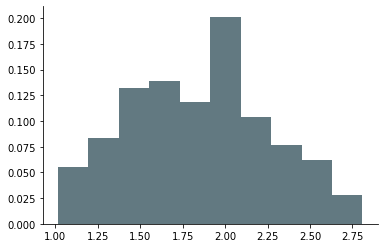

In [11]:
plt.hist(θ_list*1000, weights=πa[:,-1,-1])
plt.hist(θ_list*1000, weights=πa_o[:, 0, 0], alpha=0.3)

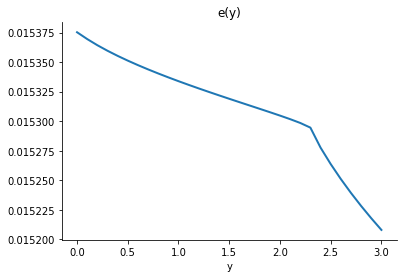

In [12]:
plt.plot(y_grid, ems[:, 0])
plt.xlabel('y')
plt.title('e(y)')
# plt.savefig('emission.png')
plt.show()

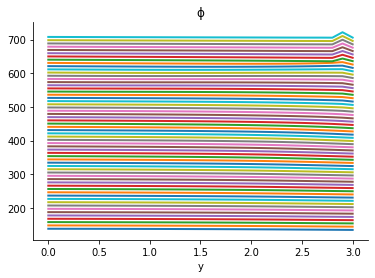

In [13]:
plt.plot(y_grid, v0[:, -60:])
plt.xlabel('y')
plt.title('ϕ')
# plt.savefig('emission.png')
plt.show()

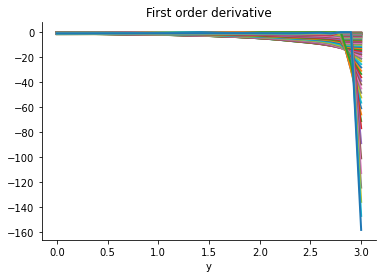

In [14]:
plt.plot(y_grid, v0_dy)
plt.title('First order derivative')
plt.xlabel('y')
# plt.savefig('1stderi.png')
plt.show()

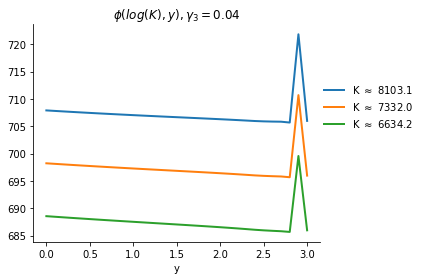

In [15]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
# plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
# plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.plot(y_grid, v0[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])),)
plt.plot(y_grid, v0[:, -2], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-2])), )
plt.plot(y_grid, v0[:, -3], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-3])), )
plt.legend(loc=(1, 0.5))
plt.title(r'$\phi(log(K), y), \gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
plt.tight_layout()
# plt.savefig('v.png', dpi=300)
plt.show()

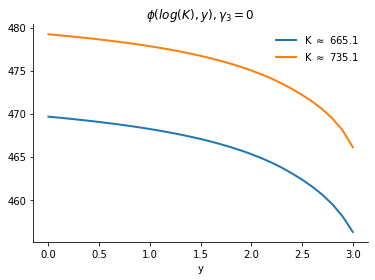

In [16]:
plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

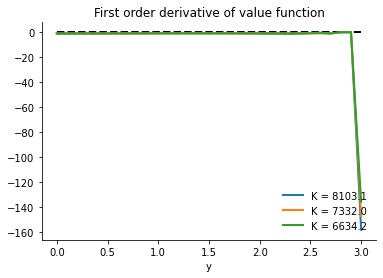

In [17]:
plt.plot(y_grid, v0_dy[:,-1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.plot(y_grid, v0_dy[:,-2], label="K = {:.1f}".format(np.exp(k_grid[-2])))
plt.plot(y_grid, v0_dy[:,-3], label="K = {:.1f}".format(np.exp(k_grid[-3])))
plt.hlines(0, 0, 3, linestyle='dashed', color="black")
plt.legend(loc=4)
plt.title('First order derivative of value function')
plt.xlabel('y')
# plt.savefig('firstoder.png', dpi=300)
plt.show()

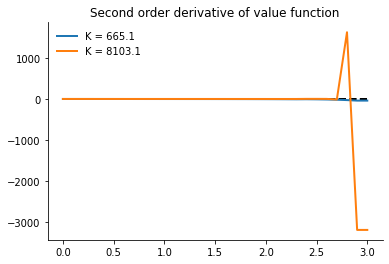

In [18]:
plt.plot(y_grid, v0_dyy[:,loc1], label="K = {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0_dyy[:, -1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.hlines(0, 0, 3, linestyle='dashed', color="black")
plt.legend()
plt.title('Second order derivative of value function')
# plt.savefig('secondorder.png', dpi=300)
plt.show()

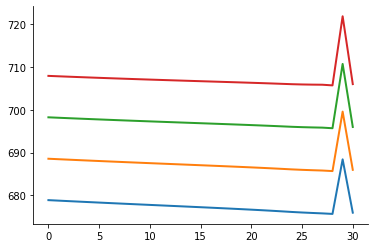

In [19]:
plt.plot(v0[:, -4:])
plt.show()

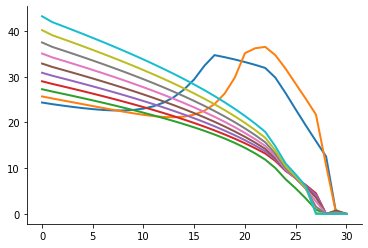

In [20]:
plt.plot(ems[:, -10:])
plt.show()

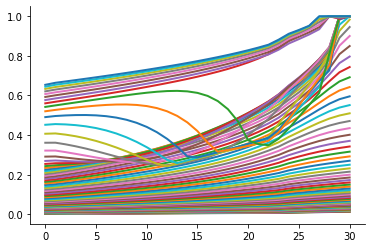

In [21]:
plt.plot(1 -  ems_new/(α*λ_bar*np.exp(k_mat)))
plt.show()

Text(0.5, 0, 'y')

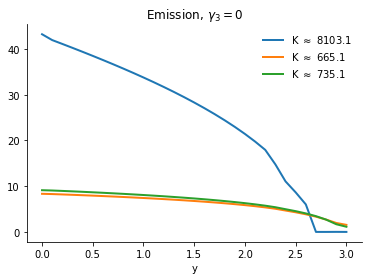

In [22]:
# plt.plot(y_grid, ems[:, -1])
# plt.plot(y_grid, ems[:, 0], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[0])))
plt.plot(y_grid, ems[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.plot(y_grid, ems[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'Emission, $\gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('emission_2.png', dpi=300)
# plt.ylim(0,12)

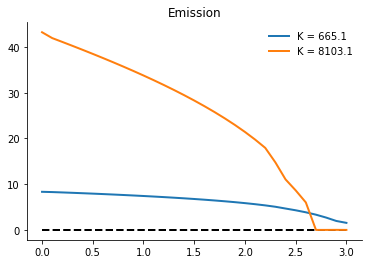

In [23]:
plt.plot(y_grid, ems[:,loc1], label="K = {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, -1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.hlines(0, 0, 3, linestyle='dashed', color="black")
plt.legend()
plt.title('Emission')
# plt.savefig('emission.png', dpi=300)
plt.show()

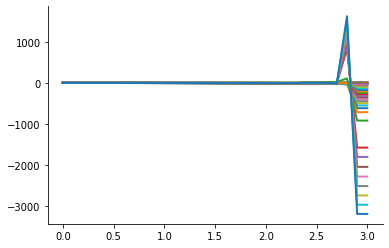

In [24]:
plt.plot(y_grid, v0_dyy)
plt.show()

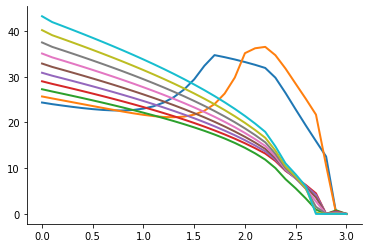

In [25]:
plt.plot(y_grid, ems[:, -10:])
plt.show()

In [26]:
y_grid[-10], y_mat.shape

(2.1, (31, 91))

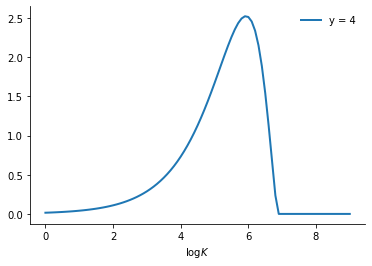

In [27]:
plt.plot(k_grid, ems[-1], label="y = 4")
plt.xlabel("$\log K$")
plt.legend()
# plt.savefig('e_logk.png')

In [28]:
y_grid[25]

2.5

Text(0.5, 1.0, 'Emission, $\\gamma_3 = 0.04$')

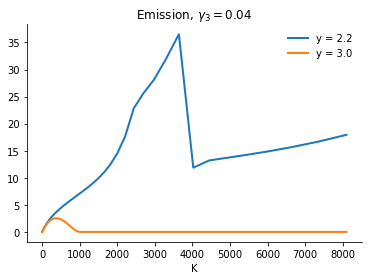

In [29]:
loc = np.abs(y_grid  - 2.2).argmin()
plt.plot(np.exp(k_grid), ems[loc], label = "y = {}".format(y_grid[loc]))
loc = np.abs(y_grid  - 4).argmin()
plt.plot(np.exp(k_grid), ems[loc], label = "y = {}".format(y_grid[loc]))
plt.legend()
plt.xlabel('K')
plt.title('Emission, $\gamma_3 = {:.2f}$'.format(γ3))
# plt.savefig('emission_k.png', dpi=300)

Text(0.5, 1.0, 'Emission')

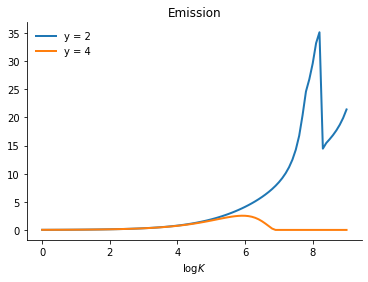

In [30]:
loc = np.abs(y_grid  - 2).argmin()
plt.plot(k_grid, ems[loc], label = "y = 2")
loc = np.abs(y_grid  - 4).argmin()
plt.plot(k_grid, ems[loc], label = "y = 4")
plt.legend()
plt.xlabel('$\log K$')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 0, 'y')

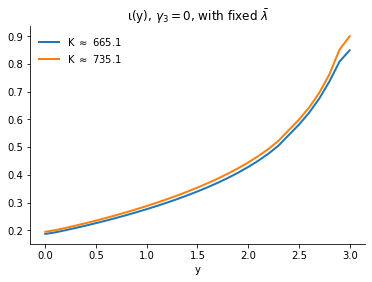

In [31]:
iota = 1 - ems/np.exp(k_mat)/α/λ_bar
plt.plot(y_grid, iota[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, iota[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'ι(y), $\gamma_3 = 0$, with fixed $\bar \lambda$')
plt.xlabel('y')
# plt.savefig('iota_01.png', dpi=300)

Text(0.5, 0, 'y')

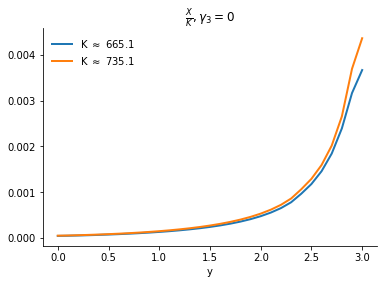

In [32]:
ra = α*ϑ_bar*iota**θ
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{X}{K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('XK_new.png', dpi=300)

Text(0.5, 0, 'y')

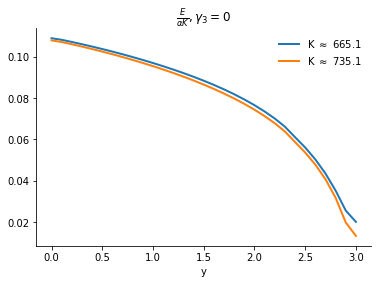

In [33]:
ra = ems/np.exp(k_mat)/α
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{E}{\alpha K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ratio_01.png', dpi=300)

Text(0.5, 0, 'y')

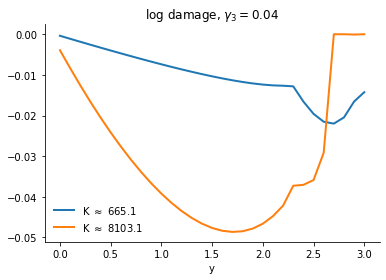

In [34]:
logn_drift = vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2)
plt.plot(y_grid, logn_drift[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, logn_drift[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.legend()
plt.title(r'log damage, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('logn.png', dpi=300)

Text(0.5, 0, 'y')

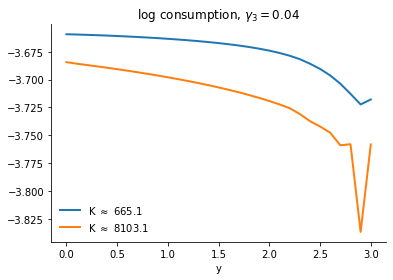

In [35]:
plt.plot(y_grid, np.log(consumption[:, loc1]), label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, np.log(consumption[:, -1]), label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.legend()
plt.title(r'log consumption, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('logC.png', dpi=300)

In [36]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [37]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_new, args_list)
    return res_list        

In [38]:
γ3_list.shape, y_bar

((10,), 2.3)

# Testing parameters


## 1. $(\theta, \lambda, \vartheta) = (3, 0.134, 0.052)$

In [ ]:
args_list = []

θ=3
ξa=0.01
ϑ_bar=0.052
λ_bar=0.134

y_bar = 2.3

for γ3_i in γ3_list:
    args_func = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3_i, y_bar, ξa, ϑ_bar, λ_bar)
    args_iter = (y_grid, k_grid, args_func, 0.1, 10_000, 1e-5)
    args_list.append(args_iter)

res_list = ode_y_parallel(args_list)

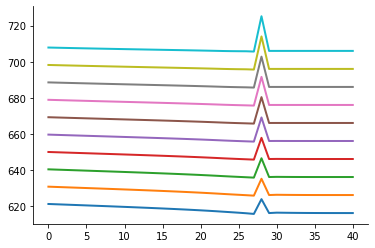

In [171]:
plt.plot(res_list[1]['v0'][:,-10:])
plt.show()

## 2. $(\theta, \lambda, \vartheta) = (3, 0.102, 0.036)$

In [111]:
# args_list_2 = []

# θ=3
# ξa=0.01
# ϑ_bar=0.036
# λ_bar=0.102

# for γ3_i in γ3_two:
#     args_func = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3_i, y_bar, ξa, ϑ_bar, λ_bar)
#     args_iter = (y_grid, k_grid, args_func, 0.5, 4_000, 1e-7)
#     args_list_2.append(args_iter)

# res_list_2 = ode_y_parallel(args_list_2)
# res_two_damage.append(res_list_2)

## 3. $(\theta, \lambda, \vartheta) = (3, 0.0925, 0.032)$

In [112]:
# args_list_3 = []

# θ=3
# ξa=0.01
# ϑ_bar=0.032
# λ_bar=0.0925

# for γ3_i in γ3_two:
#     args_func = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3_i, y_bar, ξa, ϑ_bar, λ_bar)
#     args_iter = (y_grid, k_grid, args_func, 0.5, 4_000, 1e-7)
#     args_list_3.append(args_iter)

# res_list_3 = ode_y_parallel(args_list_3)
# res_two_damage.append(res_list_3)

In [113]:
pickle.dump(res_list, open('../data/res_10', 'wb'))

In [114]:
# res_list_1 =  pickle.load(open("../data/reslist1.p", "rb"))
# res_list_2 =  pickle.load(open("../data/reslist2.p", "rb"))
# res_list_3 =  pickle.load(open("../data/reslist3.p", "rb"))
# res_list_4 =  pickle.load(open("../data/reslist4.p", "rb"))
# res_list_5 =  pickle.load(open("../data/reslist5.p", "rb"))
# res_list_6 =  pickle.load(open("../data/reslist6.p", "rb"))
# res_two_damage =  pickle.load(open("../data/res_two_damage", "rb"))

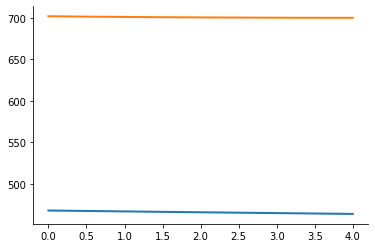

In [117]:
loc = np.abs(np.exp(k_grid) - 700).argmin()
plt.plot(y_grid, res_list[0]['v0'][:,loc])
plt.plot(y_grid, res_list[0]['v0'][:,-1])
plt.show()

In [172]:
v_list = np.zeros((len(res_list), n_y, n_k))
ems_list = np.zeros((len(res_list), n_y, n_k))
for i in range(len(res_list)):
    v_list[i] = res_list[i]['v0']    
    ems_list[i] = res_list[i]['ems']

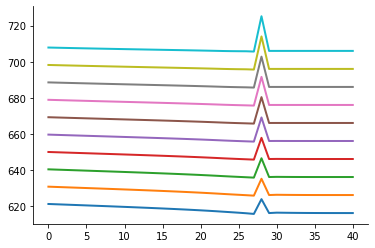

In [175]:
plt.plot(v_list[1][:, -10:])
plt.show()

In [176]:
# solve pre jump
y_grid_cap = y_grid[y_grid <= 2.2]
n_y = len(y_grid_cap)
n_k = len(k_grid)
dy = y_grid_cap[1] - y_grid_cap[0]
dk = k_grid[1] - k_grid[0]
(y_mat_cap, k_mat_cap) = np.meshgrid(y_grid_cap, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat_cap.reshape(-1,1, order='F'), k_mat_cap.reshape(-1,1,order='F')])


πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

πd_o = np.zeros((len(γ3_list), n_y, n_k))
for i in range(len(γ3_list)):
    πd_o[i] = dmg_weight[i]

dΛ = γ1 + γ2*y_mat_cap 
ddΛ = γ2 

ξp = 5
ξa = 0.01
ξw = 100_000

numy_bar = len(y_grid_cap) - 1

r1=1.5
r2=2.5

y_lower = 1.8
intensity = r1*(np.exp(r2/2*(y_mat_cap- y_lower)**2)-1)*(y_mat_cap >= y_lower)


ϕ = np.average(v_list, axis=0, weights=dmg_weight)[:numy_bar+1]
ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
ems = 0*np.ones(y_mat_cap.shape)
# initial i
a_i = κ*ϕ_dk
b_i = - (1 + α*κ)*ϕ_dk
c_i = α*ϕ_dk - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat_cap)*α*λ_bar))**θ )

episode = 0
lhs_error = 1
πᵈo = dmg_weight

v_average = np.average(np.exp(-1/ξp*v_list), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(v_average)

ϕ = ϕ_bound[:numy_bar+1]

tol= 1e-7
ϵ = 0.1
max_iter = 4000
vd = -1/δ

while lhs_error > tol: # and episode < max_iter:
    ϕ_old = ϕ.copy()
    ϕ_dy = derivatives_2d(ϕ, 0, 1, dy)
    ϕ_dyy = derivatives_2d(ϕ, 0, 2, dy)
    ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
    ϕ_dkk = derivatives_2d(ϕ, 1, 2, dk)
    # update control
    # updating controls
    i_new = (1 -mc/ϕ_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = ϕ_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + ϕ_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = - b/a
    elif θ == 3:
        a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))/(α**2*λ_bar**2*np.exp(2*k_mat_cap))
        b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))*2/(α*λ_bar*np.exp(k_mat_cap)) + (ϕ_dyy+ vd*ddΛ)*σy**2 
        c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap)) + (ϕ_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    ems_new[ems_new < 0] = 0
    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap))) > 0 )
#     ratio[ratio > 1] = 1
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[consumption < 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = ϕ_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    ϕ_ref = np.zeros((len(γ3_list), n_y, n_k))
    for i in range(len(γ3_list)):
        ϕ_ref[i] = v_list[i, numy_bar]
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref))
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat_cap.shape) - intensity*np.sum(πd_o*g_list, axis=0)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat_cap.shape)
    D = np.log(consumption) + k_mat_cap + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy + ξp*intensity * np.sum(πd_o*(1 - g_list + g_list*np.log(g_list)), axis=0)\
        + intensity*np.sum(πd_o*(g_list*ϕ_ref), axis=0)
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, ϕ, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(ϕ.shape,order = "F")
    rhs = A*ϕ + B_y*ϕ_dy + B_k*ϕ_dk + C_yy*ϕ_dyy + C_kk*ϕ_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - ϕ)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    ϕ = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

solution = dict(ϕ=ϕ, ems=ems, g_list=g_list)

min ems: 0.0007649170599215555
min mc 46.523037524440824
Episode 0: PDE Error: 0.316659962256; ft Error: 0.311677802935; Iterations: 3; CG Error: 0.000000000079
min ems: 0.0014913607763635444
min mc 44.10957049303022
Episode 1: PDE Error: 0.280368705262; ft Error: 0.276051754546; Iterations: 3; CG Error: 0.000000000088
min ems: 0.00218133912969178
min mc 42.4449274849915
Episode 2: PDE Error: 0.251948268882; ft Error: 0.248049189188; Iterations: 3; CG Error: 0.000000000097
min ems: 0.002836729629733339
min mc 41.26212459994432
Episode 3: PDE Error: 0.228698314627; ft Error: 0.225041900384; Iterations: 4; CG Error: 0.000000000003
min ems: 0.003459299191841457
min mc 40.405929319269475
Episode 4: PDE Error: 0.209088616706; ft Error: 0.205690486222; Iterations: 4; CG Error: 0.000000000004
min ems: 0.00405071585945562
min mc 39.779894699818584
Episode 5: PDE Error: 0.192351007823; ft Error: 0.188941043340; Iterations: 4; CG Error: 0.000000000005
min ems: 0.004612557122020536
min mc 39.3198

Episode 65: PDE Error: 0.065600157514; ft Error: 0.044284427829; Iterations: 4; CG Error: 0.000000000070
min ems: 0.014803546869550231
min mc 38.617352442869574
Episode 66: PDE Error: 0.065117988109; ft Error: 0.044018028350; Iterations: 4; CG Error: 0.000000000070
min ems: 0.014828197758266144
min mc 38.61786815742624
Episode 67: PDE Error: 0.064639293298; ft Error: 0.043801578529; Iterations: 4; CG Error: 0.000000000070
min ems: 0.014851618263684892
min mc 38.61834691680023
Episode 68: PDE Error: 0.064164032481; ft Error: 0.043581097925; Iterations: 4; CG Error: 0.000000000070
min ems: 0.014873869874864649
min mc 38.61879214894987
Episode 69: PDE Error: 0.063692171519; ft Error: 0.043356730483; Iterations: 4; CG Error: 0.000000000070
min ems: 0.01489501100692198
min mc 38.61920693807623
Episode 70: PDE Error: 0.063223681823; ft Error: 0.043128621375; Iterations: 4; CG Error: 0.000000000069
min ems: 0.014915097154704987
min mc 38.61959405930794
Episode 71: PDE Error: 0.062758539545; f

min ems: 0.015276801342767918
min mc 38.62693950204913
Episode 131: PDE Error: 0.041870881611; ft Error: 0.029942970109; Iterations: 4; CG Error: 0.000000000062
min ems: 0.015277639298491111
min mc 38.62697197182874
Episode 132: PDE Error: 0.041737268081; ft Error: 0.029768375938; Iterations: 4; CG Error: 0.000000000062
min ems: 0.015278433308445865
min mc 38.62700320470789
Episode 133: PDE Error: 0.041602498198; ft Error: 0.029593746812; Iterations: 4; CG Error: 0.000000000061
min ems: 0.015279185566476543
min mc 38.62703323233798
Episode 134: PDE Error: 0.041470121958; ft Error: 0.029419101859; Iterations: 4; CG Error: 0.000000000061
min ems: 0.015279898156766673
min mc 38.627062085674275
Episode 135: PDE Error: 0.041347976362; ft Error: 0.029244459802; Iterations: 4; CG Error: 0.000000000061
min ems: 0.015280573059321807
min mc 38.627089795006746
Episode 136: PDE Error: 0.041224733267; ft Error: 0.029069838972; Iterations: 4; CG Error: 0.000000000061
min ems: 0.015281212155178362
mi

Episode 194: PDE Error: 0.033679695610; ft Error: 0.022267997006; Iterations: 4; CG Error: 0.000000000042
min ems: 0.015291032842481478
min mc 38.62751666022442
Episode 195: PDE Error: 0.033552882788; ft Error: 0.022197402154; Iterations: 4; CG Error: 0.000000000042
min ems: 0.015291022435498727
min mc 38.627513503846856
Episode 196: PDE Error: 0.033426015891; ft Error: 0.022125926278; Iterations: 4; CG Error: 0.000000000041
min ems: 0.015291010338457004
min mc 38.62751023198409
Episode 197: PDE Error: 0.033299108015; ft Error: 0.022053585724; Iterations: 4; CG Error: 0.000000000041
min ems: 0.015290996634172
min mc 38.62750685171113
Episode 198: PDE Error: 0.033172172118; ft Error: 0.021980396740; Iterations: 4; CG Error: 0.000000000040
min ems: 0.015290981401342166
min mc 38.62750336988325
Episode 199: PDE Error: 0.033045221020; ft Error: 0.021906375466; Iterations: 4; CG Error: 0.000000000040
min ems: 0.015290964714754551
min mc 38.62749979314069
Episode 200: PDE Error: 0.0329182674

min ems: 0.015288868738575864
min mc 38.62727034148063
Episode 258: PDE Error: 0.028808208073; ft Error: 0.018158438987; Iterations: 4; CG Error: 0.000000000040
min ems: 0.015288824854050352
min mc 38.62726731416352
Episode 259: PDE Error: 0.028805169267; ft Error: 0.018107540344; Iterations: 4; CG Error: 0.000000000041
min ems: 0.015288780888543043
min mc 38.627264336011045
Episode 260: PDE Error: 0.028802240878; ft Error: 0.018056213389; Iterations: 4; CG Error: 0.000000000041
min ems: 0.015288736845684422
min mc 38.62726140702843
Episode 261: PDE Error: 0.028799422653; ft Error: 0.018004464756; Iterations: 4; CG Error: 0.000000000041
min ems: 0.015288692728940859
min mc 38.627258527186825
Episode 262: PDE Error: 0.028796714128; ft Error: 0.017952301059; Iterations: 4; CG Error: 0.000000000041
min ems: 0.015288648541622726
min mc 38.62725569642487
Episode 263: PDE Error: 0.028794114644; ft Error: 0.017899728877; Iterations: 4; CG Error: 0.000000000042
min ems: 0.015288604286892089
mi

min ems: 0.015286029985362428
min mc 38.62716349353282
Episode 321: PDE Error: 0.028764521044; ft Error: 0.014992940824; Iterations: 4; CG Error: 0.000000000031
min ems: 0.015285984521594412
min mc 38.62716285736872
Episode 322: PDE Error: 0.028764905589; ft Error: 0.014944599164; Iterations: 4; CG Error: 0.000000000031
min ems: 0.015285939059953495
min mc 38.627162243176436
Episode 323: PDE Error: 0.028765290148; ft Error: 0.014896100914; Iterations: 4; CG Error: 0.000000000031
min ems: 0.015285893600843134
min mc 38.62716165047774
Episode 324: PDE Error: 0.028765673941; ft Error: 0.014856538305; Iterations: 4; CG Error: 0.000000000031
min ems: 0.01528584814465888
min mc 38.627161078799894
Episode 325: PDE Error: 0.028766056233; ft Error: 0.014816742533; Iterations: 4; CG Error: 0.000000000030
min ems: 0.0152858026917886
min mc 38.62716052767556
Episode 326: PDE Error: 0.028766436333; ft Error: 0.014776716904; Iterations: 4; CG Error: 0.000000000030
min ems: 0.015285757242612892
min m

min ems: 0.01528313787402814
min mc 38.627150820866525
Episode 385: PDE Error: 0.028776898066; ft Error: 0.012958800709; Iterations: 3; CG Error: 0.000000000065
min ems: 0.015283093147499814
min mc 38.62715086715495
Episode 386: PDE Error: 0.028776898862; ft Error: 0.012935291051; Iterations: 3; CG Error: 0.000000000064
min ems: 0.015283048440335189
min mc 38.62715091626843
Episode 387: PDE Error: 0.028776896912; ft Error: 0.012911454166; Iterations: 3; CG Error: 0.000000000063
min ems: 0.015283003752744906
min mc 38.62715096807019
Episode 388: PDE Error: 0.028776892376; ft Error: 0.012887292953; Iterations: 3; CG Error: 0.000000000062
min ems: 0.01528295908493709
min mc 38.62715102242724
Episode 389: PDE Error: 0.028776885408; ft Error: 0.012862810318; Iterations: 3; CG Error: 0.000000000061
min ems: 0.015282914437117483
min mc 38.627151079210144
Episode 390: PDE Error: 0.028776876158; ft Error: 0.012838009179; Iterations: 3; CG Error: 0.000000000059
min ems: 0.015282869809489497
min 

Episode 449: PDE Error: 0.028775568557; ft Error: 0.011350594330; Iterations: 3; CG Error: 0.000000000019
min ems: 0.015280278881986013
min mc 38.62715575693564
Episode 450: PDE Error: 0.028775558637; ft Error: 0.011327853930; Iterations: 3; CG Error: 0.000000000019
min ems: 0.01528023577691193
min mc 38.62715582516117
Episode 451: PDE Error: 0.028775549258; ft Error: 0.011304891859; Iterations: 3; CG Error: 0.000000000019
min ems: 0.015280192701643297
min mc 38.627155892577626
Episode 452: PDE Error: 0.028775540409; ft Error: 0.011281710158; Iterations: 3; CG Error: 0.000000000018
min ems: 0.015280149656305697
min mc 38.627155959178694
Episode 453: PDE Error: 0.028775532078; ft Error: 0.011258310869; Iterations: 3; CG Error: 0.000000000018
min ems: 0.015280106641023904
min mc 38.62715602495893
Episode 454: PDE Error: 0.028775524250; ft Error: 0.011234696046; Iterations: 3; CG Error: 0.000000000018
min ems: 0.015280063655921881
min mc 38.62715608991351
Episode 455: PDE Error: 0.0287755

Episode 513: PDE Error: 0.028775504430; ft Error: 0.009975063359; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015277585004195245
min mc 38.62715853220064
Episode 514: PDE Error: 0.028775506044; ft Error: 0.009954976255; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015277544029365063
min mc 38.6271585536514
Episode 515: PDE Error: 0.028775507623; ft Error: 0.009934729437; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015277503090944049
min mc 38.627158574595164
Episode 516: PDE Error: 0.028775509165; ft Error: 0.009914324344; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015277462189014705
min mc 38.62715859504004
Episode 517: PDE Error: 0.028775510669; ft Error: 0.009893762413; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015277421323658912
min mc 38.627158614994165
Episode 518: PDE Error: 0.028775512135; ft Error: 0.009873045088; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015277380494958056
min mc 38.62715863446555
Episode 519: PDE Error: 0.0287755

min ems: 0.01527503910830292
min mc 38.62715918089829
Episode 578: PDE Error: 0.028775539473; ft Error: 0.008796617683; Iterations: 3; CG Error: 0.000000000004
min ems: 0.015275000607711356
min mc 38.627159183499685
Episode 579: PDE Error: 0.028775539380; ft Error: 0.008779581861; Iterations: 3; CG Error: 0.000000000004
min ems: 0.015274962147759058
min mc 38.62715918597261
Episode 580: PDE Error: 0.028775539284; ft Error: 0.008762425126; Iterations: 3; CG Error: 0.000000000004
min ems: 0.015274923728496929
min mc 38.627159188320675
Episode 581: PDE Error: 0.028775539185; ft Error: 0.008745148498; Iterations: 3; CG Error: 0.000000000004
min ems: 0.015274885349975424
min mc 38.62715919054716
Episode 582: PDE Error: 0.028775539083; ft Error: 0.008727753003; Iterations: 3; CG Error: 0.000000000004
min ems: 0.015274847012244588
min mc 38.62715919265533
Episode 583: PDE Error: 0.028775538979; ft Error: 0.008710239662; Iterations: 3; CG Error: 0.000000000004
min ems: 0.015274808715354068
min

Episode 642: PDE Error: 0.028775535203; ft Error: 0.007883219358; Iterations: 2; CG Error: 0.000000000073
min ems: 0.015272624664671297
min mc 38.62715919542575
Episode 643: PDE Error: 0.028775535197; ft Error: 0.007871935327; Iterations: 2; CG Error: 0.000000000073
min ems: 0.015272588921347842
min mc 38.62715919447945
Episode 644: PDE Error: 0.028775535191; ft Error: 0.007860508592; Iterations: 2; CG Error: 0.000000000073
min ems: 0.015272553220667237
min mc 38.62715919352347
Episode 645: PDE Error: 0.028775535187; ft Error: 0.007848940047; Iterations: 2; CG Error: 0.000000000072
min ems: 0.015272517562658353
min mc 38.627159192558516
Episode 646: PDE Error: 0.028775535184; ft Error: 0.007837230593; Iterations: 2; CG Error: 0.000000000072
min ems: 0.015272481947350309
min mc 38.6271591915853
Episode 647: PDE Error: 0.028775535182; ft Error: 0.007825381134; Iterations: 2; CG Error: 0.000000000071
min ems: 0.0152724463747725
min mc 38.62715919060441
Episode 648: PDE Error: 0.0287755351

min ems: 0.015270424259384088
min mc 38.62715913383345
Episode 707: PDE Error: 0.028775535475; ft Error: 0.007084884111; Iterations: 2; CG Error: 0.000000000052
min ems: 0.015270391301322671
min mc 38.627159133032215
Episode 708: PDE Error: 0.028775535478; ft Error: 0.007075890998; Iterations: 2; CG Error: 0.000000000052
min ems: 0.015270358387534813
min mc 38.62715913223853
Episode 709: PDE Error: 0.028775535480; ft Error: 0.007066781138; Iterations: 2; CG Error: 0.000000000052
min ems: 0.015270325518037647
min mc 38.627159131452444
Episode 710: PDE Error: 0.028775535482; ft Error: 0.007057555172; Iterations: 2; CG Error: 0.000000000051
min ems: 0.015270292692848058
min mc 38.62715913067391
Episode 711: PDE Error: 0.028775535484; ft Error: 0.007048213744; Iterations: 2; CG Error: 0.000000000051
min ems: 0.015270259911982647
min mc 38.62715912990298
Episode 712: PDE Error: 0.028775535486; ft Error: 0.007038757502; Iterations: 2; CG Error: 0.000000000051
min ems: 0.01527022717545774
min

Episode 771: PDE Error: 0.028775535495; ft Error: 0.006421284375; Iterations: 2; CG Error: 0.000000000039
min ems: 0.015268374658150652
min mc 38.627159096828
Episode 772: PDE Error: 0.028775535494; ft Error: 0.006410321291; Iterations: 2; CG Error: 0.000000000039
min ems: 0.015268344603184525
min mc 38.627159096470095
Episode 773: PDE Error: 0.028775535494; ft Error: 0.006399270305; Iterations: 2; CG Error: 0.000000000039
min ems: 0.015268314593137395
min mc 38.627159096117445
Episode 774: PDE Error: 0.028775535494; ft Error: 0.006388132054; Iterations: 2; CG Error: 0.000000000039
min ems: 0.015268284628013162
min mc 38.627159095769876
Episode 775: PDE Error: 0.028775535494; ft Error: 0.006376907177; Iterations: 2; CG Error: 0.000000000038
min ems: 0.01526825470781562
min mc 38.627159095427515
Episode 776: PDE Error: 0.028775535494; ft Error: 0.006365596316; Iterations: 2; CG Error: 0.000000000038
min ems: 0.015268224832548393
min mc 38.62715909509025
Episode 777: PDE Error: 0.0287755

min ems: 0.015266541779070006
min mc 38.62715908232302
Episode 836: PDE Error: 0.028775535494; ft Error: 0.005814702618; Iterations: 2; CG Error: 0.000000000030
min ems: 0.015266514601661799
min mc 38.62715908219922
Episode 837: PDE Error: 0.028775535494; ft Error: 0.005806255979; Iterations: 2; CG Error: 0.000000000030
min ems: 0.015266487469186626
min mc 38.62715908207774
Episode 838: PDE Error: 0.028775535494; ft Error: 0.005797732942; Iterations: 2; CG Error: 0.000000000030
min ems: 0.015266460381641669
min mc 38.6271590819585
Episode 839: PDE Error: 0.028775535494; ft Error: 0.005789133969; Iterations: 2; CG Error: 0.000000000030
min ems: 0.015266433339023992
min mc 38.627159081841434
Episode 840: PDE Error: 0.028775535494; ft Error: 0.005780459524; Iterations: 2; CG Error: 0.000000000030
min ems: 0.01526640634133064
min mc 38.6271590817265
Episode 841: PDE Error: 0.028775535494; ft Error: 0.005771710070; Iterations: 2; CG Error: 0.000000000030
min ems: 0.015266379388558536
min mc

min ems: 0.015264844275290283
min mc 38.62715907770609
Episode 902: PDE Error: 0.028775535494; ft Error: 0.005254424093; Iterations: 2; CG Error: 0.000000000024
min ems: 0.015264820054537474
min mc 38.62715907767446
Episode 903: PDE Error: 0.028775535494; ft Error: 0.005248089607; Iterations: 2; CG Error: 0.000000000024
min ems: 0.015264795878405315
min mc 38.627159077643626
Episode 904: PDE Error: 0.028775535494; ft Error: 0.005241688547; Iterations: 2; CG Error: 0.000000000024
min ems: 0.015264771746887599
min mc 38.627159077613555
Episode 905: PDE Error: 0.028775535494; ft Error: 0.005235221242; Iterations: 2; CG Error: 0.000000000024
min ems: 0.015264747659978055
min mc 38.627159077584174
Episode 906: PDE Error: 0.028775535494; ft Error: 0.005228688022; Iterations: 2; CG Error: 0.000000000024
min ems: 0.015264723617670407
min mc 38.627159077555476
Episode 907: PDE Error: 0.028775535494; ft Error: 0.005222089223; Iterations: 2; CG Error: 0.000000000024
min ems: 0.015264699619958324


Episode 968: PDE Error: 0.028775535494; ft Error: 0.004782847111; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015263319823352092
min mc 38.62715907669898
Episode 969: PDE Error: 0.028775535494; ft Error: 0.004775552991; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015263298577265012
min mc 38.62715907669454
Episode 970: PDE Error: 0.028775535494; ft Error: 0.004768206654; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015263277375333367
min mc 38.62715907669023
Episode 971: PDE Error: 0.028775535494; ft Error: 0.004760808430; Iterations: 2; CG Error: 0.000000000020
min ems: 0.01526325621754978
min mc 38.62715907668613
Episode 972: PDE Error: 0.028775535494; ft Error: 0.004753358647; Iterations: 2; CG Error: 0.000000000020
min ems: 0.01526323510390684
min mc 38.62715907668215
Episode 973: PDE Error: 0.028775535494; ft Error: 0.004745857638; Iterations: 2; CG Error: 0.000000000020
min ems: 0.015263214034397187
min mc 38.62715907667834
Episode 974: PDE Error: 0.0287755354

min ems: 0.015262011956501231
min mc 38.627159076639906
Episode 1035: PDE Error: 0.028775535494; ft Error: 0.004342053950; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015261993608835383
min mc 38.62715907664088
Episode 1036: PDE Error: 0.028775535494; ft Error: 0.004336577767; Iterations: 2; CG Error: 0.000000000017
min ems: 0.01526197530484078
min mc 38.6271590766419
Episode 1037: PDE Error: 0.028775535494; ft Error: 0.004331054525; Iterations: 2; CG Error: 0.000000000017
min ems: 0.0152619570445103
min mc 38.62715907664295
Episode 1038: PDE Error: 0.028775535494; ft Error: 0.004325484463; Iterations: 2; CG Error: 0.000000000017
min ems: 0.01526193882783687
min mc 38.627159076643984
Episode 1039: PDE Error: 0.028775535494; ft Error: 0.004319867822; Iterations: 2; CG Error: 0.000000000017
min ems: 0.015261920654813407
min mc 38.62715907664505
Episode 1040: PDE Error: 0.028775535494; ft Error: 0.004314204846; Iterations: 2; CG Error: 0.000000000017
min ems: 0.01526190252543284
mi

min ems: 0.01526087889031771
min mc 38.62715907672034
Episode 1102: PDE Error: 0.028775535494; ft Error: 0.003953537512; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015260863453607007
min mc 38.627159076721426
Episode 1103: PDE Error: 0.028775535494; ft Error: 0.003947483581; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015260848060125155
min mc 38.627159076722535
Episode 1104: PDE Error: 0.028775535494; ft Error: 0.003941392430; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015260832709866144
min mc 38.627159076723665
Episode 1105: PDE Error: 0.028775535494; ft Error: 0.003935264294; Iterations: 2; CG Error: 0.000000000015
min ems: 0.01526081740282402
min mc 38.62715907672481
Episode 1106: PDE Error: 0.028775535494; ft Error: 0.003929099411; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015260802138992828
min mc 38.62715907672596
Episode 1107: PDE Error: 0.028775535494; ft Error: 0.003922898015; Iterations: 2; CG Error: 0.000000000015
min ems: 0.0152607869183666

Episode 1168: PDE Error: 0.028775535494; ft Error: 0.003610416339; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015259939938872376
min mc 38.62715907677914
Episode 1169: PDE Error: 0.028775535494; ft Error: 0.003605920642; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015259927386265373
min mc 38.62715907677982
Episode 1170: PDE Error: 0.028775535494; ft Error: 0.003601390241; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015259914876533094
min mc 38.627159076780465
Episode 1171: PDE Error: 0.028775535494; ft Error: 0.003596825308; Iterations: 2; CG Error: 0.000000000013
min ems: 0.01525990240967099
min mc 38.62715907678113
Episode 1172: PDE Error: 0.028775535494; ft Error: 0.003592226019; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015259889985674565
min mc 38.62715907678172
Episode 1173: PDE Error: 0.028775535494; ft Error: 0.003587592549; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015259877604539285
min mc 38.62715907678238
Episode 1174: PDE Error: 0.0

min ems: 0.015259203240330428
min mc 38.627159076806365
Episode 1235: PDE Error: 0.028775535494; ft Error: 0.003297148436; Iterations: 2; CG Error: 0.000000000012
min ems: 0.015259193508662441
min mc 38.62715907680663
Episode 1236: PDE Error: 0.028775535494; ft Error: 0.003292290661; Iterations: 2; CG Error: 0.000000000011
min ems: 0.01525918381961321
min mc 38.62715907680693
Episode 1237: PDE Error: 0.028775535494; ft Error: 0.003287404972; Iterations: 2; CG Error: 0.000000000011
min ems: 0.01525917417317947
min mc 38.627159076807146
Episode 1238: PDE Error: 0.028775535494; ft Error: 0.003282491538; Iterations: 2; CG Error: 0.000000000011
min ems: 0.015259164569357992
min mc 38.627159076807416
Episode 1239: PDE Error: 0.028775535494; ft Error: 0.003277550530; Iterations: 2; CG Error: 0.000000000011
min ems: 0.01525915500814556
min mc 38.62715907680768
Episode 1240: PDE Error: 0.028775535494; ft Error: 0.003272582117; Iterations: 2; CG Error: 0.000000000011
min ems: 0.01525914548953897

min ems: 0.015258645304238606
min mc 38.62715907681737
Episode 1302: PDE Error: 0.028775535494; ft Error: 0.003015138489; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015258638421521586
min mc 38.6271590768175
Episode 1303: PDE Error: 0.028775535494; ft Error: 0.003011522314; Iterations: 2; CG Error: 0.000000000010
min ems: 0.01525863158123493
min mc 38.627159076817584
Episode 1304: PDE Error: 0.028775535494; ft Error: 0.003007879799; Iterations: 2; CG Error: 0.000000000010
min ems: 0.01525862478337613
min mc 38.62715907681763
Episode 1305: PDE Error: 0.028775535494; ft Error: 0.003004211069; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015258618027942724
min mc 38.62715907681767
Episode 1306: PDE Error: 0.028775535494; ft Error: 0.003000516255; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015258611314932202
min mc 38.627159076817726
Episode 1307: PDE Error: 0.028775535494; ft Error: 0.002996795480; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015258604644342113

min ems: 0.0152582819455367
min mc 38.62715907682286
Episode 1368: PDE Error: 0.028775535494; ft Error: 0.002765868878; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015258277857937205
min mc 38.62715907682279
Episode 1369: PDE Error: 0.028775535494; ft Error: 0.002762029695; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015258273812603335
min mc 38.627159076822686
Episode 1370: PDE Error: 0.028775535494; ft Error: 0.002758168865; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015258269809532397
min mc 38.627159076822636
Episode 1371: PDE Error: 0.028775535494; ft Error: 0.002754286512; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015258265848721673
min mc 38.62715907682263
Episode 1372: PDE Error: 0.028775535494; ft Error: 0.002750382758; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015258261930168443
min mc 38.62715907682273
Episode 1373: PDE Error: 0.028775535494; ft Error: 0.002746457728; Iterations: 2; CG Error: 0.000000000009
min ems: 0.01525825805386998

min ems: 0.015258101384171361
min mc 38.62715907682408
Episode 1435: PDE Error: 0.028775535494; ft Error: 0.002532218958; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015258100121580971
min mc 38.62715907682409
Episode 1436: PDE Error: 0.028775535494; ft Error: 0.002529381226; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015258098901033126
min mc 38.62715907682413
Episode 1437: PDE Error: 0.028775535494; ft Error: 0.002526522894; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015258097722523581
min mc 38.62715907682416
Episode 1438: PDE Error: 0.028775535494; ft Error: 0.002523644052; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015258096586048066
min mc 38.627159076824235
Episode 1439: PDE Error: 0.028775535494; ft Error: 0.002520744793; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015258095491602262
min mc 38.62715907682426
Episode 1440: PDE Error: 0.028775535494; ft Error: 0.002517825211; Iterations: 2; CG Error: 0.000000000008
min ems: 0.0152580944391818

Episode 1502: PDE Error: 0.028775535494; ft Error: 0.002327226688; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015258111055412403
min mc 38.62715907682448
Episode 1503: PDE Error: 0.028775535494; ft Error: 0.002324205609; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015258112639957475
min mc 38.62715907682456
Episode 1504: PDE Error: 0.028775535494; ft Error: 0.002321167429; Iterations: 2; CG Error: 0.000000000007
min ems: 0.01525811426615622
min mc 38.62715907682465
Episode 1505: PDE Error: 0.028775535494; ft Error: 0.002318112239; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015258115934001061
min mc 38.62715907682469
Episode 1506: PDE Error: 0.028775535494; ft Error: 0.002315040130; Iterations: 2; CG Error: 0.000000000007
min ems: 0.0152581176434844
min mc 38.62715907682473
Episode 1507: PDE Error: 0.028775535494; ft Error: 0.002311951192; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015258119394598537
min mc 38.62715907682471
Episode 1508: PDE Error: 0.0287

min ems: 0.015258308901195101
min mc 38.627159076824235
Episode 1570: PDE Error: 0.028775535494; ft Error: 0.002129798462; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015258313256443959
min mc 38.627159076824235
Episode 1571: PDE Error: 0.028775535494; ft Error: 0.002126845047; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015258317652678363
min mc 38.62715907682421
Episode 1572: PDE Error: 0.028775535494; ft Error: 0.002124596391; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015258322089885522
min mc 38.62715907682421
Episode 1573: PDE Error: 0.028775535494; ft Error: 0.002122331534; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015258326568052503
min mc 38.62715907682426
Episode 1574: PDE Error: 0.028775535494; ft Error: 0.002120050544; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015258331087166324
min mc 38.62715907682433
Episode 1575: PDE Error: 0.028775535494; ft Error: 0.002117753490; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015258335647213

Episode 1637: PDE Error: 0.028775535494; ft Error: 0.001962109296; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015258697699711856
min mc 38.627159076824235
Episode 1638: PDE Error: 0.028775535494; ft Error: 0.001959735518; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015258704807697424
min mc 38.62715907682424
Episode 1639: PDE Error: 0.028775535494; ft Error: 0.001957348062; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015258711955559362
min mc 38.62715907682424
Episode 1640: PDE Error: 0.028775535494; ft Error: 0.001954946997; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015258719143277371
min mc 38.62715907682424
Episode 1641: PDE Error: 0.028775535494; ft Error: 0.001952532388; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015258726370831036
min mc 38.62715907682425
Episode 1642: PDE Error: 0.028775535494; ft Error: 0.001950104304; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015258733638199818
min mc 38.62715907682425
Episode 1643: PDE Error: 0.

Episode 1704: PDE Error: 0.028775535494; ft Error: 0.001803705812; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015259261028085575
min mc 38.627159076824256
Episode 1705: PDE Error: 0.028775535494; ft Error: 0.001801252293; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015259270756521401
min mc 38.62715907682424
Episode 1706: PDE Error: 0.028775535494; ft Error: 0.001798787416; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015259280523172967
min mc 38.62715907682422
Episode 1707: PDE Error: 0.028775535494; ft Error: 0.001796311243; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015259290328010483
min mc 38.62715907682426
Episode 1708: PDE Error: 0.028775535494; ft Error: 0.001793823841; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015259300171004086
min mc 38.62715907682432
Episode 1709: PDE Error: 0.028775535494; ft Error: 0.001791325273; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015259310052123682
min mc 38.62715907682435
Episode 1710: PDE Error: 0.

min ems: 0.015259995779707287
min mc 38.627159076823716
Episode 1772: PDE Error: 0.028775535494; ft Error: 0.001658279043; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260007995049278
min mc 38.627159076823716
Episode 1773: PDE Error: 0.028775535494; ft Error: 0.001656424104; Iterations: 2; CG Error: 0.000000000004
min ems: 0.0152600202462506
min mc 38.62715907682372
Episode 1774: PDE Error: 0.028775535494; ft Error: 0.001654558088; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260032533270237
min mc 38.6271590768238
Episode 1775: PDE Error: 0.028775535494; ft Error: 0.001652681045; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260044856066968
min mc 38.627159076823844
Episode 1776: PDE Error: 0.028775535494; ft Error: 0.001650793024; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01526005721459944
min mc 38.62715907682389
Episode 1777: PDE Error: 0.028775535494; ft Error: 0.001648894076; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01526006960882607


min ems: 0.015260891387283343
min mc 38.62715907682374
Episode 1839: PDE Error: 0.028775535494; ft Error: 0.001528607262; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260905905701824
min mc 38.627159076823716
Episode 1840: PDE Error: 0.028775535494; ft Error: 0.001526683585; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260920456822202
min mc 38.62715907682371
Episode 1841: PDE Error: 0.028775535494; ft Error: 0.001524750591; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260935040590905
min mc 38.6271590768237
Episode 1842: PDE Error: 0.028775535494; ft Error: 0.001522808326; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260949656954178
min mc 38.62715907682374
Episode 1843: PDE Error: 0.028775535494; ft Error: 0.001520856839; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015260964305858054
min mc 38.62715907682376
Episode 1844: PDE Error: 0.028775535494; ft Error: 0.001518896178; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01526097898724838

Episode 1906: PDE Error: 0.028775535494; ft Error: 0.001406125848; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015261950291556841
min mc 38.62715907682344
Episode 1907: PDE Error: 0.028775535494; ft Error: 0.001404171251; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015261966901919806
min mc 38.62715907682348
Episode 1908: PDE Error: 0.028775535494; ft Error: 0.001402406808; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015261983540898402
min mc 38.62715907682348
Episode 1909: PDE Error: 0.028775535494; ft Error: 0.001400955082; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015262000208425826
min mc 38.62715907682348
Episode 1910: PDE Error: 0.028775535494; ft Error: 0.001399494343; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015262016904435065
min mc 38.627159076823474
Episode 1911: PDE Error: 0.028775535494; ft Error: 0.001398024629; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015262033628858931
min mc 38.627159076823474
Episode 1912: PDE Error: 0

min ems: 0.015263123108103866
min mc 38.627159076823446
Episode 1974: PDE Error: 0.028775535494; ft Error: 0.001297333151; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015263141478878516
min mc 38.62715907682347
Episode 1975: PDE Error: 0.028775535494; ft Error: 0.001295829360; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015263159873374352
min mc 38.62715907682349
Episode 1976: PDE Error: 0.028775535494; ft Error: 0.001294317870; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015263178291512108
min mc 38.62715907682351
Episode 1977: PDE Error: 0.028775535494; ft Error: 0.001292798717; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015263196733212305
min mc 38.62715907682349
Episode 1978: PDE Error: 0.028775535494; ft Error: 0.001291271938; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015263215198395288
min mc 38.62715907682349
Episode 1979: PDE Error: 0.028775535494; ft Error: 0.001289737568; Iterations: 2; CG Error: 0.000000000003
min ems: 0.0152632336869812

Episode 2041: PDE Error: 0.028775535494; ft Error: 0.001196500107; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015264422244740101
min mc 38.62715907682419
Episode 2042: PDE Error: 0.028775535494; ft Error: 0.001194964387; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015264442039451164
min mc 38.62715907682419
Episode 2043: PDE Error: 0.028775535494; ft Error: 0.001193422182; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015264461852112776
min mc 38.62715907682419
Episode 2044: PDE Error: 0.028775535494; ft Error: 0.001191873528; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015264481682634752
min mc 38.62715907682416
Episode 2045: PDE Error: 0.028775535494; ft Error: 0.001190318460; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015264501530926754
min mc 38.62715907682418
Episode 2046: PDE Error: 0.028775535494; ft Error: 0.001188757014; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01526452139689834
min mc 38.62715907682418
Episode 2047: PDE Error: 0.02

min ems: 0.015265783757853856
min mc 38.62715907682326
Episode 2109: PDE Error: 0.028775535494; ft Error: 0.001102075484; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015265804549670053
min mc 38.62715907682326
Episode 2110: PDE Error: 0.028775535494; ft Error: 0.001100903367; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015265825353118672
min mc 38.62715907682322
Episode 2111: PDE Error: 0.028775535494; ft Error: 0.001099724858; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015265846168101742
min mc 38.62715907682322
Episode 2112: PDE Error: 0.028775535494; ft Error: 0.001098539986; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015265866994521246
min mc 38.62715907682322
Episode 2113: PDE Error: 0.028775535494; ft Error: 0.001097348778; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01526588783227906
min mc 38.62715907682324
Episode 2114: PDE Error: 0.028775535494; ft Error: 0.001096151262; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015265908681277009

Episode 2176: PDE Error: 0.028775535494; ft Error: 0.001018837696; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01526721913005122
min mc 38.6271590768236
Episode 2177: PDE Error: 0.028775535494; ft Error: 0.001017633408; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015267240486144118
min mc 38.6271590768236
Episode 2178: PDE Error: 0.028775535494; ft Error: 0.001016423679; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015267261847057886
min mc 38.6271590768236
Episode 2179: PDE Error: 0.028775535494; ft Error: 0.001015208534; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015267283212690878
min mc 38.6271590768236
Episode 2180: PDE Error: 0.028775535494; ft Error: 0.001013988002; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015267304582941378
min mc 38.6271590768236
Episode 2181: PDE Error: 0.028775535494; ft Error: 0.001012762109; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015267325957707672
min mc 38.627159076823645
Episode 2182: PDE Error: 0.028775

min ems: 0.015268655772009023
min mc 38.627159076823936
Episode 2244: PDE Error: 0.028775535494; ft Error: 0.000938993198; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015268677226202145
min mc 38.627159076824
Episode 2245: PDE Error: 0.028775535494; ft Error: 0.000937771315; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015268698678413737
min mc 38.62715907682408
Episode 2246: PDE Error: 0.028775535494; ft Error: 0.000936544870; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01526872012854331
min mc 38.62715907682418
Episode 2247: PDE Error: 0.028775535494; ft Error: 0.000935313888; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015268741576490389
min mc 38.62715907682421
Episode 2248: PDE Error: 0.028775535494; ft Error: 0.000934078395; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015268763022154574
min mc 38.627159076824256
Episode 2249: PDE Error: 0.028775535494; ft Error: 0.000932838417; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015268784465435534

Episode 2311: PDE Error: 0.028775535494; ft Error: 0.000867887879; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527010516362625
min mc 38.62715907682425
Episode 2312: PDE Error: 0.028775535494; ft Error: 0.000866945488; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015270126257857678
min mc 38.62715907682425
Episode 2313: PDE Error: 0.028775535494; ft Error: 0.000865998524; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015270147343458251
min mc 38.627159076824235
Episode 2314: PDE Error: 0.028775535494; ft Error: 0.000865047006; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015270168420333869
min mc 38.627159076824206
Episode 2315: PDE Error: 0.028775535494; ft Error: 0.000864090955; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015270189488390574
min mc 38.627159076824185
Episode 2316: PDE Error: 0.028775535494; ft Error: 0.000863130392; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015270210547534562
min mc 38.62715907682422
Episode 2317: PDE Error: 0

min ems: 0.01527149500015814
min mc 38.627159076823595
Episode 2379: PDE Error: 0.028775535494; ft Error: 0.000801731965; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015271515315332117
min mc 38.627159076823574
Episode 2380: PDE Error: 0.028775535494; ft Error: 0.000800769488; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015271535615918302
min mc 38.62715907682356
Episode 2381: PDE Error: 0.028775535494; ft Error: 0.000799803134; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015271555901833869
min mc 38.62715907682354
Episode 2382: PDE Error: 0.028775535494; ft Error: 0.000798832922; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527157617299624
min mc 38.6271590768235
Episode 2383: PDE Error: 0.028775535494; ft Error: 0.000797858871; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015271596429323011
min mc 38.62715907682344
Episode 2384: PDE Error: 0.028775535494; ft Error: 0.000796881002; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015271616670731989

Episode 2446: PDE Error: 0.028775535494; ft Error: 0.000740226870; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015272839225052218
min mc 38.62715907682324
Episode 2447: PDE Error: 0.028775535494; ft Error: 0.000739261715; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015272858370472332
min mc 38.62715907682326
Episode 2448: PDE Error: 0.028775535494; ft Error: 0.000738293289; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015272877496177563
min mc 38.62715907682322
Episode 2449: PDE Error: 0.028775535494; ft Error: 0.000737321611; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015272896602100752
min mc 38.627159076823226
Episode 2450: PDE Error: 0.028775535494; ft Error: 0.000736466400; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015272915688175018
min mc 38.62715907682328
Episode 2451: PDE Error: 0.028775535494; ft Error: 0.000735715405; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527293475433372
min mc 38.62715907682337
Episode 2452: PDE Error: 0.0

min ems: 0.015274075363113978
min mc 38.627159076823105
Episode 2514: PDE Error: 0.028775535494; ft Error: 0.000684532386; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527409305184092
min mc 38.627159076823084
Episode 2515: PDE Error: 0.028775535494; ft Error: 0.000683775521; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015274110716945248
min mc 38.627159076823105
Episode 2516: PDE Error: 0.028775535494; ft Error: 0.000683015364; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015274128358378092
min mc 38.627159076823105
Episode 2517: PDE Error: 0.028775535494; ft Error: 0.000682251929; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015274145976090904
min mc 38.627159076823084
Episode 2518: PDE Error: 0.028775535494; ft Error: 0.000681485230; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015274163570035363
min mc 38.62715907682306
Episode 2519: PDE Error: 0.028775535494; ft Error: 0.000680715284; Iterations: 2; CG Error: 0.000000000003
min ems: 0.0152741811401

Episode 2581: PDE Error: 0.028775535494; ft Error: 0.000633329962; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015275222170748504
min mc 38.62715907682332
Episode 2582: PDE Error: 0.028775535494; ft Error: 0.000632566310; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015275238156344618
min mc 38.6271590768234
Episode 2583: PDE Error: 0.028775535494; ft Error: 0.000631799850; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015275254115657382
min mc 38.62715907682349
Episode 2584: PDE Error: 0.028775535494; ft Error: 0.000631030599; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527527004865779
min mc 38.62715907682351
Episode 2585: PDE Error: 0.028775535494; ft Error: 0.000630258570; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015275285955317108
min mc 38.62715907682351
Episode 2586: PDE Error: 0.028775535494; ft Error: 0.000629483778; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527530183560691
min mc 38.62715907682351
Episode 2587: PDE Error: 0.0287

min ems: 0.015276233926493854
min mc 38.627159076823965
Episode 2649: PDE Error: 0.028775535494; ft Error: 0.000584400298; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015276248100875028
min mc 38.62715907682395
Episode 2650: PDE Error: 0.028775535494; ft Error: 0.000583806288; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015276262247668615
min mc 38.62715907682393
Episode 2651: PDE Error: 0.028775535494; ft Error: 0.000583209485; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015276276366864811
min mc 38.627159076823915
Episode 2652: PDE Error: 0.028775535494; ft Error: 0.000582609898; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015276290458454068
min mc 38.627159076823816
Episode 2653: PDE Error: 0.028775535494; ft Error: 0.000582007541; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015276304522427113
min mc 38.62715907682377
Episode 2654: PDE Error: 0.028775535494; ft Error: 0.000581402425; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527631855877

Episode 2716: PDE Error: 0.028775535494; ft Error: 0.000541727875; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015277134667427033
min mc 38.62715907682393
Episode 2717: PDE Error: 0.028775535494; ft Error: 0.000541124552; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015277146956913339
min mc 38.627159076823986
Episode 2718: PDE Error: 0.028775535494; ft Error: 0.000540518826; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015277159218747921
min mc 38.62715907682405
Episode 2719: PDE Error: 0.028775535494; ft Error: 0.000539910708; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01527717145293854
min mc 38.62715907682405
Episode 2720: PDE Error: 0.028775535494; ft Error: 0.000539300210; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015277183659493203
min mc 38.62715907682406
Episode 2721: PDE Error: 0.028775535494; ft Error: 0.000538687343; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015277195838420155
min mc 38.6271590768241
Episode 2722: PDE Error: 0.02

min ems: 0.015277897472719732
min mc 38.62715907682412
Episode 2784: PDE Error: 0.028775535494; ft Error: 0.000500819392; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015277907937569475
min mc 38.627159076824135
Episode 2785: PDE Error: 0.028775535494; ft Error: 0.000500212000; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015277918375779652
min mc 38.62715907682418
Episode 2786: PDE Error: 0.028775535494; ft Error: 0.000499602569; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015277928787372358
min mc 38.62715907682416
Episode 2787: PDE Error: 0.028775535494; ft Error: 0.000498991111; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01527793917236989
min mc 38.627159076824135
Episode 2788: PDE Error: 0.028775535494; ft Error: 0.000498377636; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015277949530794702
min mc 38.62715907682416
Episode 2789: PDE Error: 0.028775535494; ft Error: 0.000497762155; Iterations: 2; CG Error: 0.000000000002
min ems: 0.0152779598626694

Episode 2851: PDE Error: 0.028775535494; ft Error: 0.000462874631; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01527854964866167
min mc 38.6271590768243
Episode 2852: PDE Error: 0.028775535494; ft Error: 0.000462271832; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015278558361055369
min mc 38.62715907682434
Episode 2853: PDE Error: 0.028775535494; ft Error: 0.000461667311; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015278567048696408
min mc 38.62715907682432
Episode 2854: PDE Error: 0.028775535494; ft Error: 0.000461061080; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015278575711617698
min mc 38.62715907682432
Episode 2855: PDE Error: 0.028775535494; ft Error: 0.000460453147; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015278584349852275
min mc 38.62715907682434
Episode 2856: PDE Error: 0.028775535494; ft Error: 0.000459843524; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015278592963433297
min mc 38.62715907682432
Episode 2857: PDE Error: 0.028

min ems: 0.0152790803181425
min mc 38.62715907682435
Episode 2919: PDE Error: 0.028775535494; ft Error: 0.000418649511; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279087450404122
min mc 38.62715907682431
Episode 2920: PDE Error: 0.028775535494; ft Error: 0.000418136678; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279094560362907
min mc 38.62715907682431
Episode 2921: PDE Error: 0.028775535494; ft Error: 0.000417622045; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279101648058544
min mc 38.627159076824334
Episode 2922: PDE Error: 0.028775535494; ft Error: 0.000417105622; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279108713530805
min mc 38.627159076824334
Episode 2923: PDE Error: 0.028775535494; ft Error: 0.000416587418; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279115756819537
min mc 38.627159076824334
Episode 2924: PDE Error: 0.028775535494; ft Error: 0.000416067442; Iterations: 2; CG Error: 0.000000000002
min ems: 0.0152791227779646

Episode 2986: PDE Error: 0.028775535494; ft Error: 0.000386746110; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279516546638436
min mc 38.627159076824405
Episode 2987: PDE Error: 0.028775535494; ft Error: 0.000386236551; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279522255750994
min mc 38.627159076824384
Episode 2988: PDE Error: 0.028775535494; ft Error: 0.000385725476; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279527945387204
min mc 38.62715907682435
Episode 2989: PDE Error: 0.028775535494; ft Error: 0.000385212893; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01527953361558997
min mc 38.62715907682437
Episode 2990: PDE Error: 0.028775535494; ft Error: 0.000384698813; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279539266402221
min mc 38.62715907682435
Episode 2991: PDE Error: 0.028775535494; ft Error: 0.000384183243; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279544897866905
min mc 38.627159076824384
Episode 2992: PDE Error: 0

Episode 3053: PDE Error: 0.028775535494; ft Error: 0.000349693624; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279858060982324
min mc 38.62715907682433
Episode 3054: PDE Error: 0.028775535494; ft Error: 0.000349102810; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279862560603688
min mc 38.62715907682433
Episode 3055: PDE Error: 0.028775535494; ft Error: 0.000348511097; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01527986704364141
min mc 38.62715907682433
Episode 3056: PDE Error: 0.028775535494; ft Error: 0.000347918491; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279871510138474
min mc 38.62715907682433
Episode 3057: PDE Error: 0.028775535494; ft Error: 0.000347325002; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279875960137853
min mc 38.62715907682433
Episode 3058: PDE Error: 0.028775535494; ft Error: 0.000346730640; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015279880393682492
min mc 38.62715907682435
Episode 3059: PDE Error: 0.02

min ems: 0.015280126126177452
min mc 38.627159076824434
Episode 3121: PDE Error: 0.028775535494; ft Error: 0.000313863479; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015280129647327511
min mc 38.62715907682441
Episode 3122: PDE Error: 0.028775535494; ft Error: 0.000313336649; Iterations: 1; CG Error: 0.000000000094
min ems: 0.01528013315420741
min mc 38.62715907682435
Episode 3123: PDE Error: 0.028775535494; ft Error: 0.000312810150; Iterations: 1; CG Error: 0.000000000094
min ems: 0.01528013664683445
min mc 38.62715907682429
Episode 3124: PDE Error: 0.028775535494; ft Error: 0.000312283960; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015280140125228103
min mc 38.62715907682431
Episode 3125: PDE Error: 0.028775535494; ft Error: 0.000311758058; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015280143589409914
min mc 38.62715907682427
Episode 3126: PDE Error: 0.028775535494; ft Error: 0.000311232424; Iterations: 1; CG Error: 0.000000000093
min ems: 0.015280147039403382

Episode 3188: PDE Error: 0.028775535494; ft Error: 0.000278633098; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015280334837537816
min mc 38.62715907682366
Episode 3189: PDE Error: 0.028775535494; ft Error: 0.000278102412; Iterations: 1; CG Error: 0.000000000085
min ems: 0.015280337475414562
min mc 38.627159076823695
Episode 3190: PDE Error: 0.028775535494; ft Error: 0.000277571514; Iterations: 1; CG Error: 0.000000000085
min ems: 0.015280340101841039
min mc 38.627159076823666
Episode 3191: PDE Error: 0.028775535494; ft Error: 0.000277040401; Iterations: 1; CG Error: 0.000000000085
min ems: 0.01528034271686095
min mc 38.62715907682366
Episode 3192: PDE Error: 0.028775535494; ft Error: 0.000276509077; Iterations: 1; CG Error: 0.000000000085
min ems: 0.01528034532051787
min mc 38.62715907682366
Episode 3193: PDE Error: 0.028775535494; ft Error: 0.000275977540; Iterations: 1; CG Error: 0.000000000085
min ems: 0.015280347912855223
min mc 38.62715907682365
Episode 3194: PDE Error: 0.0

min ems: 0.015280488232777778
min mc 38.627159076823716
Episode 3256: PDE Error: 0.028775535494; ft Error: 0.000242892598; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015280490192707706
min mc 38.627159076823716
Episode 3257: PDE Error: 0.028775535494; ft Error: 0.000242474374; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015280492143780647
min mc 38.627159076823716
Episode 3258: PDE Error: 0.028775535494; ft Error: 0.000242055561; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015280494086030688
min mc 38.6271590768237
Episode 3259: PDE Error: 0.028775535494; ft Error: 0.000241636166; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015280496019491783
min mc 38.6271590768237
Episode 3260: PDE Error: 0.028775535494; ft Error: 0.000241216193; Iterations: 1; CG Error: 0.000000000078
min ems: 0.01528049794419779
min mc 38.62715907682368
Episode 3261: PDE Error: 0.028775535494; ft Error: 0.000240795649; Iterations: 1; CG Error: 0.000000000077
min ems: 0.01528049986018245

Episode 3323: PDE Error: 0.028775535494; ft Error: 0.000213836759; Iterations: 1; CG Error: 0.000000000071
min ems: 0.015280602951007723
min mc 38.627159076824114
Episode 3324: PDE Error: 0.028775535494; ft Error: 0.000213391481; Iterations: 1; CG Error: 0.000000000071
min ems: 0.015280604380922842
min mc 38.627159076824114
Episode 3325: PDE Error: 0.028775535494; ft Error: 0.000212945993; Iterations: 1; CG Error: 0.000000000071
min ems: 0.015280605804060397
min mc 38.627159076824114
Episode 3326: PDE Error: 0.028775535494; ft Error: 0.000212500301; Iterations: 1; CG Error: 0.000000000070
min ems: 0.015280607220447703
min mc 38.627159076824135
Episode 3327: PDE Error: 0.028775535494; ft Error: 0.000212054410; Iterations: 1; CG Error: 0.000000000070
min ems: 0.015280608630111972
min mc 38.627159076824135
Episode 3328: PDE Error: 0.028775535494; ft Error: 0.000211608325; Iterations: 1; CG Error: 0.000000000070
min ems: 0.015280610033080363
min mc 38.62715907682416
Episode 3329: PDE Error

Episode 3390: PDE Error: 0.028775535494; ft Error: 0.000184911866; Iterations: 1; CG Error: 0.000000000064
min ems: 0.015280685014331045
min mc 38.62715907682417
Episode 3391: PDE Error: 0.028775535494; ft Error: 0.000184542180; Iterations: 1; CG Error: 0.000000000064
min ems: 0.015280686046557364
min mc 38.627159076824114
Episode 3392: PDE Error: 0.028775535494; ft Error: 0.000184172219; Iterations: 1; CG Error: 0.000000000064
min ems: 0.015280687073654813
min mc 38.6271590768241
Episode 3393: PDE Error: 0.028775535494; ft Error: 0.000183801987; Iterations: 1; CG Error: 0.000000000064
min ems: 0.015280688095645364
min mc 38.627159076824064
Episode 3394: PDE Error: 0.028775535494; ft Error: 0.000183431488; Iterations: 1; CG Error: 0.000000000063
min ems: 0.015280689112550896
min mc 38.627159076824064
Episode 3395: PDE Error: 0.028775535494; ft Error: 0.000183060729; Iterations: 1; CG Error: 0.000000000063
min ems: 0.015280690124393228
min mc 38.627159076824036
Episode 3396: PDE Error: 

min ems: 0.015280743830586063
min mc 38.62715907682375
Episode 3458: PDE Error: 0.028775535494; ft Error: 0.000159399420; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015280744564318138
min mc 38.627159076823744
Episode 3459: PDE Error: 0.028775535494; ft Error: 0.000159022399; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015280745294236907
min mc 38.627159076823744
Episode 3460: PDE Error: 0.028775535494; ft Error: 0.000158645433; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015280746020359717
min mc 38.62715907682372
Episode 3461: PDE Error: 0.028775535494; ft Error: 0.000158268527; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015280746742703829
min mc 38.627159076823716
Episode 3462: PDE Error: 0.028775535494; ft Error: 0.000157891685; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015280747461286496
min mc 38.627159076823716
Episode 3463: PDE Error: 0.028775535494; ft Error: 0.000157514911; Iterations: 1; CG Error: 0.000000000056
min ems: 0.0152807481761

Episode 3525: PDE Error: 0.028775535494; ft Error: 0.000136442179; Iterations: 1; CG Error: 0.000000000051
min ems: 0.015280785856808672
min mc 38.627159076824
Episode 3526: PDE Error: 0.028775535494; ft Error: 0.000136123727; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015280786367686205
min mc 38.627159076824064
Episode 3527: PDE Error: 0.028775535494; ft Error: 0.000135805294; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015280786875792512
min mc 38.62715907682406
Episode 3528: PDE Error: 0.028775535494; ft Error: 0.000135486884; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015280787381140935
min mc 38.627159076824015
Episode 3529: PDE Error: 0.028775535494; ft Error: 0.000135168500; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015280787883744784
min mc 38.62715907682403
Episode 3530: PDE Error: 0.028775535494; ft Error: 0.000134850146; Iterations: 1; CG Error: 0.000000000050
min ems: 0.015280788383617305
min mc 38.62715907682409
Episode 3531: PDE Error: 0.0

Episode 3592: PDE Error: 0.028775535494; ft Error: 0.000115617042; Iterations: 1; CG Error: 0.000000000044
min ems: 0.015280814558560556
min mc 38.62715907682403
Episode 3593: PDE Error: 0.028775535494; ft Error: 0.000115346767; Iterations: 1; CG Error: 0.000000000044
min ems: 0.015280814910840972
min mc 38.62715907682401
Episode 3594: PDE Error: 0.028775535494; ft Error: 0.000115076506; Iterations: 1; CG Error: 0.000000000044
min ems: 0.015280815261133587
min mc 38.62715907682399
Episode 3595: PDE Error: 0.028775535494; ft Error: 0.000114806264; Iterations: 1; CG Error: 0.000000000044
min ems: 0.015280815609448497
min mc 38.62715907682399
Episode 3596: PDE Error: 0.028775535494; ft Error: 0.000114536043; Iterations: 1; CG Error: 0.000000000044
min ems: 0.015280815955795739
min mc 38.62715907682395
Episode 3597: PDE Error: 0.028775535494; ft Error: 0.000114265846; Iterations: 1; CG Error: 0.000000000044
min ems: 0.015280816300185322
min mc 38.62715907682393
Episode 3598: PDE Error: 0.0

min ems: 0.015280834217563351
min mc 38.62715907682417
Episode 3660: PDE Error: 0.028775535494; ft Error: 0.000097427553; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015280834456984119
min mc 38.627159076824185
Episode 3661: PDE Error: 0.028775535494; ft Error: 0.000097165195; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015280834695003126
min mc 38.627159076824185
Episode 3662: PDE Error: 0.028775535494; ft Error: 0.000096903048; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015280834931627841
min mc 38.62715907682418
Episode 3663: PDE Error: 0.028775535494; ft Error: 0.000096641116; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015280835166865665
min mc 38.62715907682422
Episode 3664: PDE Error: 0.028775535494; ft Error: 0.000096379400; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015280835400724033
min mc 38.62715907682418
Episode 3665: PDE Error: 0.028775535494; ft Error: 0.000096117903; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015280835633210

min ems: 0.015280847491673102
min mc 38.62715907682332
Episode 3727: PDE Error: 0.028775535494; ft Error: 0.000081804159; Iterations: 1; CG Error: 0.000000000033
min ems: 0.015280847652113952
min mc 38.62715907682336
Episode 3728: PDE Error: 0.028775535494; ft Error: 0.000081581182; Iterations: 1; CG Error: 0.000000000033
min ems: 0.015280847811582393
min mc 38.6271590768234
Episode 3729: PDE Error: 0.028775535494; ft Error: 0.000081358398; Iterations: 1; CG Error: 0.000000000033
min ems: 0.015280847970083833
min mc 38.62715907682338
Episode 3730: PDE Error: 0.028775535494; ft Error: 0.000081135809; Iterations: 1; CG Error: 0.000000000033
min ems: 0.01528084812762368
min mc 38.62715907682337
Episode 3731: PDE Error: 0.028775535494; ft Error: 0.000080913416; Iterations: 1; CG Error: 0.000000000033
min ems: 0.015280848284207291
min mc 38.6271590768234
Episode 3732: PDE Error: 0.028775535494; ft Error: 0.000080691223; Iterations: 1; CG Error: 0.000000000033
min ems: 0.015280848439839982
m

Episode 3794: PDE Error: 0.028775535494; ft Error: 0.000068229420; Iterations: 1; CG Error: 0.000000000028
min ems: 0.01528085643703051
min mc 38.62715907682487
Episode 3795: PDE Error: 0.028775535494; ft Error: 0.000068039600; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015280856542420295
min mc 38.627159076824945
Episode 3796: PDE Error: 0.028775535494; ft Error: 0.000067849963; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015280856647149961
min mc 38.62715907682501
Episode 3797: PDE Error: 0.028775535494; ft Error: 0.000067660511; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015280856751223329
min mc 38.627159076825066
Episode 3798: PDE Error: 0.028775535494; ft Error: 0.000067471247; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015280856854644217
min mc 38.62715907682509
Episode 3799: PDE Error: 0.028775535494; ft Error: 0.000067282171; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015280856957416405
min mc 38.62715907682511
Episode 3800: PDE Error: 0.

min ems: 0.015280862207478612
min mc 38.627159076824995
Episode 3862: PDE Error: 0.028775535494; ft Error: 0.000056441125; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015280862276210573
min mc 38.62715907682505
Episode 3863: PDE Error: 0.028775535494; ft Error: 0.000056279504; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015280862344498696
min mc 38.627159076825116
Episode 3864: PDE Error: 0.028775535494; ft Error: 0.000056118063; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015280862412345669
min mc 38.62715907682515
Episode 3865: PDE Error: 0.028775535494; ft Error: 0.000055956804; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015280862479754131
min mc 38.627159076825166
Episode 3866: PDE Error: 0.028775535494; ft Error: 0.000055795729; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015280862546726743
min mc 38.62715907682519
Episode 3867: PDE Error: 0.028775535494; ft Error: 0.000055634839; Iterations: 1; CG Error: 0.000000000023
min ems: 0.01528086261326

Episode 3929: PDE Error: 0.028775535494; ft Error: 0.000046601876; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015280865992861744
min mc 38.627159076824384
Episode 3930: PDE Error: 0.028775535494; ft Error: 0.000046464067; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015280866036819118
min mc 38.62715907682434
Episode 3931: PDE Error: 0.028775535494; ft Error: 0.000046326437; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015280866080484266
min mc 38.62715907682434
Episode 3932: PDE Error: 0.028775535494; ft Error: 0.000046188985; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015280866123858991
min mc 38.62715907682434
Episode 3933: PDE Error: 0.028775535494; ft Error: 0.000046051713; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015280866166945104
min mc 38.62715907682436
Episode 3934: PDE Error: 0.028775535494; ft Error: 0.000045914621; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015280866209744427
min mc 38.627159076824384
Episode 3935: PDE Error: 0

min ems: 0.015280868371649398
min mc 38.62715907682471
Episode 3997: PDE Error: 0.028775535494; ft Error: 0.000038290166; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015280868399593993
min mc 38.62715907682477
Episode 3998: PDE Error: 0.028775535494; ft Error: 0.000038180572; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015280868427347693
min mc 38.62715907682477
Episode 3999: PDE Error: 0.028775535494; ft Error: 0.000038071099; Iterations: 1; CG Error: 0.000000000015
min ems: 0.01528086845491175
min mc 38.62715907682477
Episode 4000: PDE Error: 0.028775535494; ft Error: 0.000037961748; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015280868482287399
min mc 38.627159076824825
Episode 4001: PDE Error: 0.028775535494; ft Error: 0.000037852520; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015280868509475848
min mc 38.6271590768249
Episode 4002: PDE Error: 0.028775535494; ft Error: 0.000037743417; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015280868536478295

Episode 4064: PDE Error: 0.028775535494; ft Error: 0.000031471098; Iterations: 1; CG Error: 0.000000000012
min ems: 0.01528086989310102
min mc 38.62715907682497
Episode 4065: PDE Error: 0.028775535494; ft Error: 0.000031376676; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015280869910529233
min mc 38.627159076824924
Episode 4066: PDE Error: 0.028775535494; ft Error: 0.000031282383; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015280869927835257
min mc 38.62715907682488
Episode 4067: PDE Error: 0.028775535494; ft Error: 0.000031188219; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015280869945019942
min mc 38.627159076824825
Episode 4068: PDE Error: 0.028775535494; ft Error: 0.000031095532; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015280869962084085
min mc 38.6271590768248
Episode 4069: PDE Error: 0.028775535494; ft Error: 0.000031007341; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015280869979028493
min mc 38.62715907682479
Episode 4070: PDE Error: 0.0

min ems: 0.015280870825958902
min mc 38.62715907682489
Episode 4132: PDE Error: 0.028775535494; ft Error: 0.000025791824; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015280870836775458
min mc 38.62715907682489
Episode 4133: PDE Error: 0.028775535494; ft Error: 0.000025714871; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015280870847514342
min mc 38.62715907682489
Episode 4134: PDE Error: 0.028775535494; ft Error: 0.000025638020; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01528087085817608
min mc 38.627159076824846
Episode 4135: PDE Error: 0.028775535494; ft Error: 0.000025561273; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01528087086876121
min mc 38.627159076824846
Episode 4136: PDE Error: 0.028775535494; ft Error: 0.000025484628; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015280870879270244
min mc 38.627159076824846
Episode 4137: PDE Error: 0.028775535494; ft Error: 0.000025408088; Iterations: 1; CG Error: 0.000000000009
min ems: 0.0152808708897037

min ems: 0.015280871401933297
min mc 38.62715907682523
Episode 4199: PDE Error: 0.028775535494; ft Error: 0.000021086845; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015280871408570497
min mc 38.62715907682521
Episode 4200: PDE Error: 0.028775535494; ft Error: 0.000021020358; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015280871415158916
min mc 38.62715907682519
Episode 4201: PDE Error: 0.028775535494; ft Error: 0.000020953981; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015280871421698924
min mc 38.62715907682521
Episode 4202: PDE Error: 0.028775535494; ft Error: 0.000020887712; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015280871428190849
min mc 38.62715907682525
Episode 4203: PDE Error: 0.028775535494; ft Error: 0.000020821553; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015280871434635034
min mc 38.62715907682526
Episode 4204: PDE Error: 0.028775535494; ft Error: 0.000020755502; Iterations: 1; CG Error: 0.000000000007
min ems: 0.01528087144103181

min ems: 0.015280871753593184
min mc 38.6271590768248
Episode 4266: PDE Error: 0.028775535494; ft Error: 0.000016887578; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015280871757621177
min mc 38.62715907682478
Episode 4267: PDE Error: 0.028775535494; ft Error: 0.000016829028; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015280871761618929
min mc 38.627159076824846
Episode 4268: PDE Error: 0.028775535494; ft Error: 0.000016770605; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015280871765586663
min mc 38.627159076824825
Episode 4269: PDE Error: 0.028775535494; ft Error: 0.000016712308; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015280871769524586
min mc 38.6271590768248
Episode 4270: PDE Error: 0.028775535494; ft Error: 0.000016654137; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01528087177343292
min mc 38.627159076824825
Episode 4271: PDE Error: 0.028775535494; ft Error: 0.000016596093; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01528087177731186

Episode 4333: PDE Error: 0.028775535494; ft Error: 0.000013248845; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015280871968395487
min mc 38.62715907682483
Episode 4334: PDE Error: 0.028775535494; ft Error: 0.000013198953; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015280871970795454
min mc 38.62715907682484
Episode 4335: PDE Error: 0.028775535494; ft Error: 0.000013149192; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015280871973177035
min mc 38.6271590768249
Episode 4336: PDE Error: 0.028775535494; ft Error: 0.000013099561; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015280871975540337
min mc 38.62715907682492
Episode 4337: PDE Error: 0.028775535494; ft Error: 0.000013050061; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015280871977885526
min mc 38.62715907682488
Episode 4338: PDE Error: 0.028775535494; ft Error: 0.000013000691; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015280871980212721
min mc 38.627159076824846
Episode 4339: PDE Error: 0.0

Episode 4400: PDE Error: 0.028775535494; ft Error: 0.000010192123; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015280872094337794
min mc 38.62715907682477
Episode 4401: PDE Error: 0.028775535494; ft Error: 0.000010150837; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01528087209576372
min mc 38.62715907682483
Episode 4402: PDE Error: 0.028775535494; ft Error: 0.000010109677; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015280872097178494
min mc 38.62715907682485
Episode 4403: PDE Error: 0.028775535494; ft Error: 0.000010068642; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015280872098582188
min mc 38.62715907682485
Episode 4404: PDE Error: 0.028775535494; ft Error: 0.000010027730; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015280872099974915
min mc 38.62715907682485
Episode 4405: PDE Error: 0.028775535494; ft Error: 0.000009986944; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015280872101356757
min mc 38.627159076824896
Episode 4406: PDE Error: 0.0

min ems: 0.015280872168825822
min mc 38.62715907682587
Episode 4468: PDE Error: 0.028775535494; ft Error: 0.000007661705; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01528087216966452
min mc 38.62715907682586
Episode 4469: PDE Error: 0.028775535494; ft Error: 0.000007628551; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872170496547
min mc 38.62715907682584
Episode 4470: PDE Error: 0.028775535494; ft Error: 0.000007595510; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872171321944
min mc 38.6271590768258
Episode 4471: PDE Error: 0.028775535494; ft Error: 0.000007562582; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872172140778
min mc 38.62715907682571
Episode 4472: PDE Error: 0.028775535494; ft Error: 0.000007529767; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872172953075
min mc 38.62715907682566
Episode 4473: PDE Error: 0.028775535494; ft Error: 0.000007497064; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872173758895


min ems: 0.015280872212447312
min mc 38.627159076823226
Episode 4535: PDE Error: 0.028775535494; ft Error: 0.000005680100; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872212935849
min mc 38.62715907682314
Episode 4536: PDE Error: 0.028775535494; ft Error: 0.000005654038; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01528087221342043
min mc 38.627159076823034
Episode 4537: PDE Error: 0.028775535494; ft Error: 0.000005628075; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872213901082
min mc 38.62715907682298
Episode 4538: PDE Error: 0.028775535494; ft Error: 0.000005602209; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01528087221437782
min mc 38.62715907682291
Episode 4539: PDE Error: 0.028775535494; ft Error: 0.000005576441; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01528087221485071
min mc 38.62715907682288
Episode 4540: PDE Error: 0.028775535494; ft Error: 0.000005550770; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015280872215319744

(1.5, 2.4)

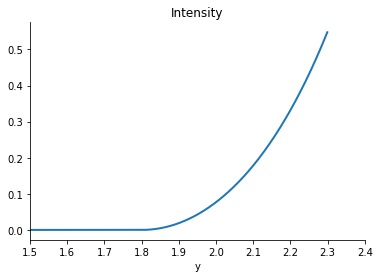

In [187]:
y = np.arange(0,2.3,0.001)
r1 = 1.5
r2=2.5
y_lower=1.8
intensity = r1*(np.exp(r2/2*(y- y_lower)**2)-1)*(y >= y_lower)
intensity2 = r1*(np.exp(r2/2*(y- 1.5)**2)-1)*(y >= 1.5)
plt.plot(y, intensity, label="1.7")
# plt.plot(y, intensity2, label="1.5")
plt.title('Intensity')
plt.xlabel('y')
plt.xlim(1.5, 2.4)
# plt.savefig('intensity_1p8.png', dpi=300)

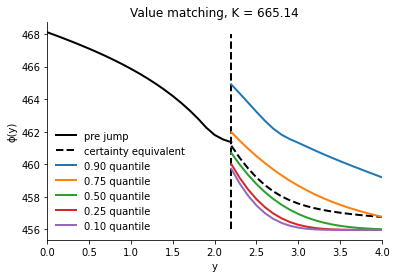

In [183]:
plt.plot(y_grid_cap, ϕ[:, loc1], label='pre jump', color="black")
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:, loc1], label="certainty equivalent", 
         color="black", linestyle="dashed")
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]
for i in range(len(quantile_list)):
    plt.plot(y_grid[numy_bar:], np.quantile(v_list[:, numy_bar:, loc1], quantile_list[4-i], axis=0), 
             label="{:.2f} quantile".format(quantile_list[4-i]))
# plt.plot(y_grid[numy_bar:], v_list[1][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[2][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[3][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[4][numy_bar:, loc1])
plt.xlabel('y')
plt.vlines(y_bar, 456, 468, color="black", linestyle="dashed")
plt.legend(loc=3)

plt.ylabel('ϕ(y)')
plt.title('Value matching, K = {:.2f}'.format(np.exp(k_grid[loc1])))
plt.xlim(0,4)
# plt.savefig('../figures/DICE_like/value_5_18.png', dpi=300)
plt.show()

In [180]:
ϕ.mean(), ϕ[-1, loc1], ϕ_bound[numy_bar, loc1]

(270.95074721347953, 461.35692704388623, 461.14044855692435)

In [292]:
(ϕ[-1, loc1] -  ϕ_bound[numy_bar, loc1])/ϕ[-1, loc1]

0.004626428760320372

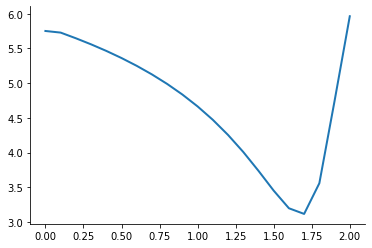

In [286]:
plt.plot(y_grid_cap, ems[:, loc1])

# Simulation

??:

$$
ME_t = \vartheta_t \theta \frac{1}{\lambda_t} \left[1 -  \frac{\mathcal{E}_t}{\alpha \lambda_t K_t }\right]^{\theta - 1}
$$

In [14]:
class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

ValueError: x and y must have same first dimension, but have shapes (41,) and (1,)

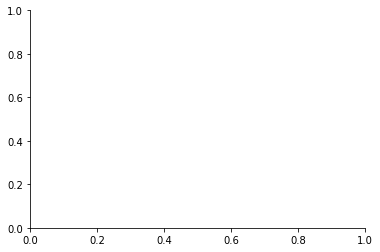

In [165]:
plt.plot(y_grid, i)
plt.show()

In [16]:
def simulate(res, y_grid, k_grid, Time=70, ppy=4):
    ems = res['ems']
    i = res['i']
    Time = 70
    ppy = 12
    pers = ppy * Time
    # pers = 100
    dt = Time / pers
    nDims = 3 
    its = 1

    gridpoints = (y_grid, k_grid)
    # interpolate emission
    e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')
    def e_func(x):
        return e_func_r.get_value(x[0], x[1]) # match order
    # interpolate investment
    i_func_r = GridInterp_2d(gridpoints, i, 'Linear')
    def i_func(x):
        return i_func_r.get_value(x[0], x[1])

    # drifts for each diffusion process
    def compute_μlogk(x):
        return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
    def compute_μy(E_x):
        return  E_x*np.mean(θ_list)
    def compute_μlogd(x, E_x):
        Y_x = x[0]
        dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
        ddΛ = γ2 + γ3*(Y_x > y_bar)  
        return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

    # initial points

    K_0 = 80/α
    Y_0 = 1.1
    D_0 = -γ1*Y_0 - 0.5*γ2*Y_0**2

    hist = np.zeros([pers, nDims])
    e_hist = np.zeros([pers])
    i_hist = np.zeros([pers])

    for tm in range(pers):
        if tm == 0:
            # initial points
            hist[0,:] = [Y_0, np.log(K_0), D_0]
            e_hist[0] = e_func(hist[0,:])
            i_hist[0] = i_func(hist[0,:])

        else:
            # other periods
            hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
            hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
            hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
            e_hist[tm] = e_func(hist[tm,:])
            i_hist[tm] = i_func(hist[tm,:])

    e_k_ratio = e_hist/np.exp(hist[:,1])/α
    Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
    XK_t = α*θ_bar*Iota_t**θ
    MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

    simul = dict(e= e_hist, states= hist)
    return simul

In [16]:
Time = 53
ppy = 1
pers = ppy * Time
# pers = 100
dt = Time / pers
nDims = 3 
its = 1

gridpoints = (y_grid_cap, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')
def e_func(x):
    return e_func_r.get_value(x[0], x[1]) # match order
# interpolate investment
i_func_r = GridInterp_2d(gridpoints, i_new, 'Linear')
def i_func(x):
    return i_func_r.get_value(x[0], x[1])

# drifts for each diffusion process
def compute_μlogk(x):
    return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
def compute_μy(E_x):
    return  E_x*np.mean(θ_list)
def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
    ddΛ = γ2 + γ3*(Y_x > y_bar)  
    return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

# initial points

K_0 = 80/α
Y_0 = 1.1
D_0 = -γ1*Y_0 - 0.5*γ2*Y_0**2

hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])
prob_hist = np.zeros([pers])

for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [Y_0, np.log(K_0), D_0]
        e_hist[0] = e_func(hist[0,:])
        i_hist[0] = i_func(hist[0,:])
        prob_hist[0] = 1 - r1*(np.exp(r2/2*(hist[0,0]- y_lower)**2)-1)*(hist[0,0] >= y_lower)*dt

    else:
        # other periods
        hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
        hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
        hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
        e_hist[tm] = e_func(hist[tm,:])
        i_hist[tm] = i_func(hist[tm,:])
        prob_hist[tm] = (1 - r1*(np.exp(r2/2*(hist[tm,0]- y_lower)**2)-1)*(hist[tm,0] >= y_lower)*dt)*prob_hist[tm-1]

e_k_ratio = e_hist/np.exp(hist[:,1])/α
Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
XK_t = α*θ_bar*Iota_t**θ
MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

simul = dict(e= e_hist, states= hist)

NameError: name 'y_grid_cap' is not defined

(0.0, 17.678049565927104)

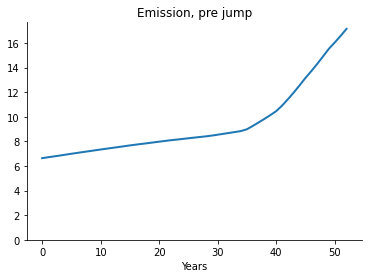

In [248]:
plt.plot(np.arange(0, Time, dt), e_hist)
plt.xlabel('Years')
plt.title('Emission, pre jump')
plt.ylim(0)
# plt.savefig('Et_pre_jump.png')

Text(0.5, 1.0, '$\\frac{E_t}{\\alpha K_t}$')

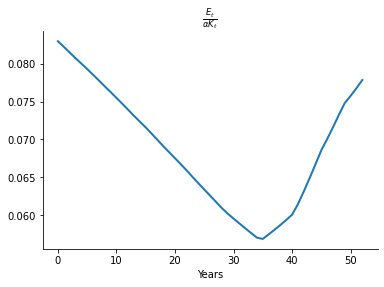

In [250]:
plt.plot(np.arange(0, Time, dt), e_k_ratio)
plt.xlabel('Years')
plt.title(r'$\frac{E_t}{\alpha K_t}$')
# plt.savefig('ratio.png')

Text(0.5, 1.0, '$\\iota_t$')

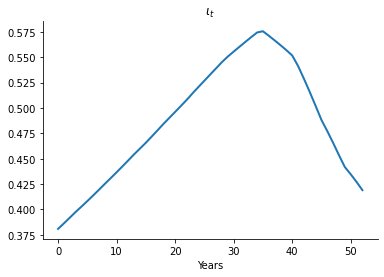

In [252]:
plt.plot(np.arange(0, Time, dt), Iota_t)
plt.xlabel('Years')
plt.title(r"$\iota_t$")
# plt.savefig('iota_t.png')

In [256]:
hist[:,0]

array([1.1       , 1.11236072, 1.12485397, 1.1374775 , 1.15023096,
       1.16312104, 1.17614541, 1.18930169, 1.20258749, 1.21599991,
       1.22954263, 1.2432129 , 1.25700795, 1.27092499, 1.2849612 ,
       1.2991251 , 1.31341497, 1.32781998, 1.34233642, 1.35696114,
       1.37170121, 1.38655662, 1.40152465, 1.41660133, 1.4317721 ,
       1.44704232, 1.46241412, 1.47788514, 1.49345304, 1.50911546,
       1.52489354, 1.54080627, 1.55685487, 1.57304059, 1.58936469,
       1.60583209, 1.62257257, 1.63981843, 1.6575897 , 1.67590731,
       1.6947937 , 1.7142778 , 1.73460187, 1.75589357, 1.77820949,
       1.80160886, 1.82613449, 1.85168599, 1.87832097, 1.90610054,
       1.93503383, 1.96491423, 1.99579373])

Text(0.5, 1.0, 'Yt')

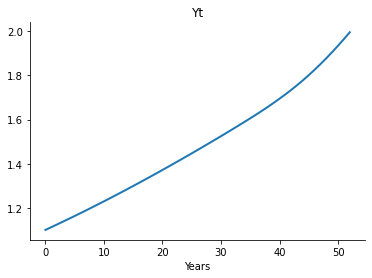

In [258]:
plt.plot(np.arange(0, Time, dt), hist[:,0])
plt.xlabel('Years')
plt.title("Yt")
# plt.savefig('Yt.png')

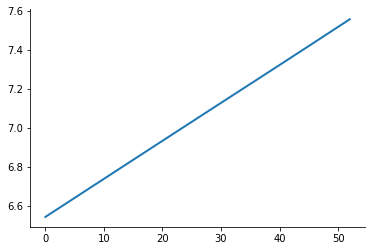

In [257]:
plt.plot(simul['states'][:, 1])